In [1]:
from datasets.pamap2 import PAMAP2
from datasets.opportunity import Opportunity
from datasets.mmfit import MMFit
from datasets.motionsense import MotionSense
from datasets.mhealth import MHEALTH

from models.cnn import CNN
from models.convlstm import ConvLSTM
from models.gru import GRU
from models.lstm import LSTM
from models.transformer import Transformer

import numpy as np
import csv
from pprint import pprint
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import ast
import sys


/Users/geissler/Documents/GitHub/BeyondConfusion/datasets/pamap2/dataset
/Users/geissler/Documents/GitHub/BeyondConfusion/datasets/opportunity/dataset
/Users/geissler/Documents/GitHub/BeyondConfusion/datasets/mmfit/dataset
/Users/geissler/Documents/GitHub/BeyondConfusion/datasets/mhealth/dataset
/Users/geissler/Documents/GitHub/BeyondConfusion/datasets/motionsense/dataset


In [2]:
# DATASET LOOP
dir = './outputs/H100/'
DATASET_LIST = ['PAMAP2','OPPORTUNITY','MMFIT','MHEALTH','MOTIONSENSE']
MODEL_LIST = ['CNN','CONVLSTM','GRU','LSTM','TRANSFORMER']

BATCH_LIST = [64, 256, 1024]
LR_LIST = [0.1, 0.01, 0.001]

WINDOW = 200
STRIDE = 100

STEP = 20
GAMMA = 0.5
PATIENCE = 40
NUM_EPOCHS = 200
best_rows = {}

for DATASET in DATASET_LIST:   
    # MODEL LOOP
    for MODEL in MODEL_LIST:
        print("\nDATASET: " + DATASET)
        print("MODEL: " + MODEL)

        best_accuracy = 0
        best_loss = float('inf')
        best_batch = 0
        best_lr = 0
        best_exp_id = []
        
       
        for BATCH in BATCH_LIST:
            for LR in LR_LIST:
                total_accuracy = 0
                total_loss = 0
                total_rows = 0
                exp_id = []
                rows = []
                with open(dir + DATASET+'_'+MODEL+'.csv', 'r') as csvfile:
                    csvreader = csv.reader(csvfile)
                    for row in csvreader:
                        if int(row[3]) == BATCH and float(row[4]) == LR:
                            #print(row)
                            
                            total_accuracy += float(row[8])
                            total_loss += float(row[9]) 
                            total_rows += 1
                            exp_id.append(row[0])
                            rows.append(row)
                
                # rows = sorted(rows, key=lambda x: x[5])
                # print(rows)
                average_accuracy = total_accuracy / total_rows if total_rows > 0 else 0
                #print(average_accuracy)
                average_loss = total_loss / total_rows if total_rows > 0 else float('inf')

                if average_accuracy > best_accuracy:
                    best_accuracy = average_accuracy
                    best_loss = average_loss
                    best_batch = BATCH
                    best_lr = LR
                    best_exp_id=exp_id
                    best_rows[(DATASET, MODEL)] = rows


        # Output the best batch size and learning rate
        print("Best Batch Size:", best_batch)
        print("Best Learning Rate:", best_lr)
        print("Best Accuracy:", best_accuracy)
        print("Best Loss:", best_loss)
        print("Best IDs:", best_exp_id)


# pprint(best_rows)
print(best_rows)
                   
                
            


DATASET: PAMAP2
MODEL: CNN
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.6583331289905543
Best Loss: 1.2790684447478147
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: CONVLSTM
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.708407681609401
Best Loss: 0.9856696200815881
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: GRU
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.6594467031269567
Best Loss: 1.314249312944287
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: LSTM
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.6594911273312486
Best Loss: 1.2575467278700228
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47']

DATASET: PAMAP2
MODEL: TRANSFORMER
Best Batch Size: 256
Best Learning Rate: 0.001
Best Accuracy: 0.7485665669164424
Best Loss: 0.8517638966828149
Best IDs: ['40', '41', '42', '43', '44', '45', '46', '47'

In [3]:
WINDOW = 200
STRIDE = 100

# ds = PAMAP2(users=[2], window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
# print(len(ds))
# x_data= [ds[i][0][0][[1,2,3]] for i in range(0,len(ds))]
# x_data = [tensor.numpy() for tensor in x_data]
# x_data = np.vstack(x_data)
# print(x_data.shape)

In [4]:
import matplotlib.pyplot as plt

vectors = []
gt = []
predict = []
sensors = []

for DATASET in DATASET_LIST:
    dataset_vectors, dataset_gt, dataset_predict, dataset_sensors = [], [], [], []
    
    sensorLoader = 0
    for MODEL in MODEL_LIST:
        model_vectors, model_gt, model_predict, model_sensors = [], [], [], []
        
        for person in best_rows[DATASET, MODEL]:
            data = np.load(dir + DATASET + '_' + MODEL + '_' + person[0] + '.npz', allow_pickle=True)
            y = np.concatenate(data['y'])
            outputs = np.concatenate(data['outputs'])
            max_outputs = np.argmax(outputs, axis=1)

            comparison = y != max_outputs
            result = comparison.astype(int)

            model_vectors.append(result)
            model_gt.append(y)
            model_predict.append(outputs)

            if sensorLoader==0:
                
                if DATASET == 'PAMAP2':
                    print("PAMAP2")
                    indices = [0, 1, 2, 13, 14, 15, 26, 27, 28]
                    ds = PAMAP2(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=[1, 2, 3, 4, 5, 6, 7, 8])
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET=='OPPORTUNITY':
                    print("OPPORTUNITY")
                    indices = [i for i in range(1, 37)]
                    ds = Opportunity(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE)
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MMFIT':
                    print("MMFIT")
                    indices = [0,1,2,6,7,8,12,13,14,18,19,20]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MMFit(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, frequency=50, columns=None, train_users=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MHEALTH':
                    print("MHEALTH")
                    indices = [i for i in range(0, 21)]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MHEALTH(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                elif DATASET == 'MOTIONSENSE':
                    print("MOTIONSENSE")
                    indices = [i for i in range(0, 12)]
                    # indices = [3,4,5,9,10,11,15,16,17,21,22,23]
                    ds = MotionSense(users=ast.literal_eval(person[5]), window_size=WINDOW, window_step=STRIDE, train_users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]) 
                    x_data = np.vstack([tensor.numpy() for tensor in [ds[i][0][0][indices] for i in range(len(ds))]])
                    model_sensors.append(x_data)
                else:
                    print("Wrong DATASET")
                    sys.exit(0)

        
        
        dataset_vectors.append(model_vectors)
        dataset_gt.append(model_gt)
        dataset_predict.append(model_predict)
        
        if sensorLoader==0:
            sensors.append(model_sensors)
            sensorLoader = 1
    
    vectors.append(dataset_vectors)
    gt.append(dataset_gt)
    predict.append(dataset_predict)





PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [3674, 468, 446, 512, 650, 185, 502, 594, 347, 304, 413, 578, 266]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2915, 484, 458, 503, 631, 331, 509, 578, 234, 193, 486, 660, 177]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2525, 544, 469, 435, 445, 426, 472, 405, 318, 299, 459, 471, 259]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2048, 474, 537, 443, 641, 493, 491, 525, 285, 254, 489, 661, 153]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [2233, 467, 461, 487, 514, 457, 410, 534, 266, 225, 422, 755, 4]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11], [1961, 461, 510, 494, 639, 454, 551, 334, 285, 401, 500]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1616, 512, 246, 515, 674, 72, 454, 575, 353, 232, 431, 590]]
PAMAP2
Classes - Counts [[0, 1, 2, 3, 4, 8, 9, 10, 11], [1566, 441, 57

In [5]:
print(len(sensors[0][0]))

8939


/var/folders/wd/jp3qk8gd7j9gb75gs1y7z_2c0000gp/T/ipykernel_43815/1732522090.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  result_sum = np.sum((i for i in result_arrays),dtype=int)


8939


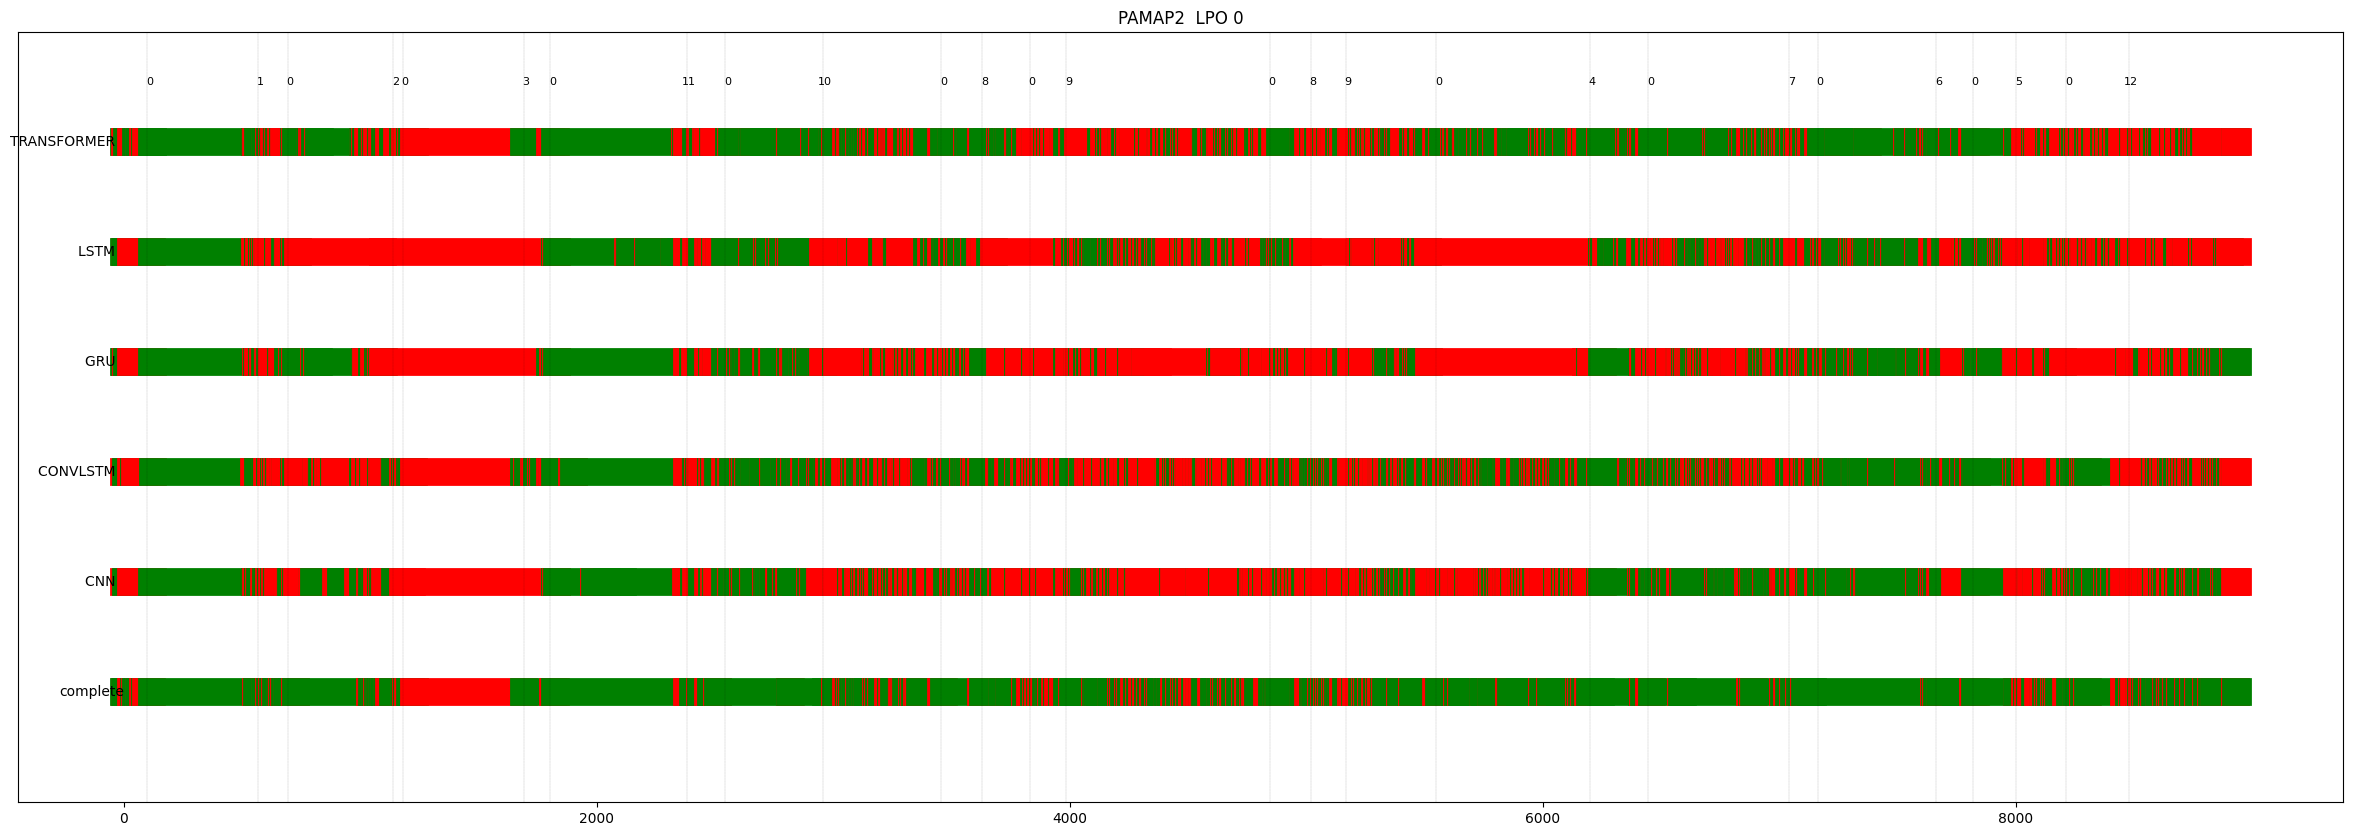

8159


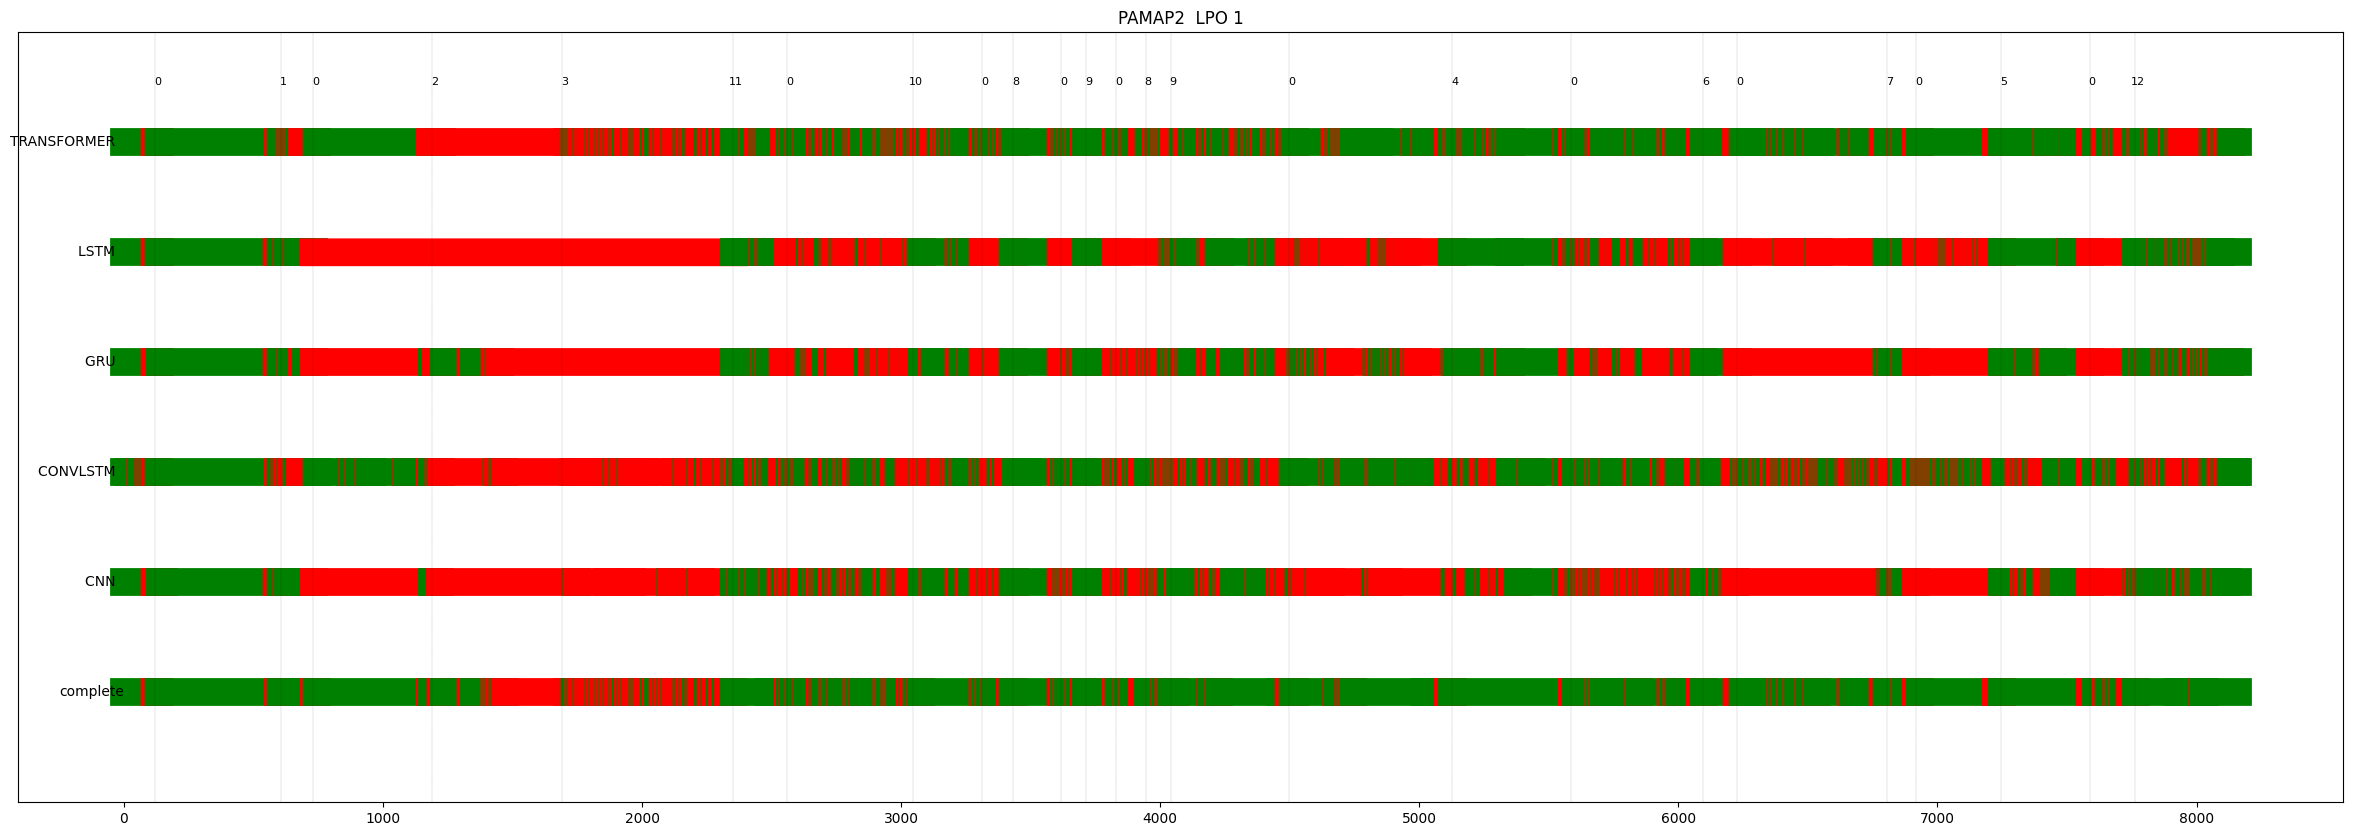

7527


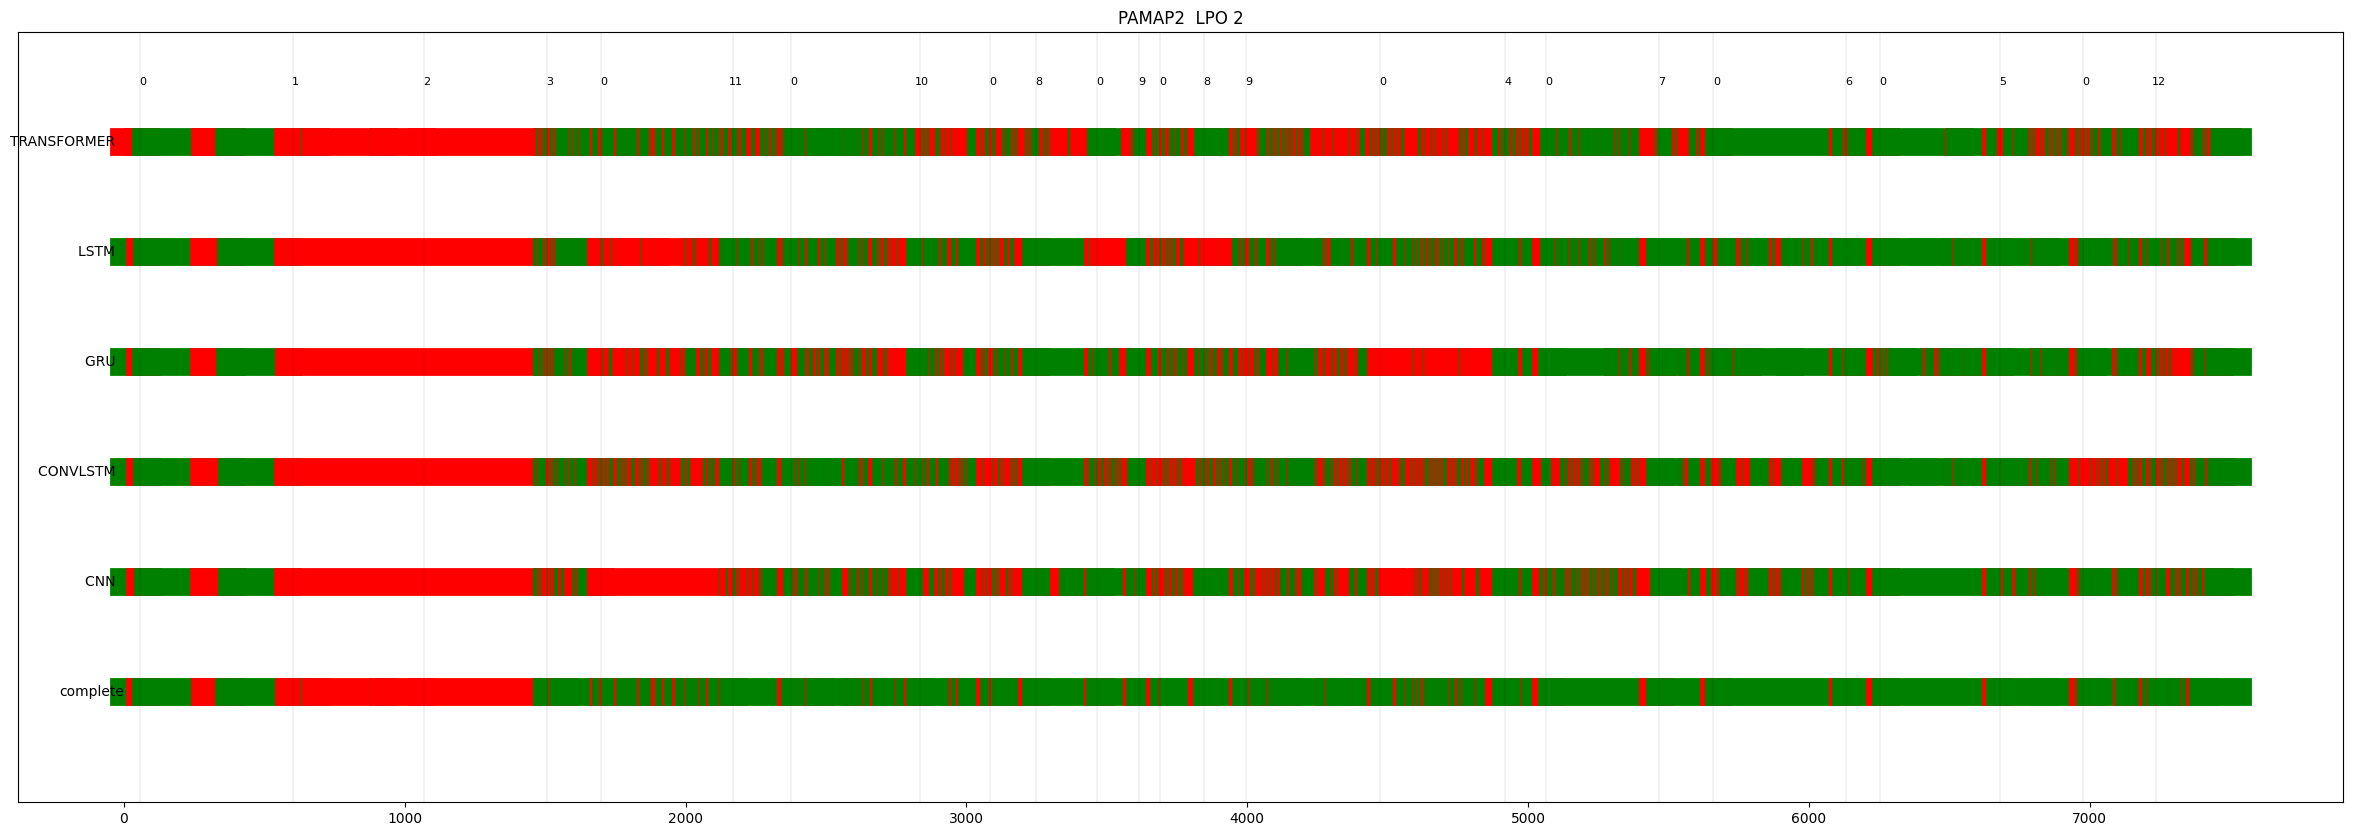

7494


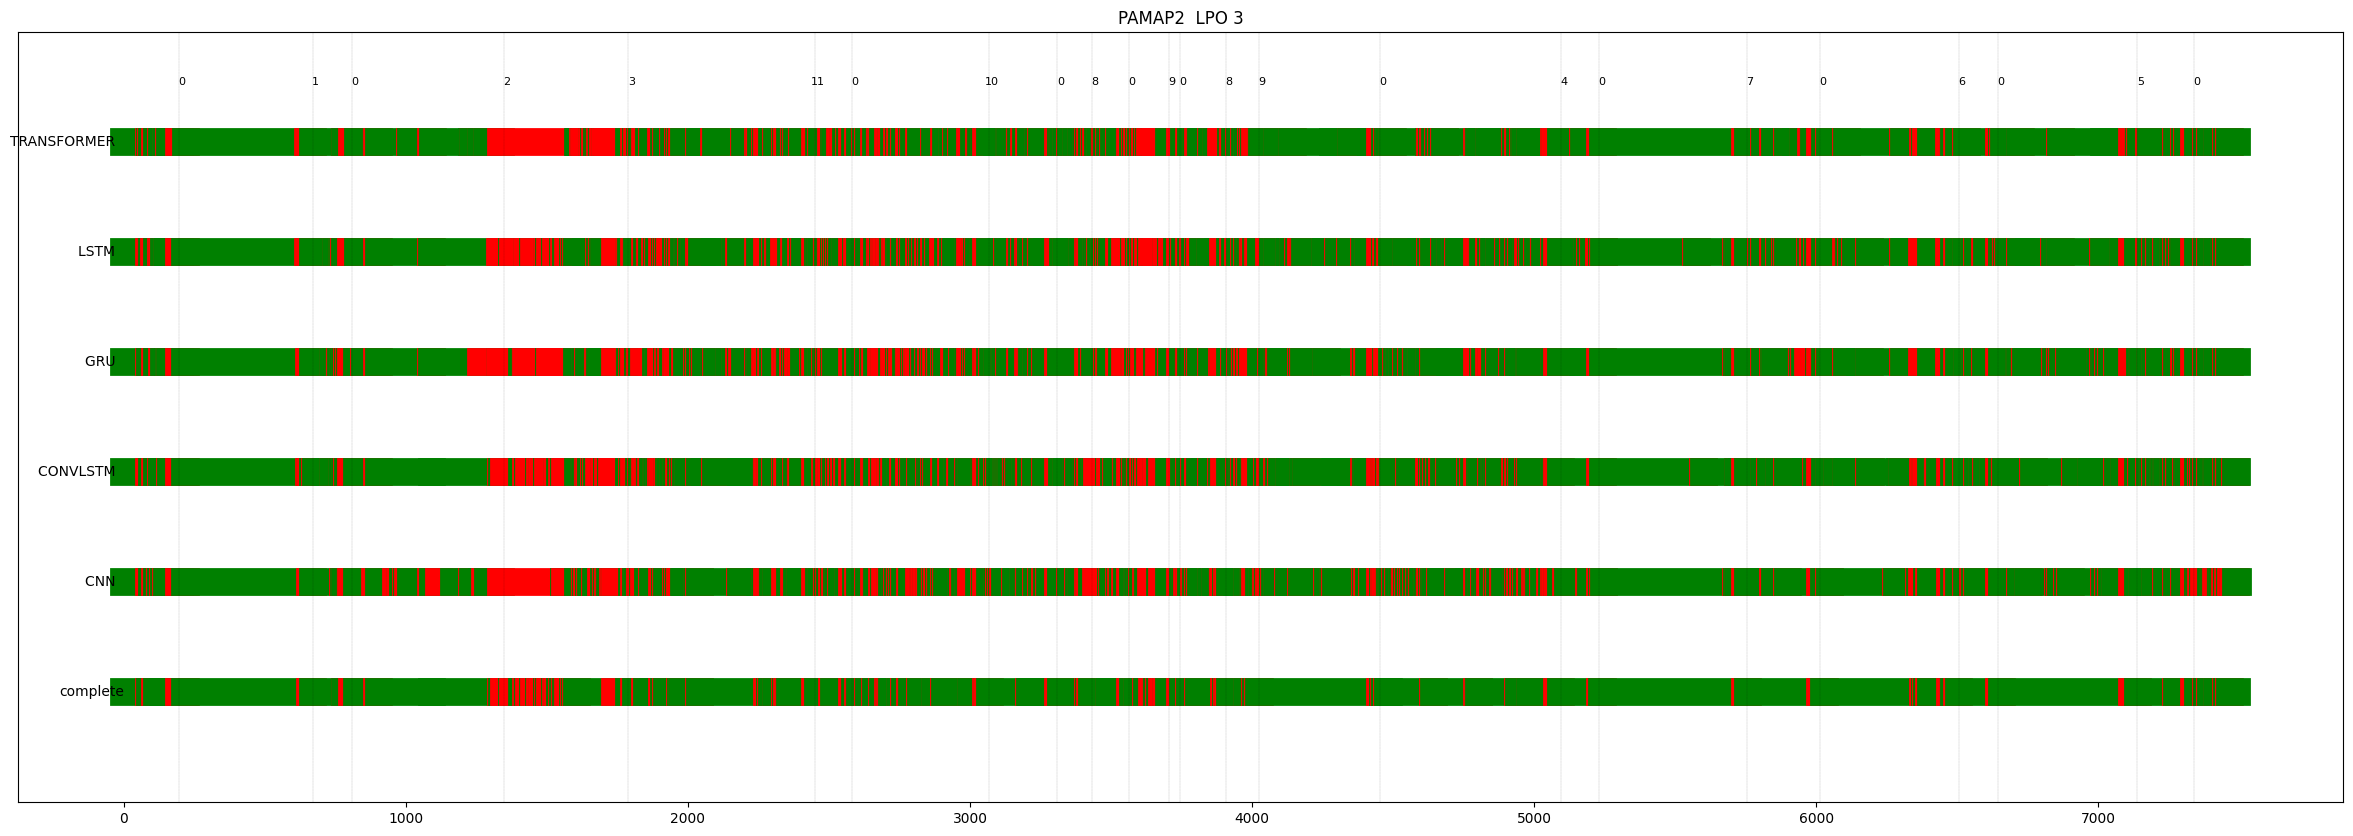

7235


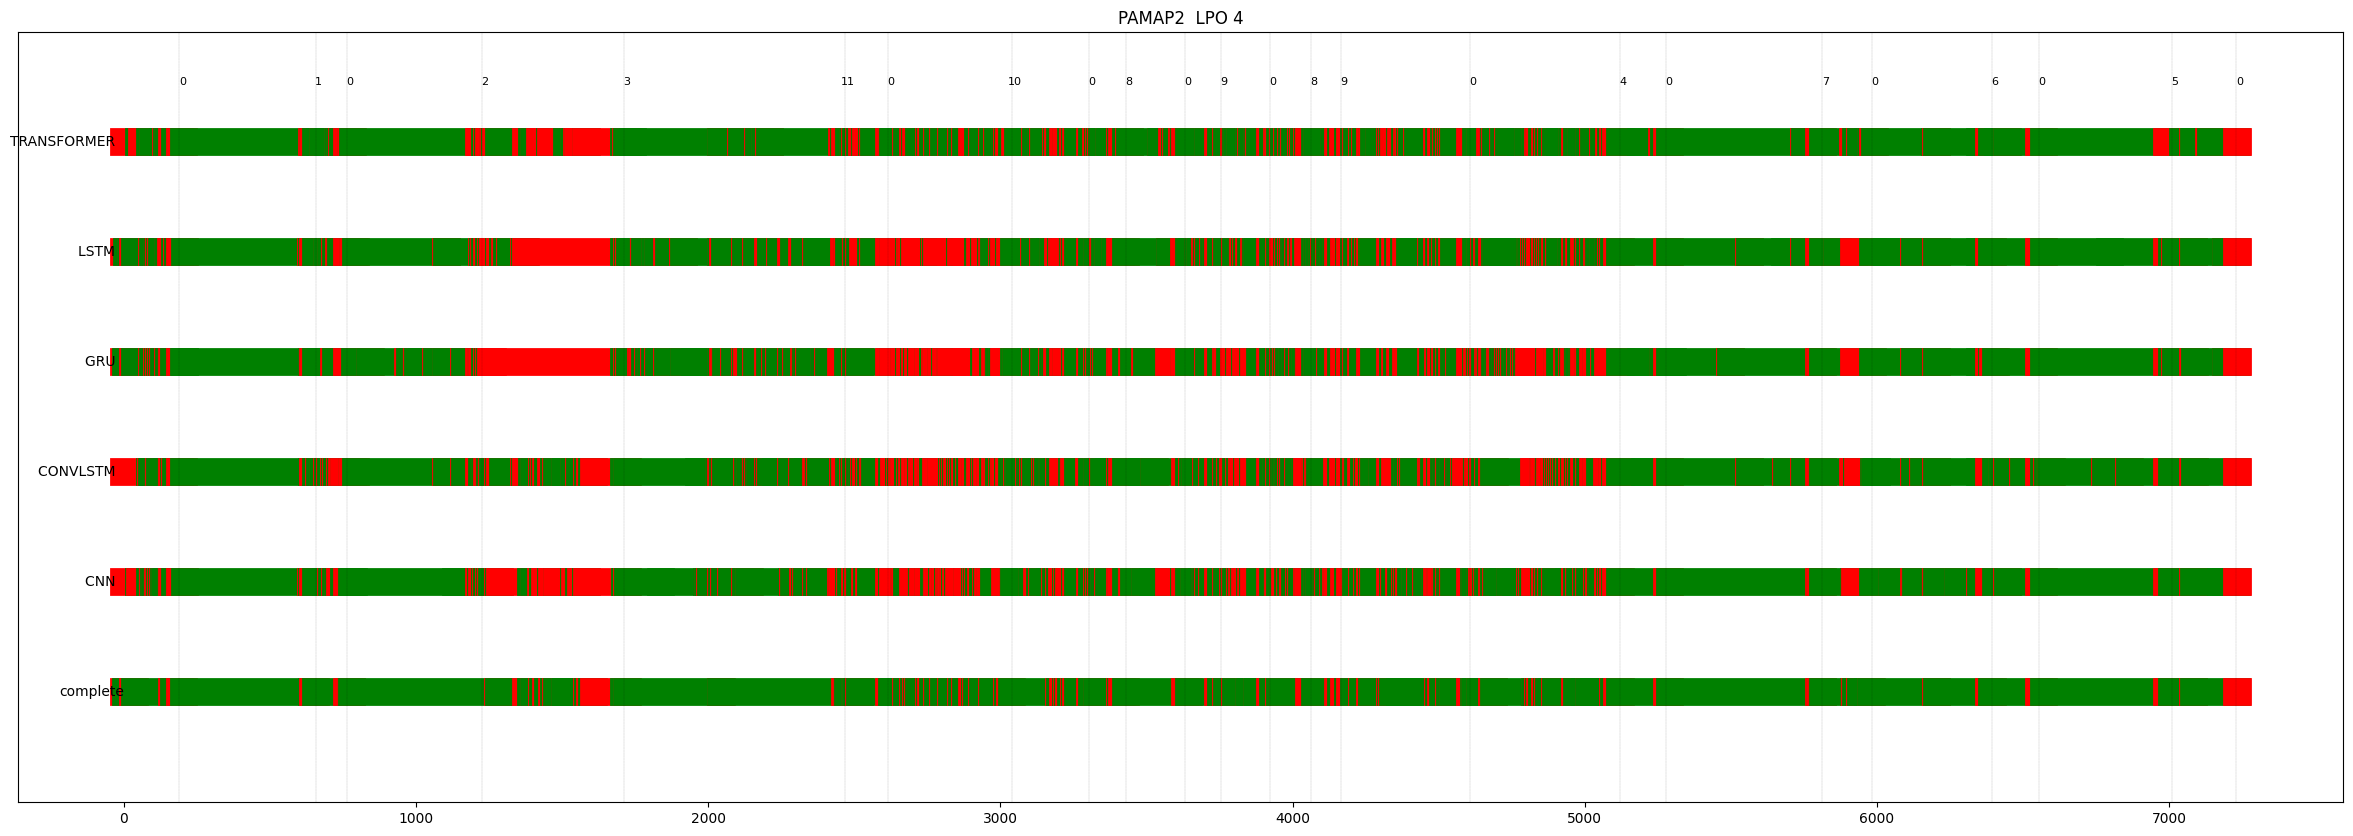

6590


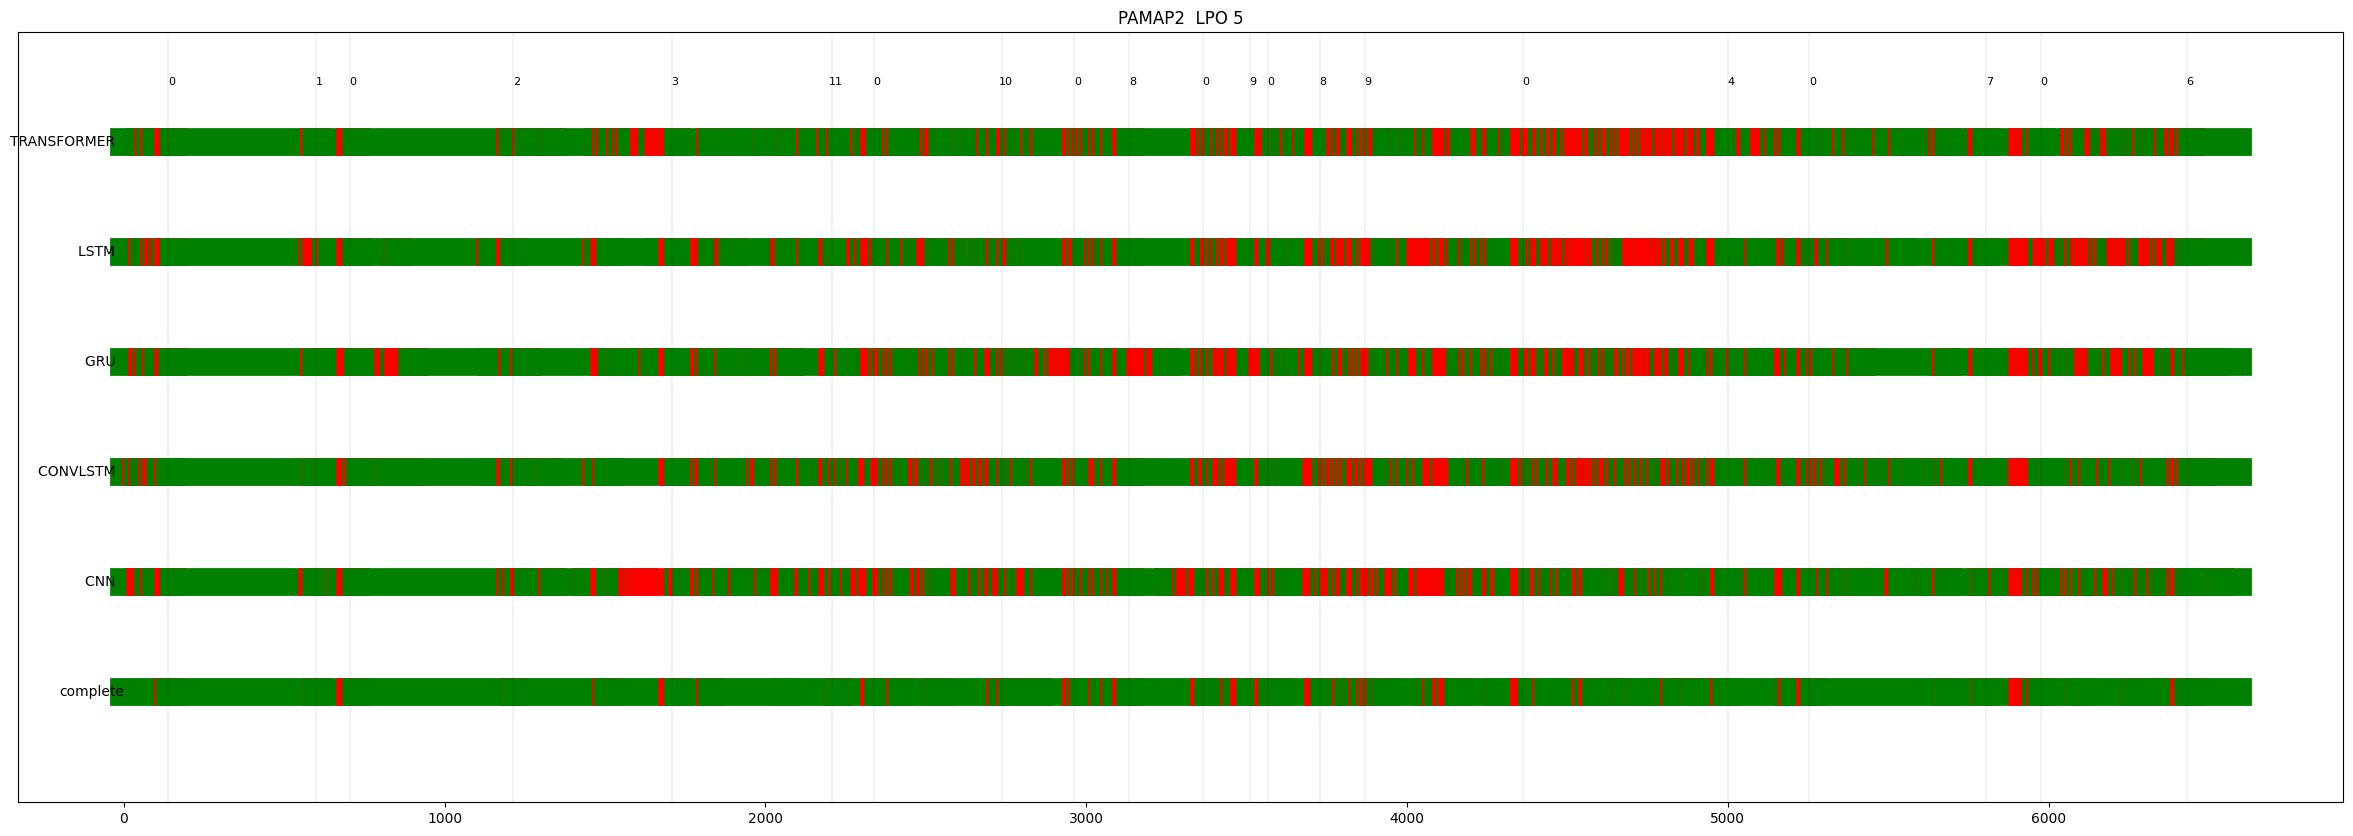

6270


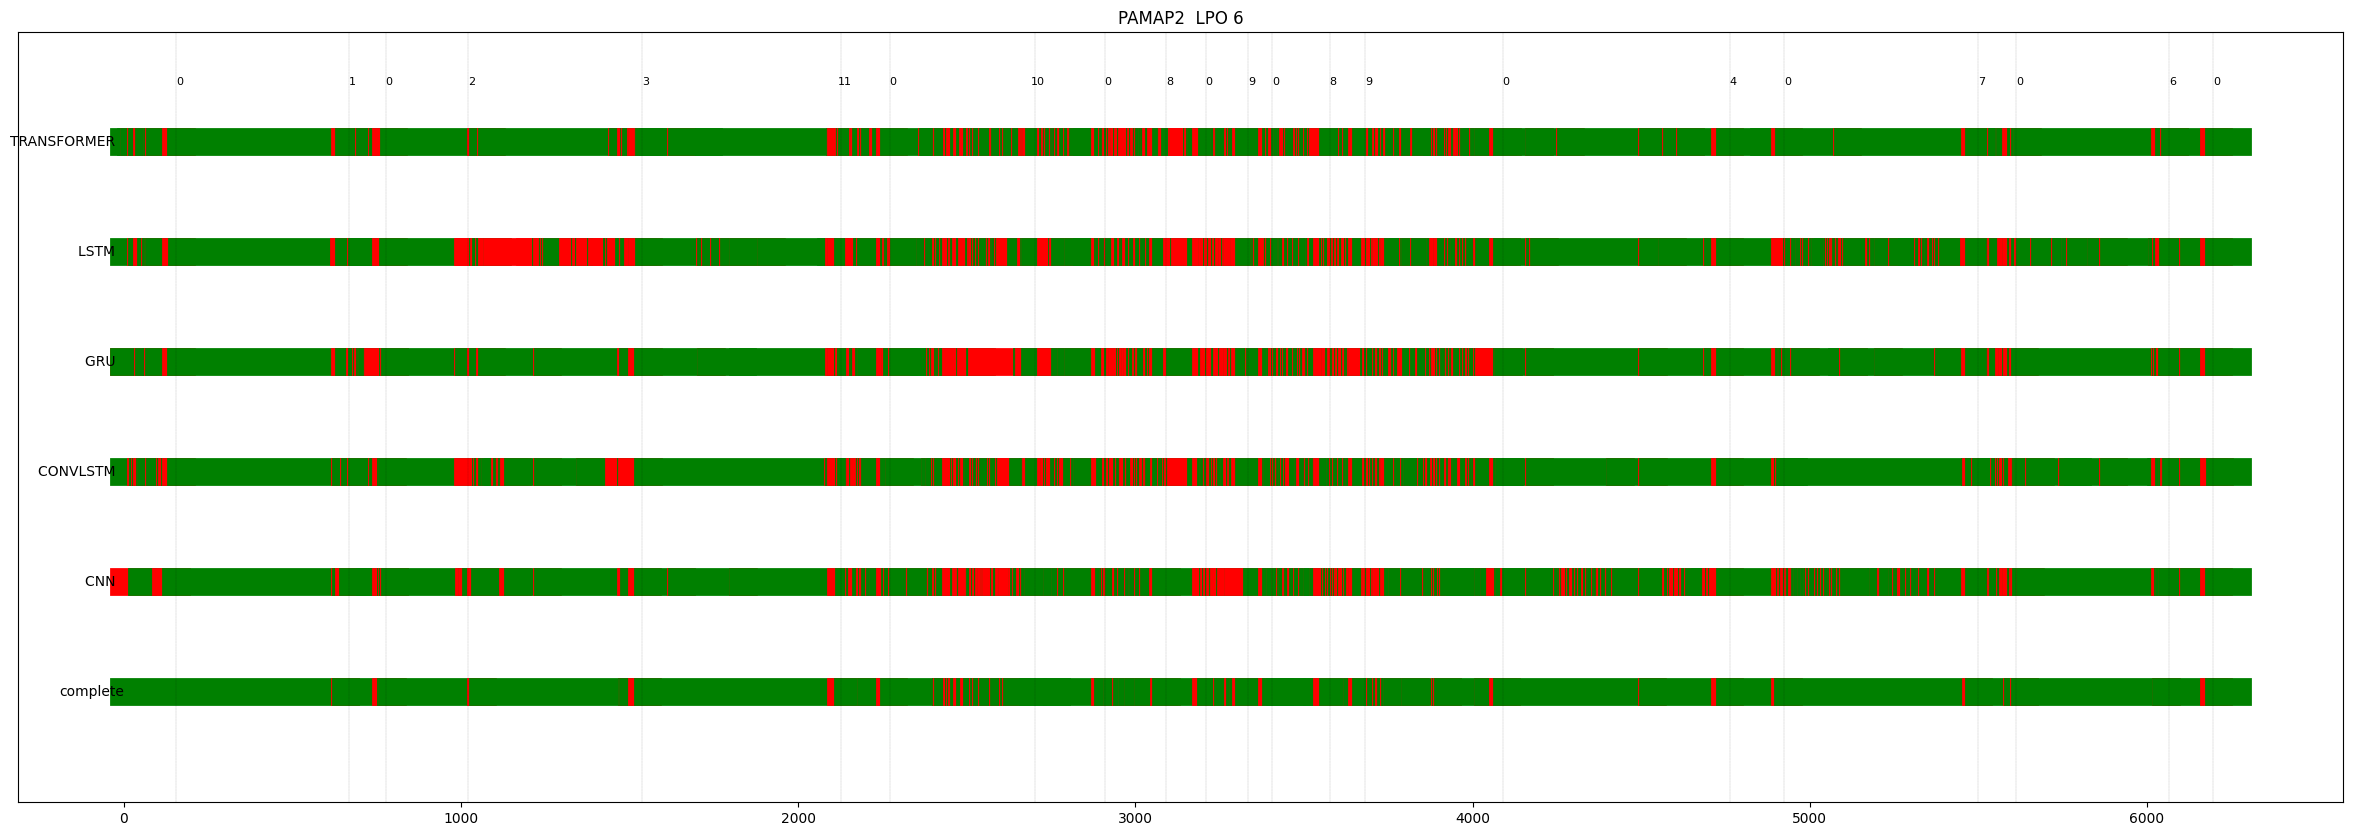

5055


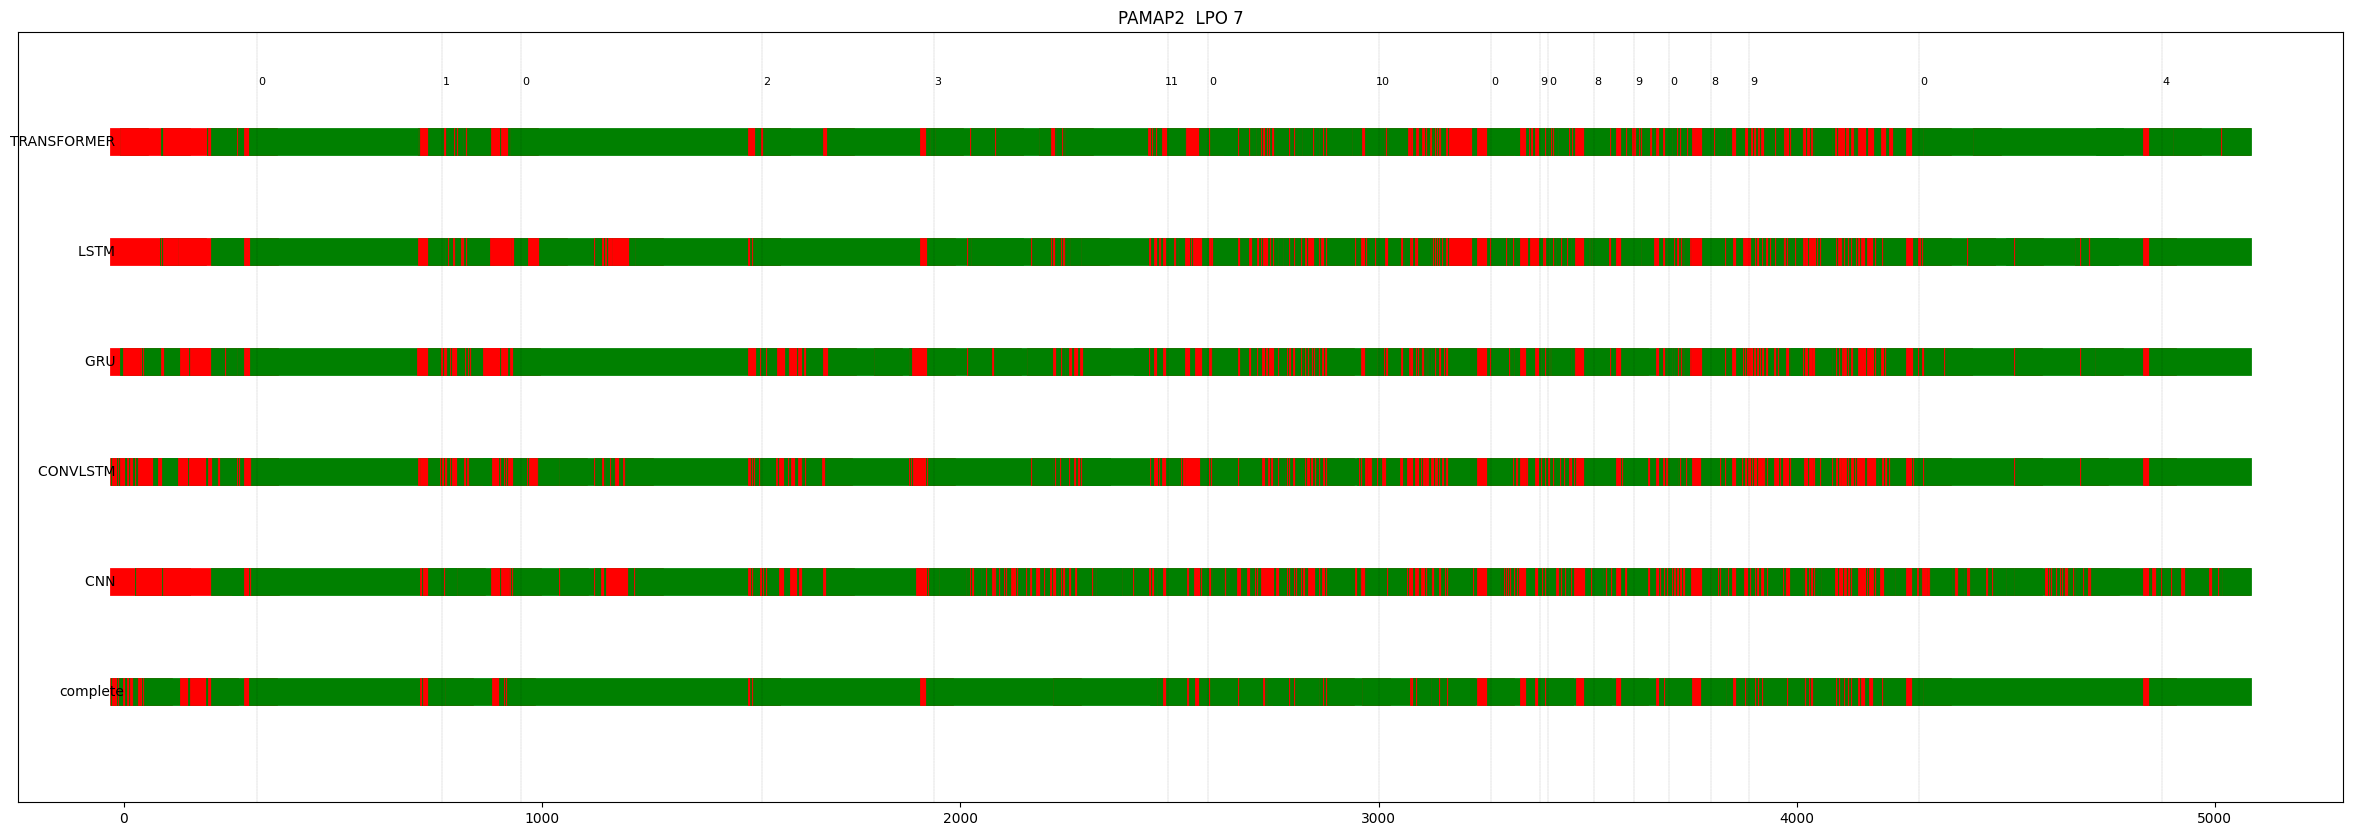

2337


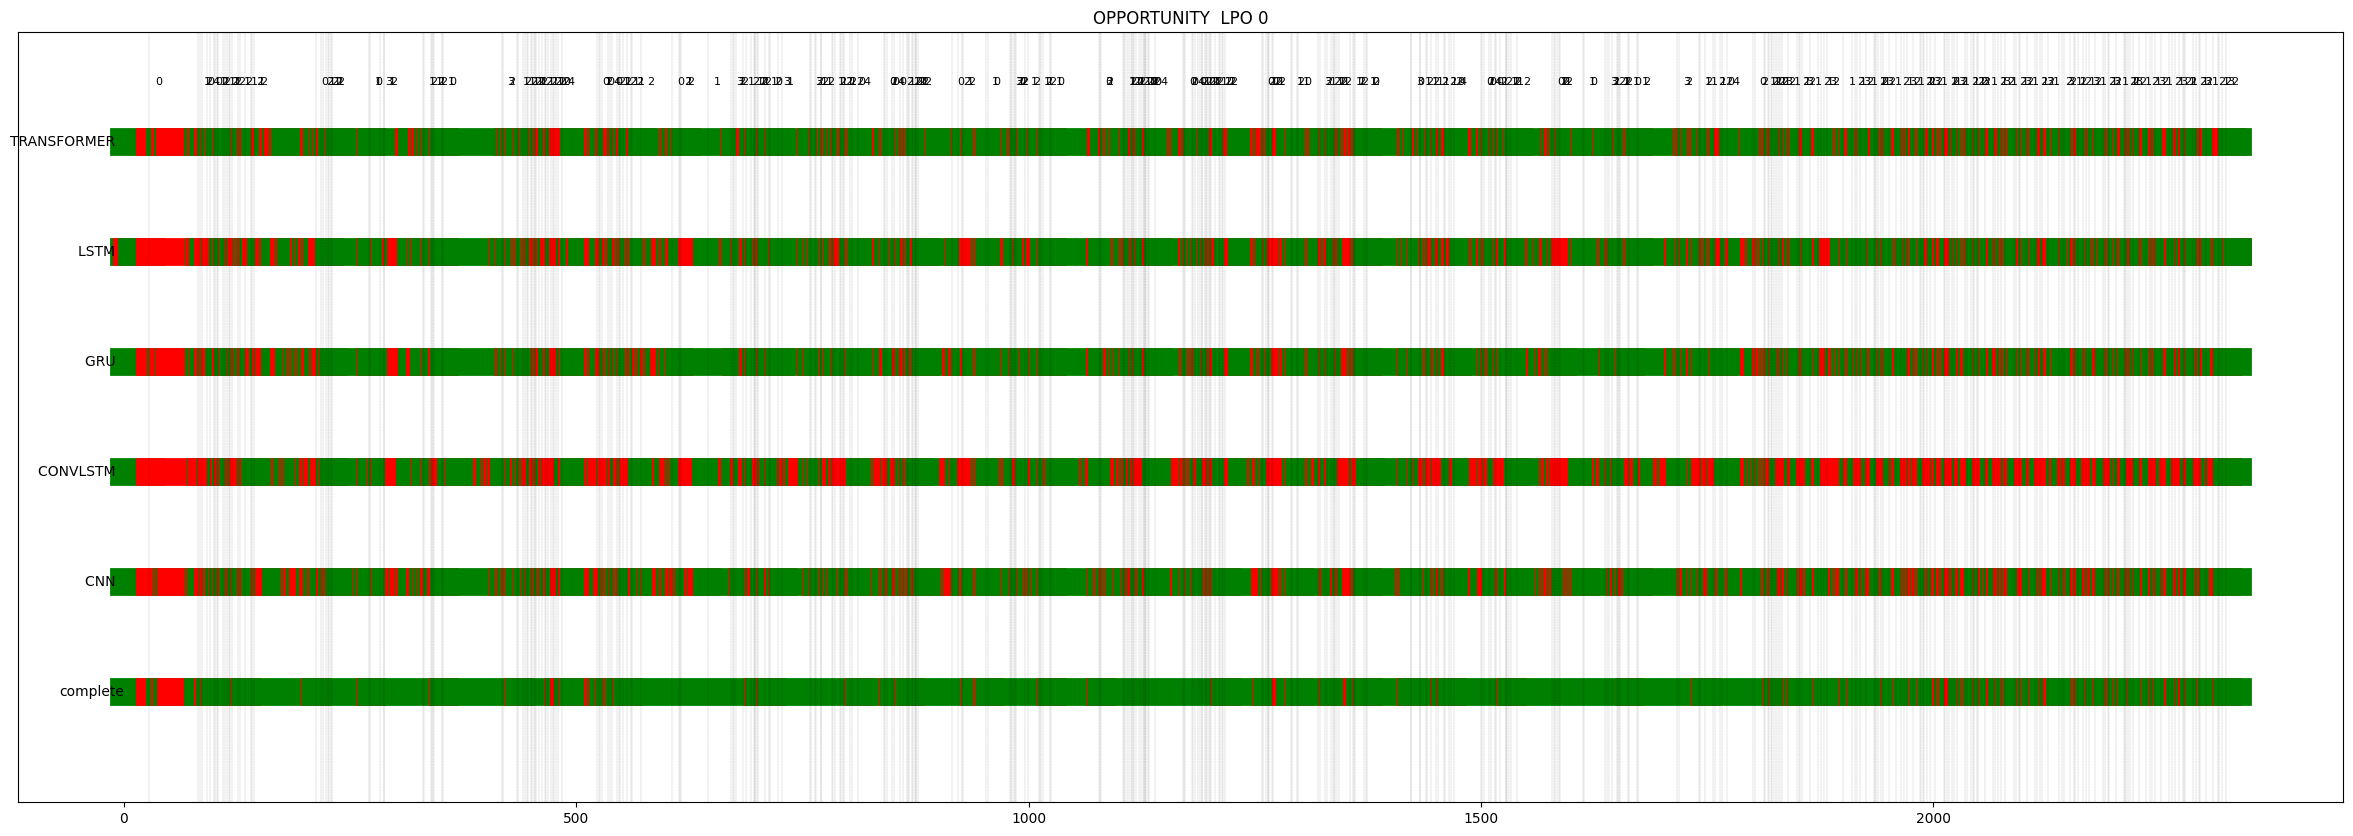

2235


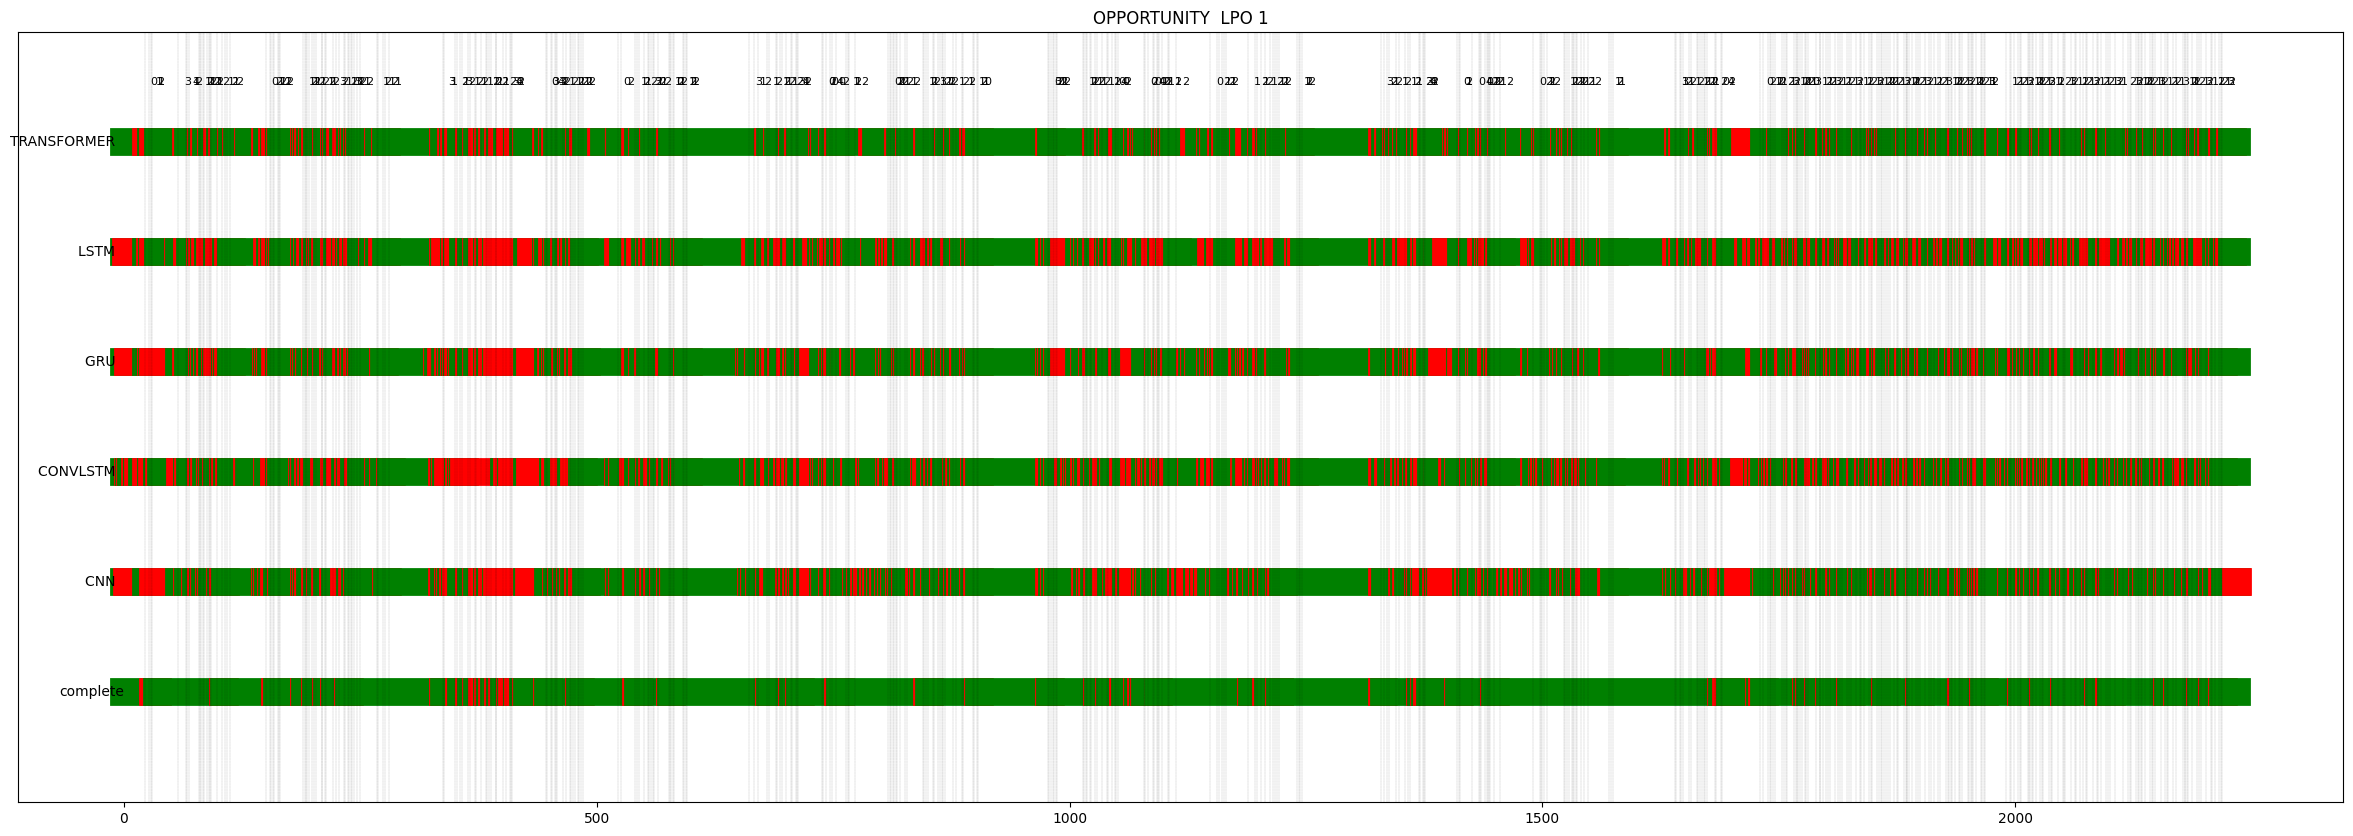

2150


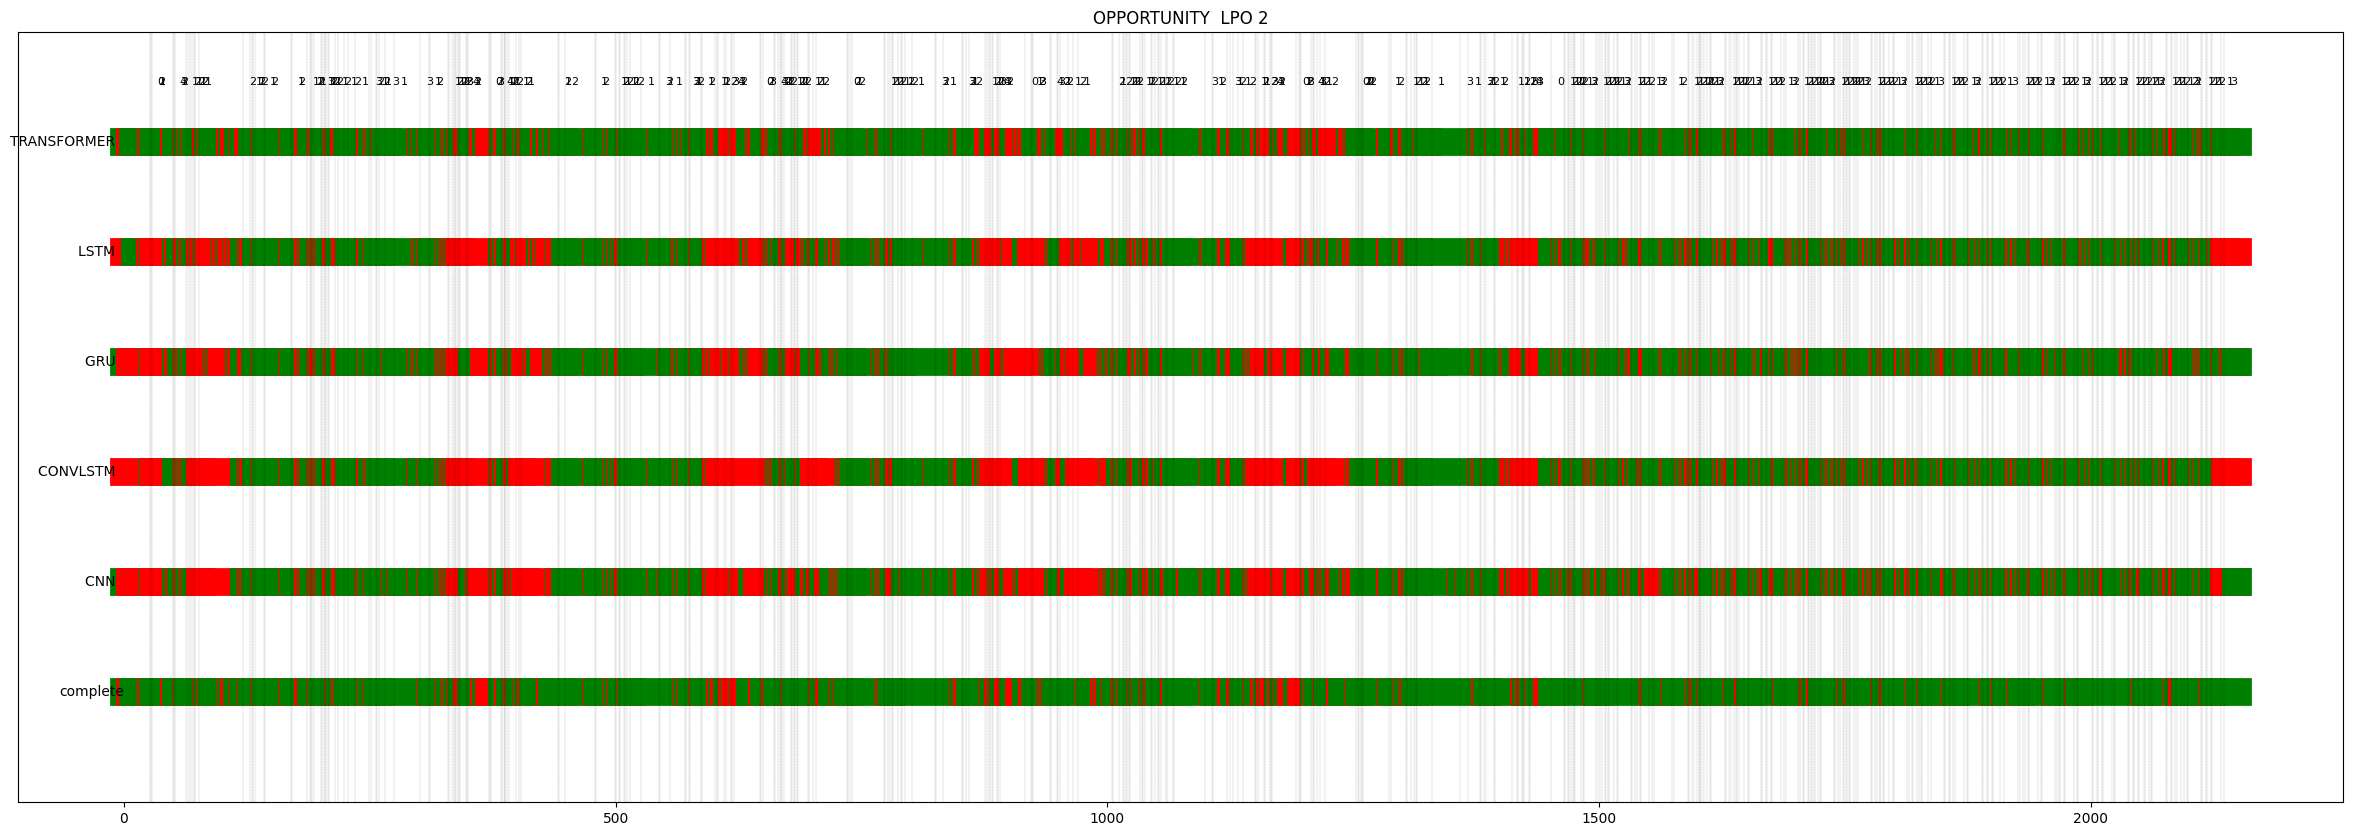

1916


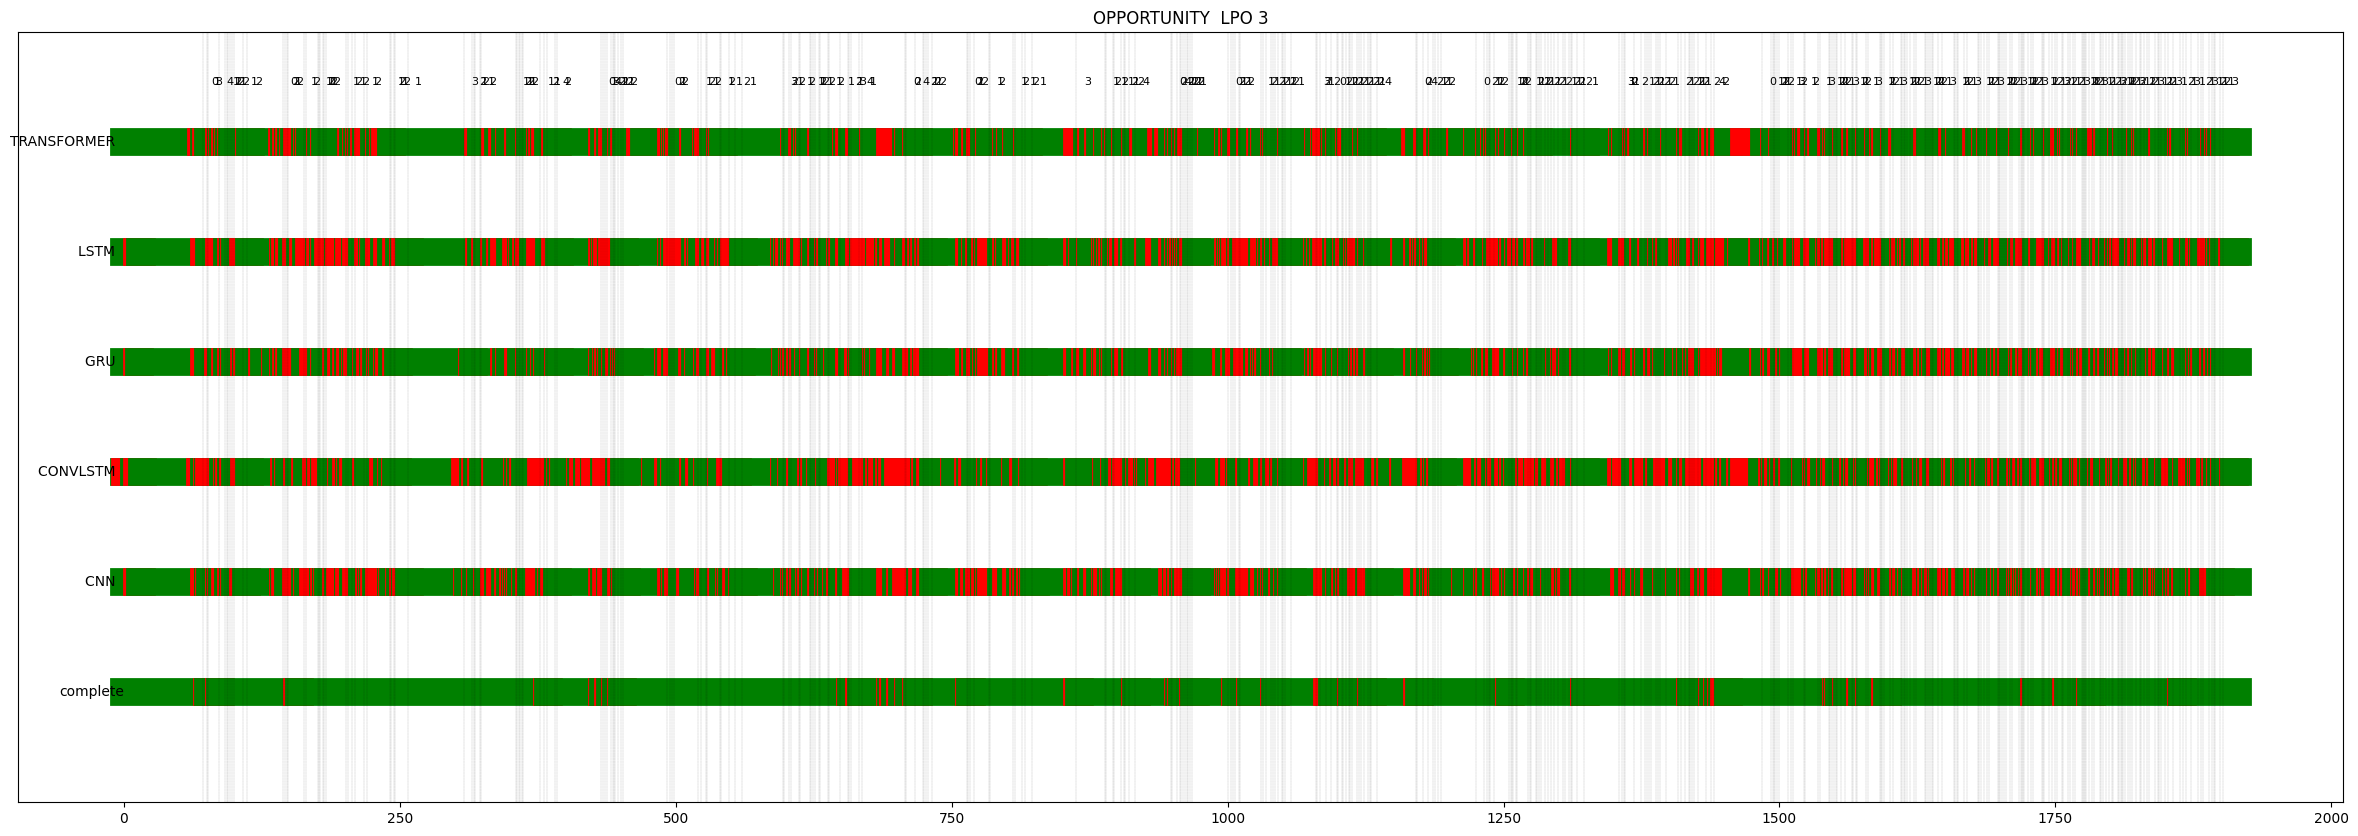

3936


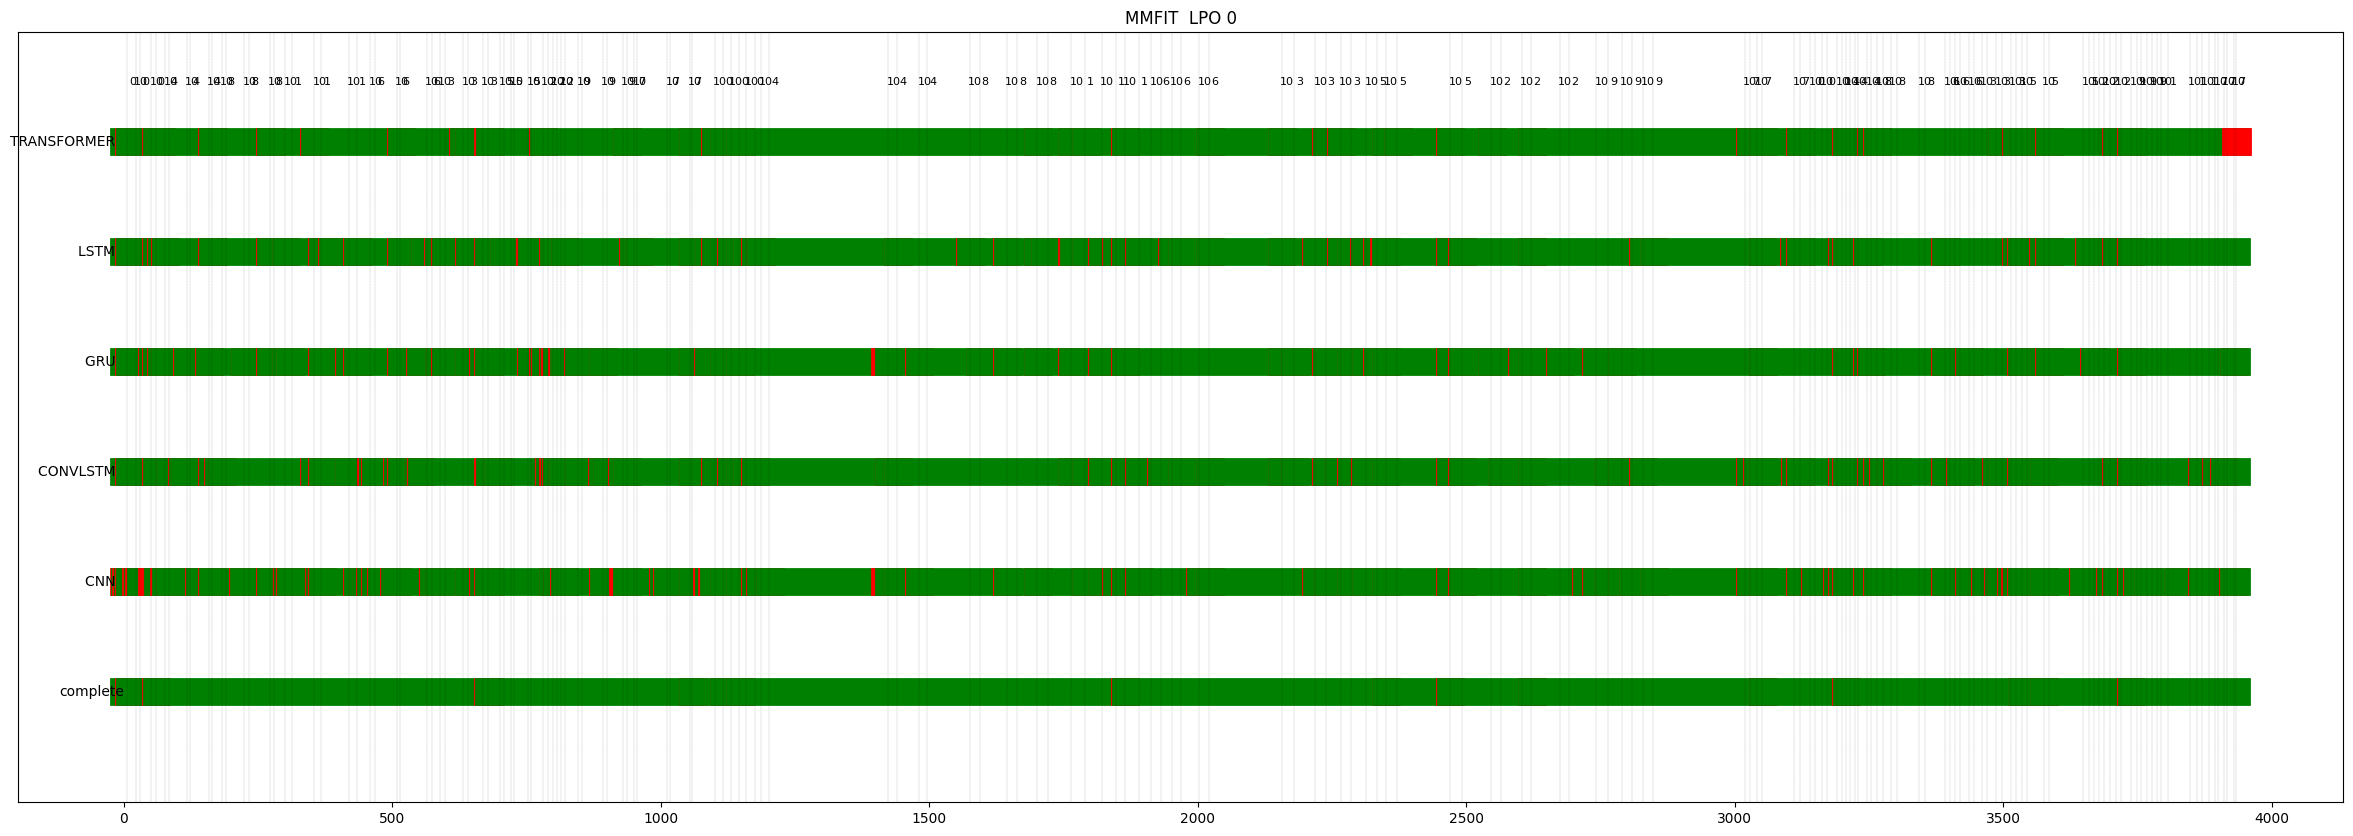

3939


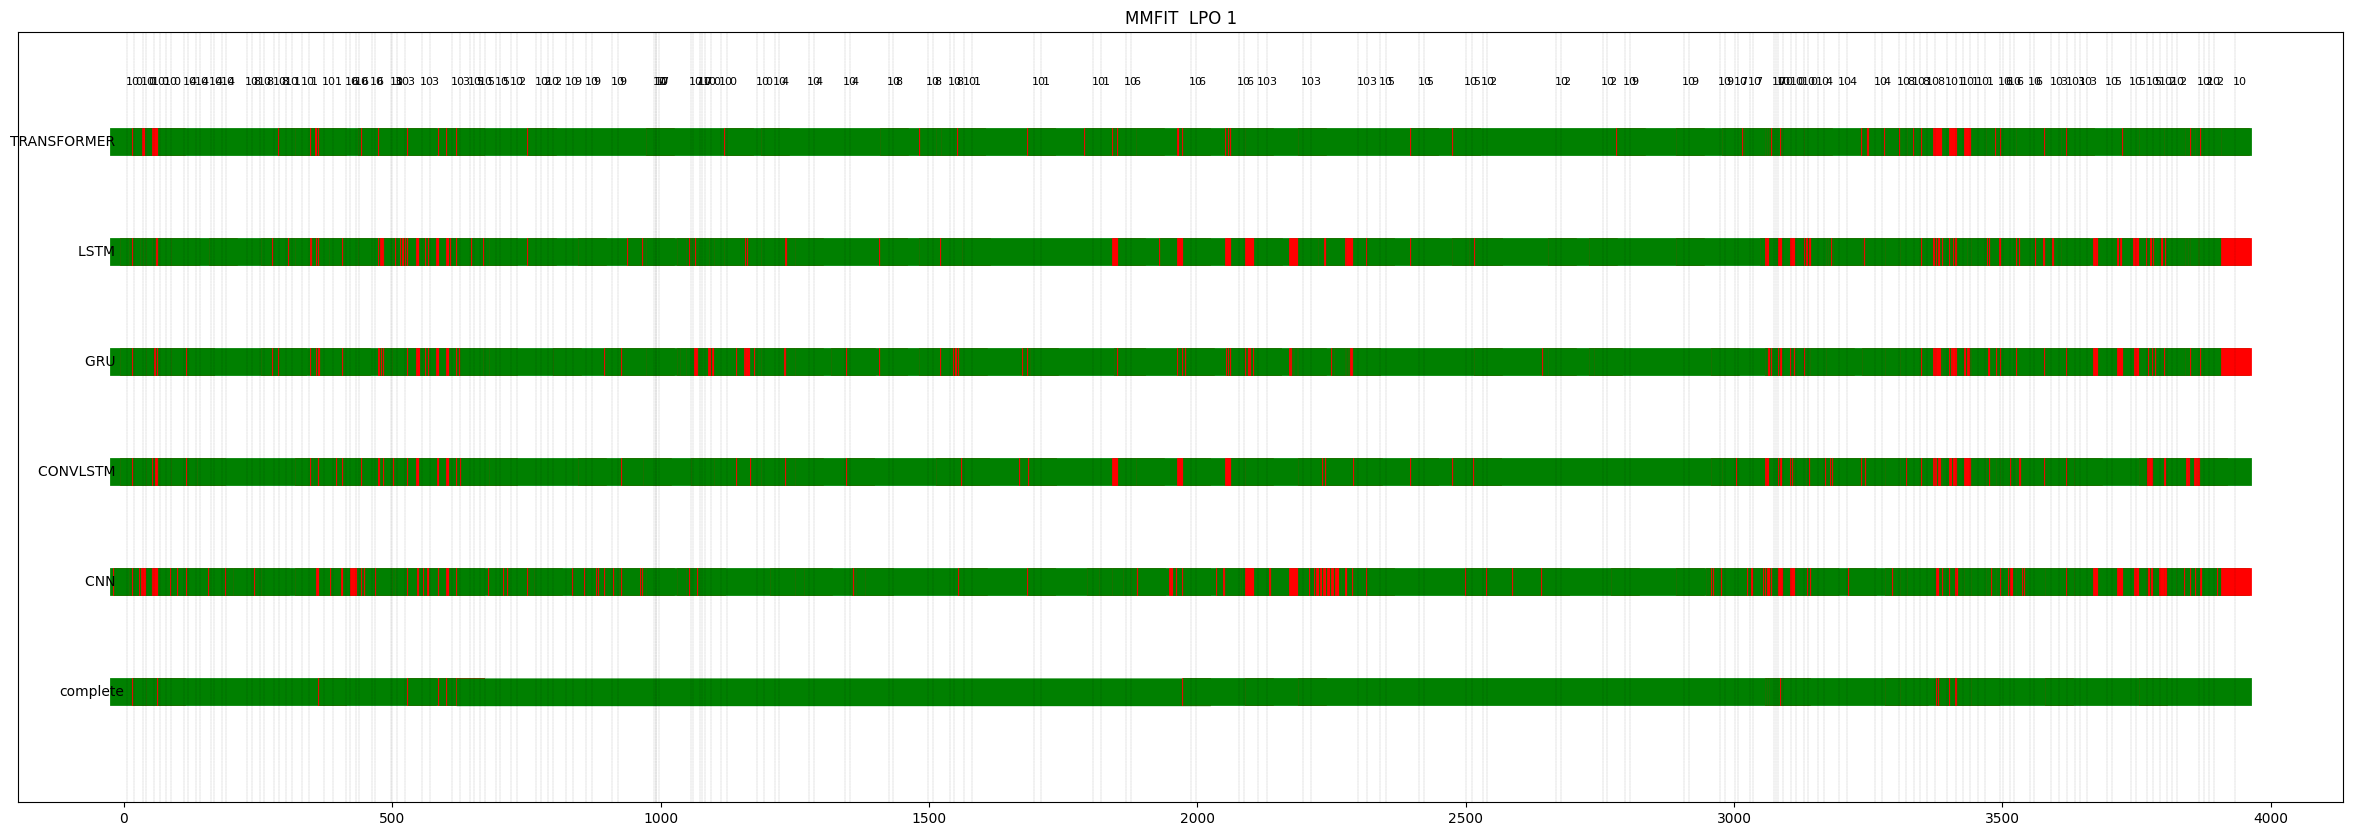

3857


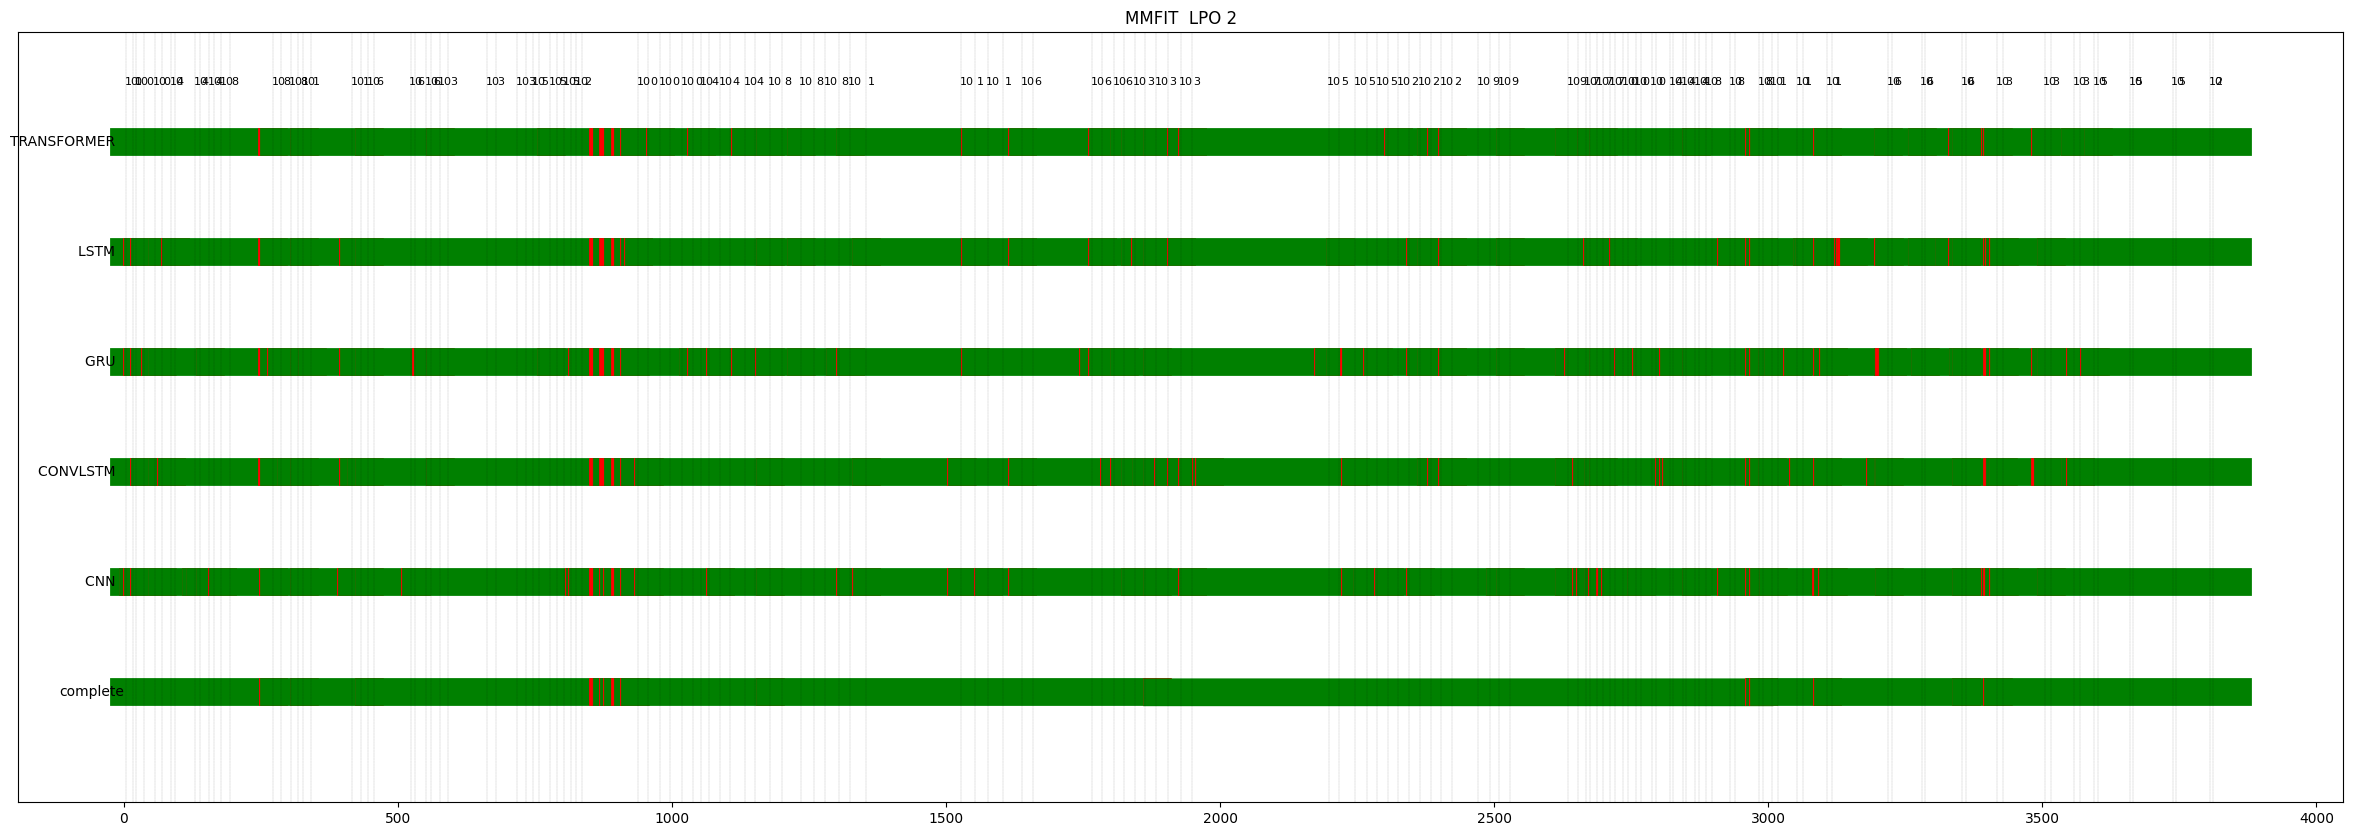

3829


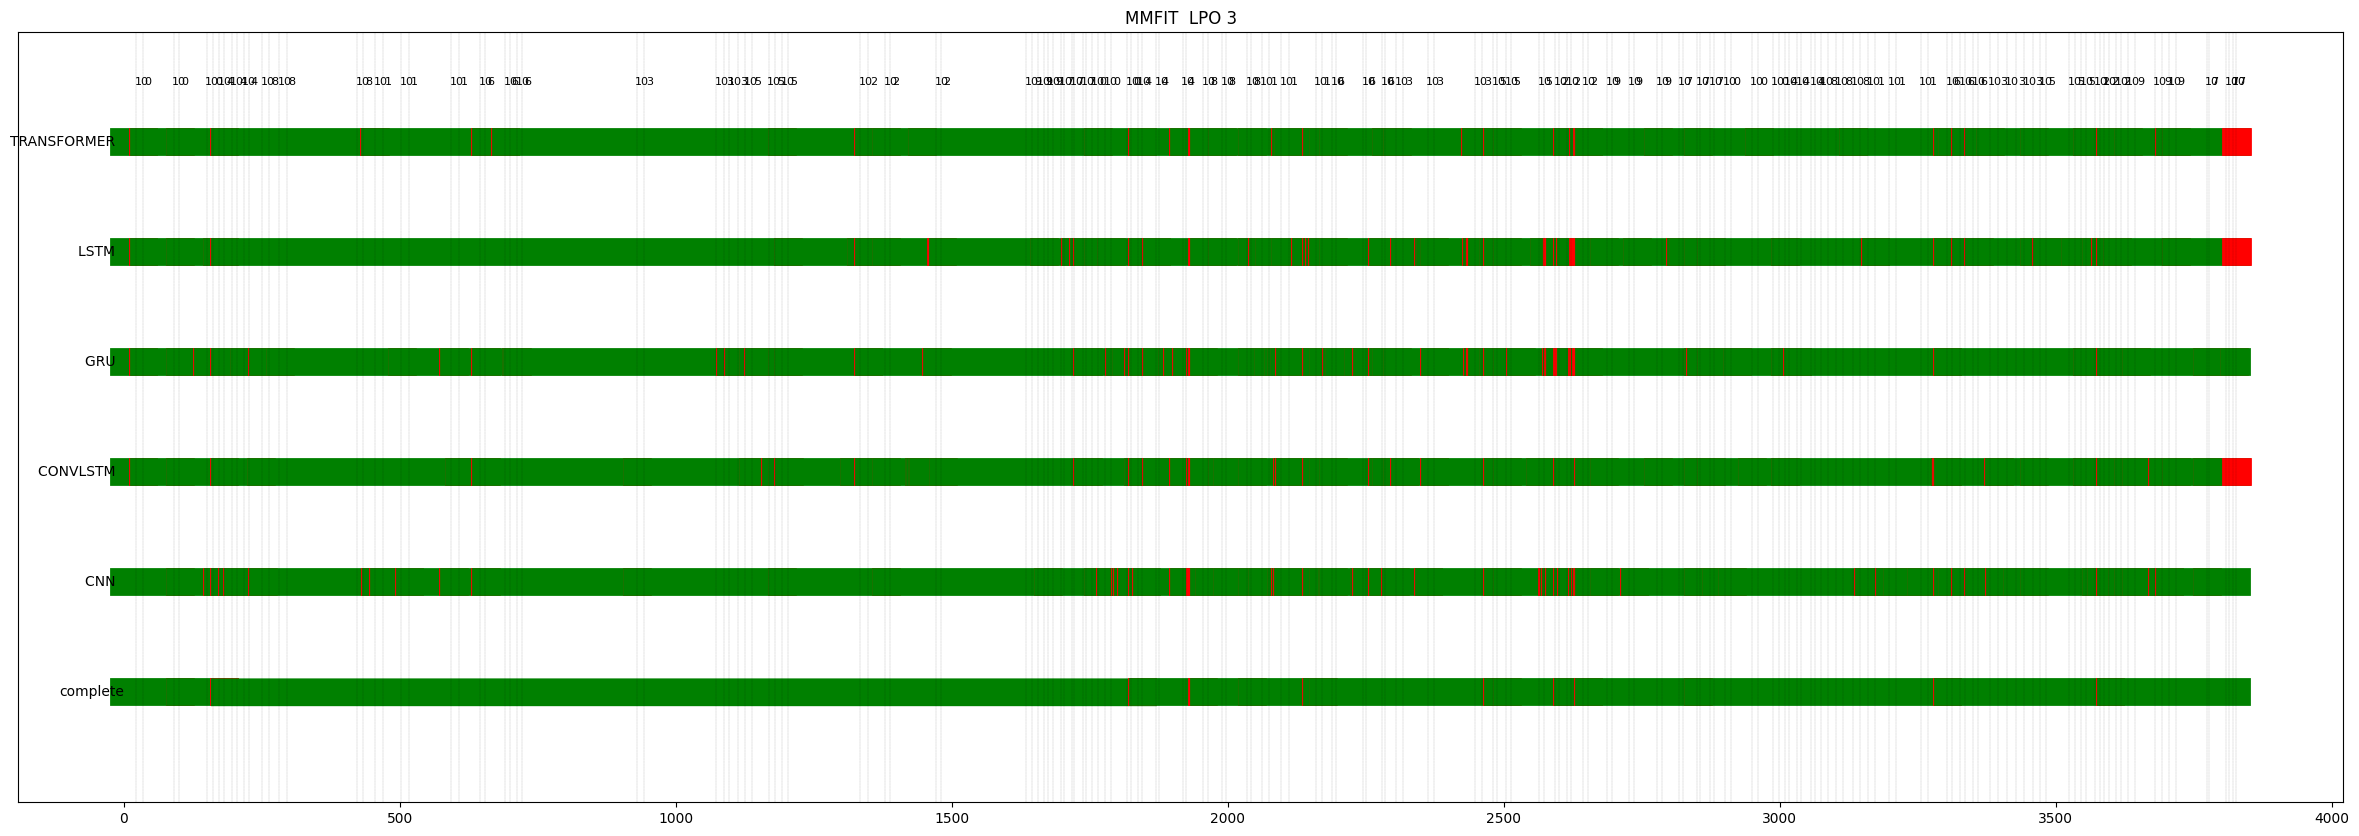

3678


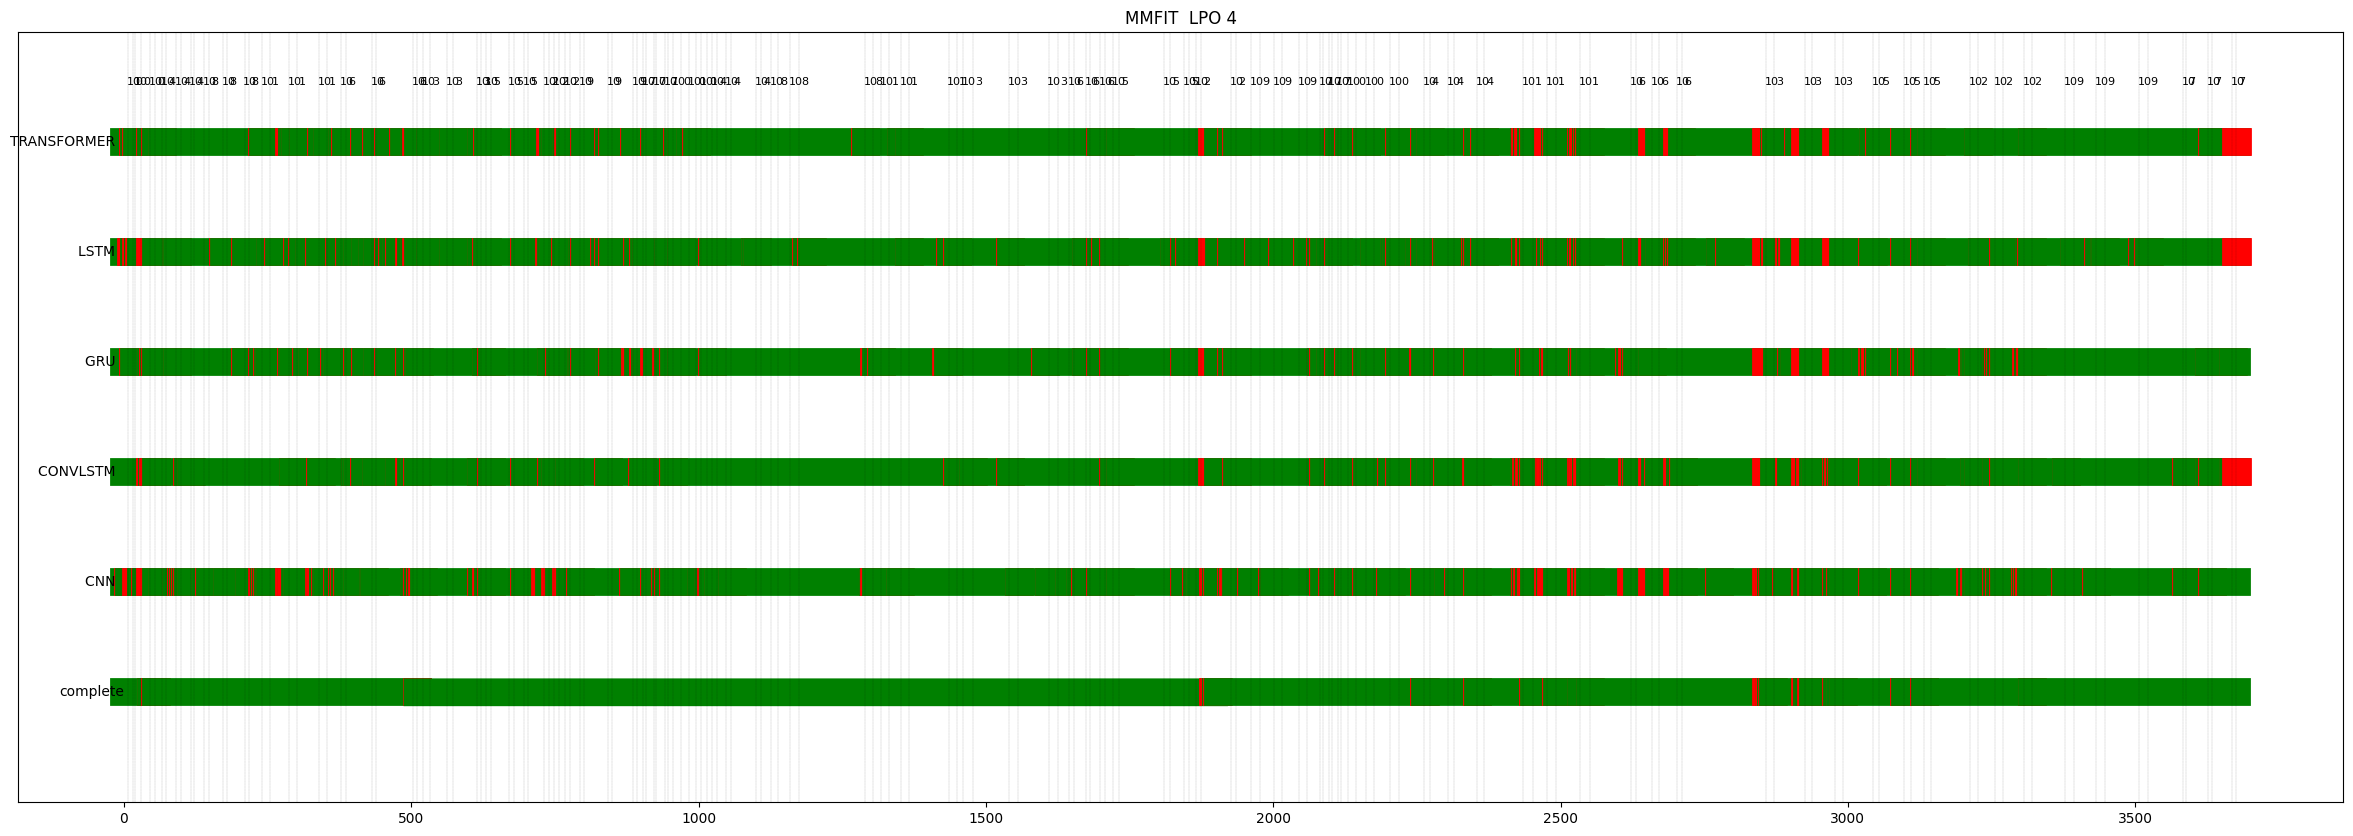

3459


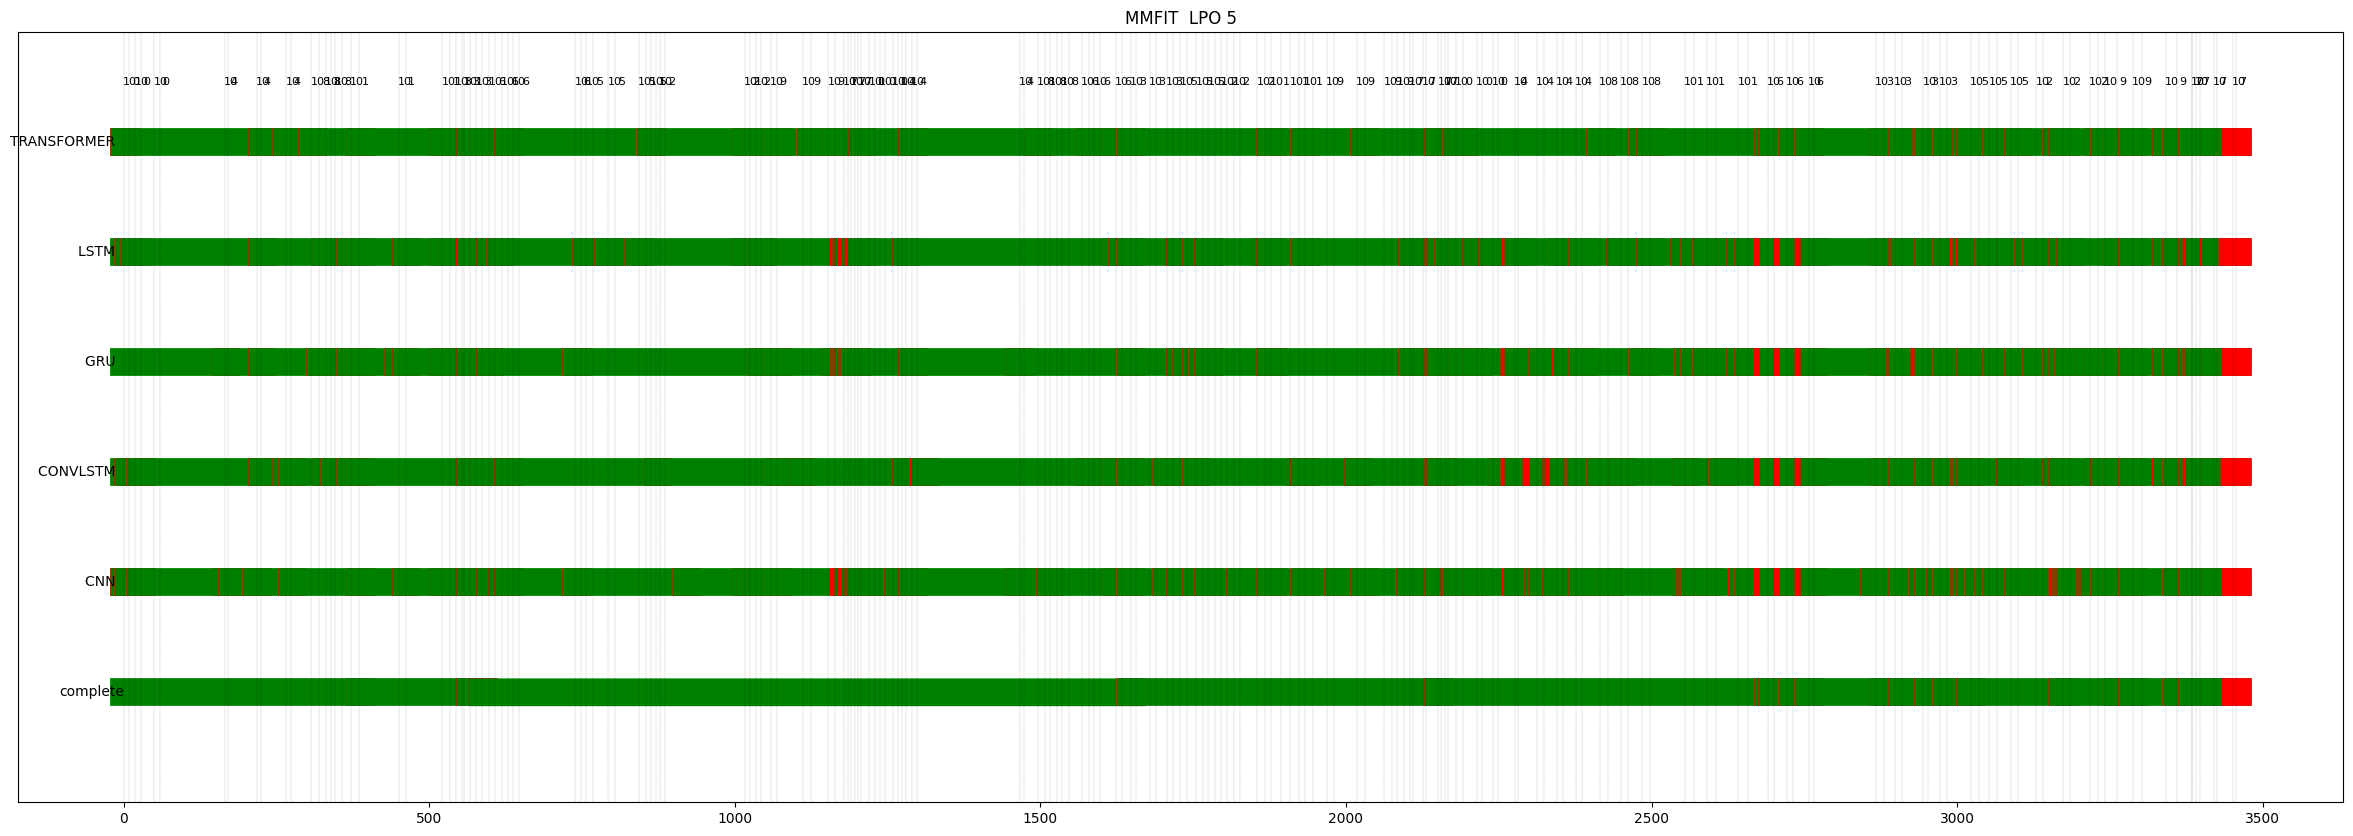

3535


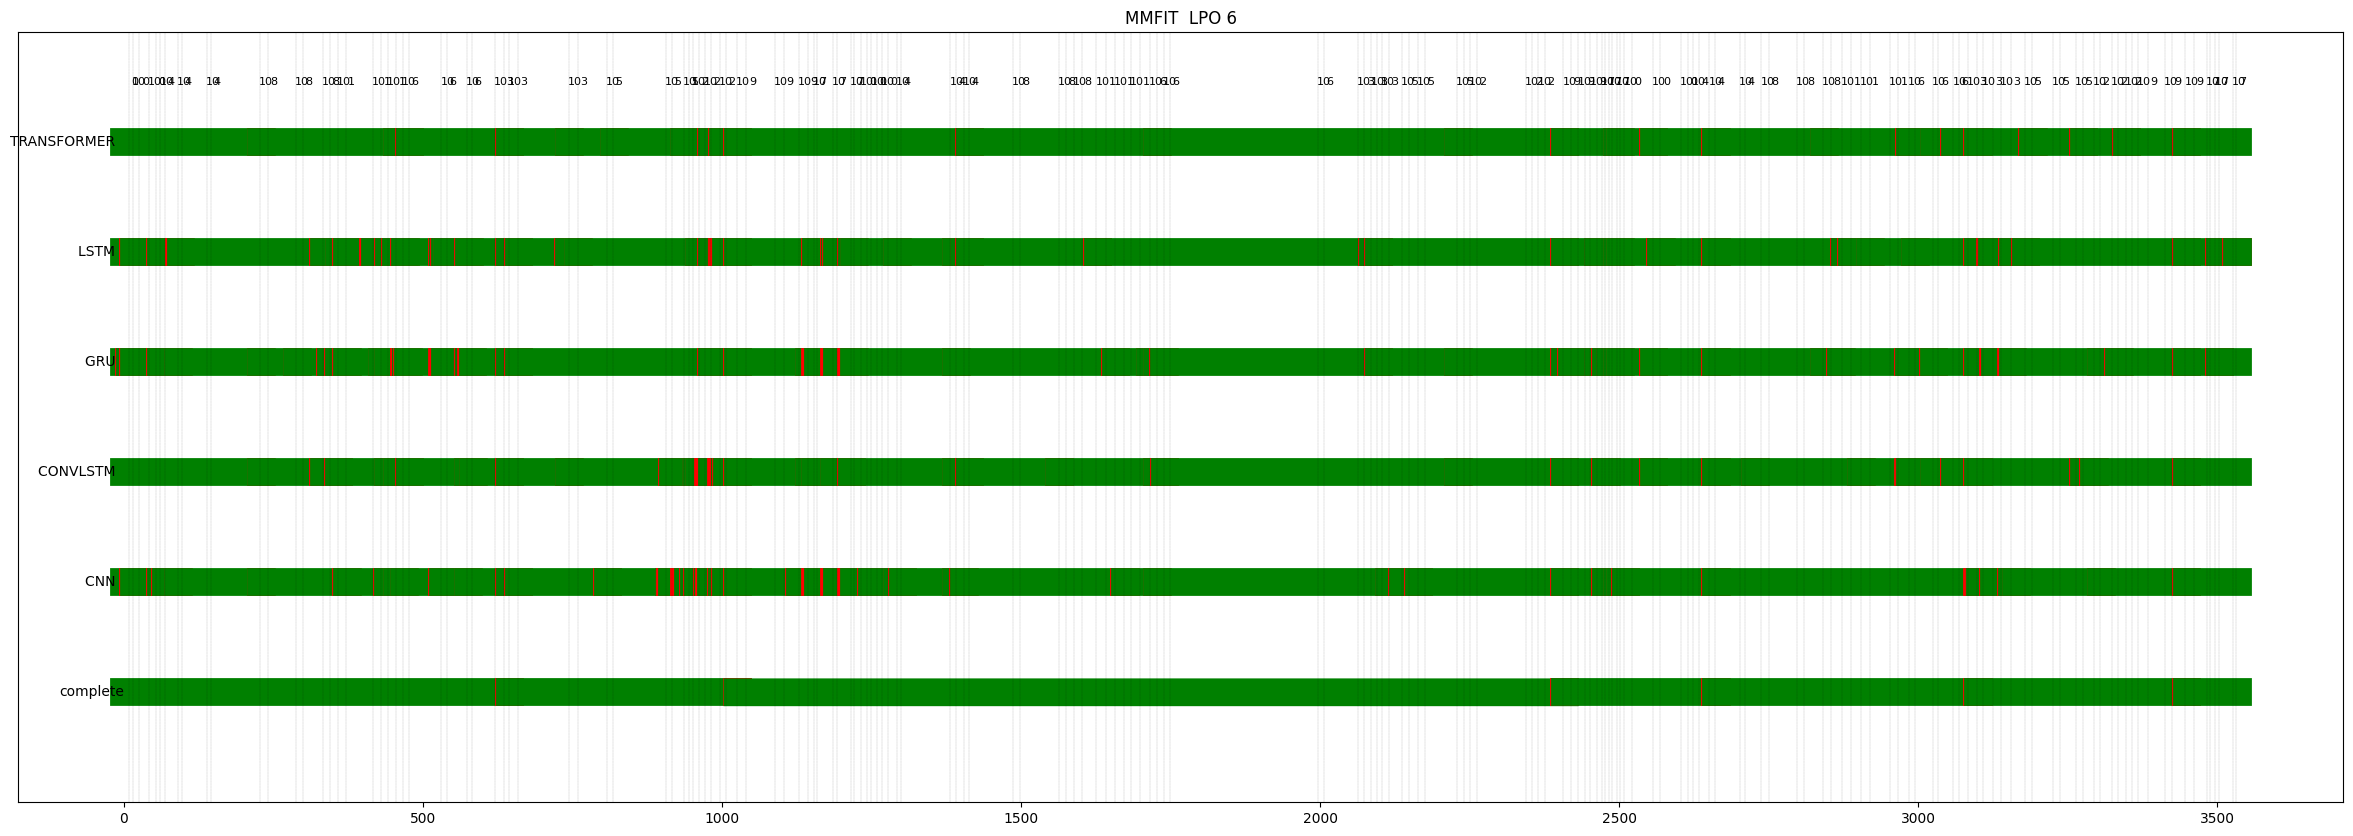

1611


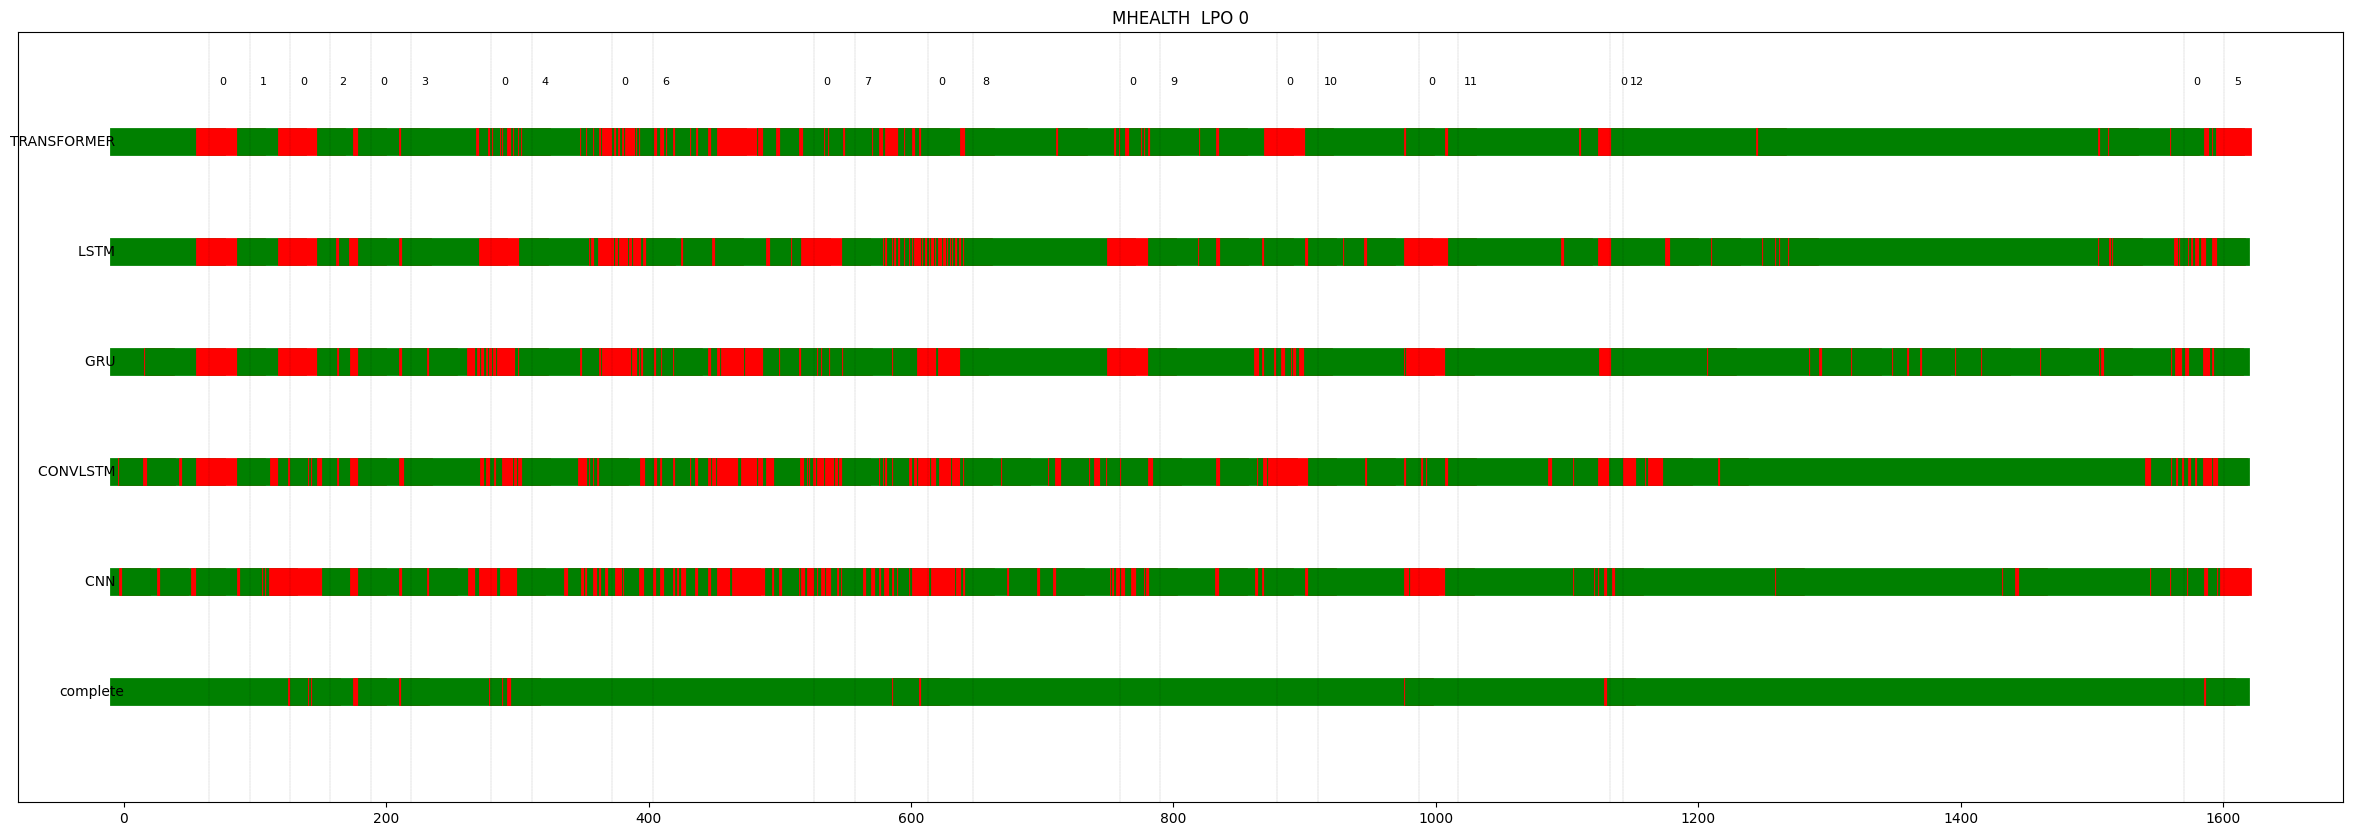

1350


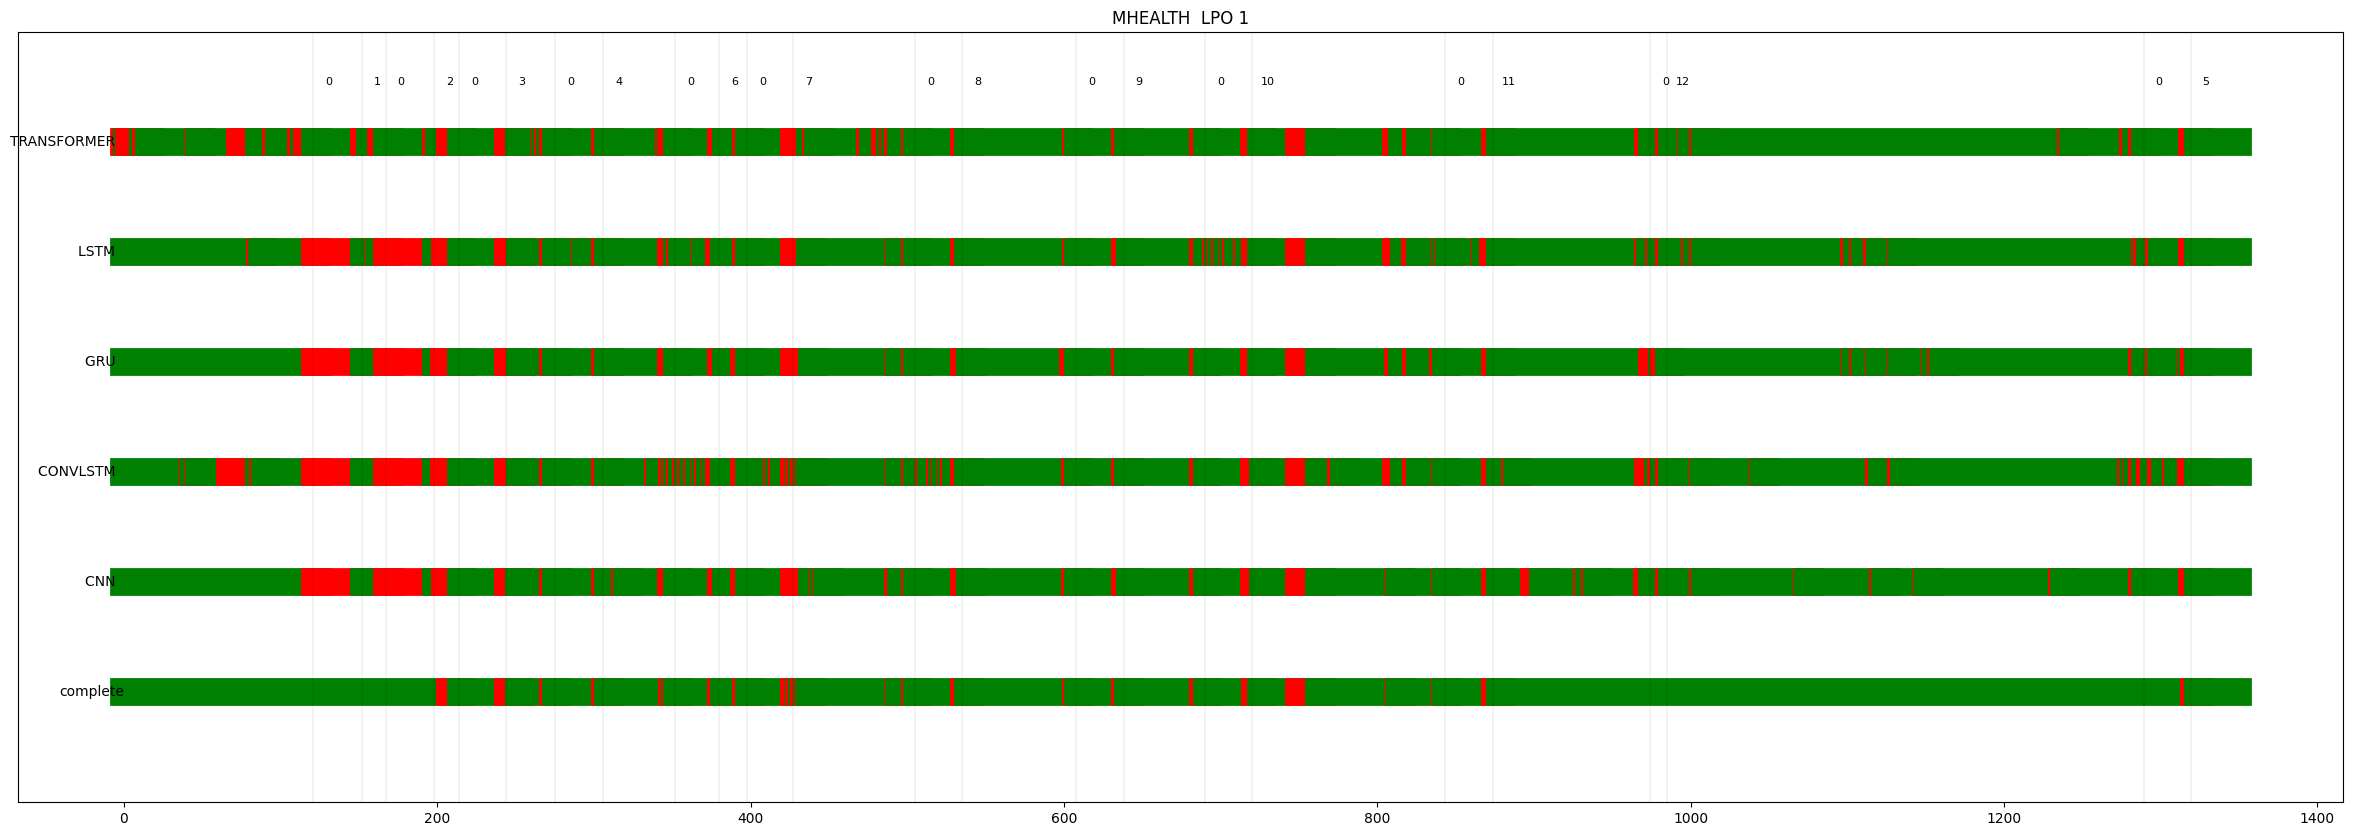

1304


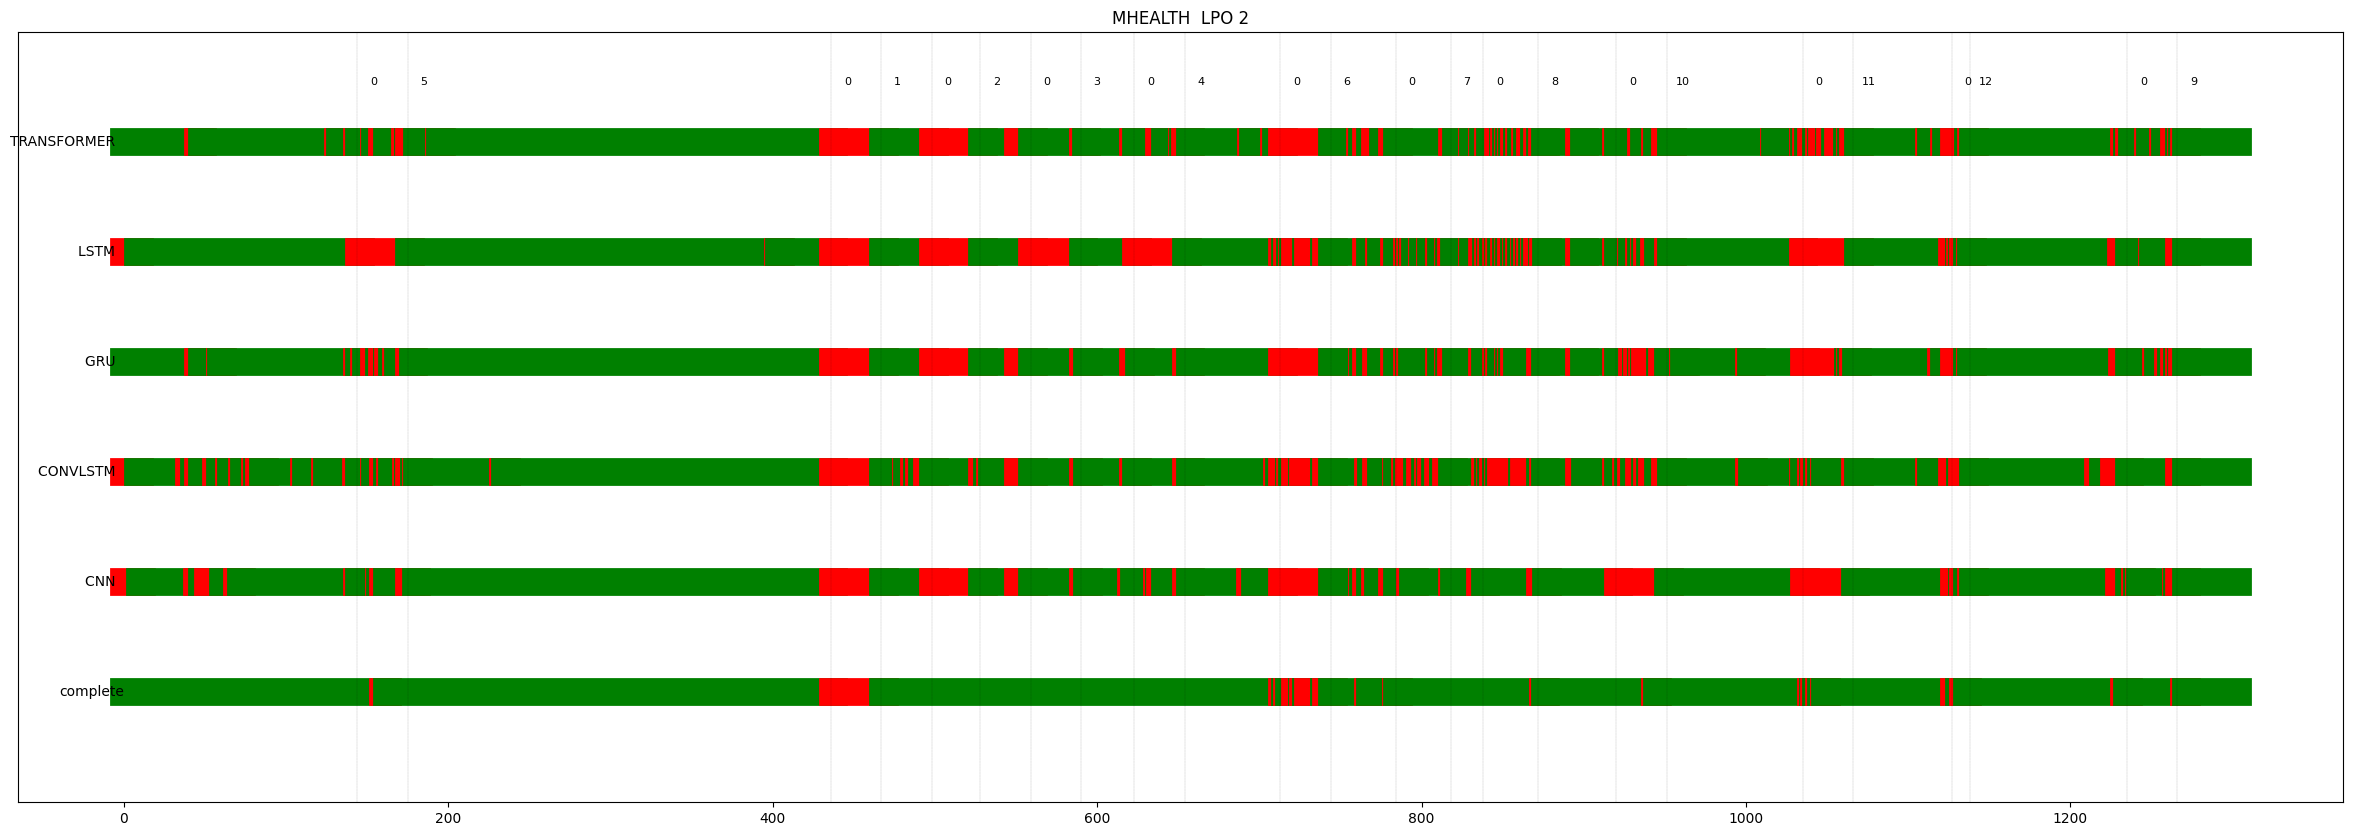

1289


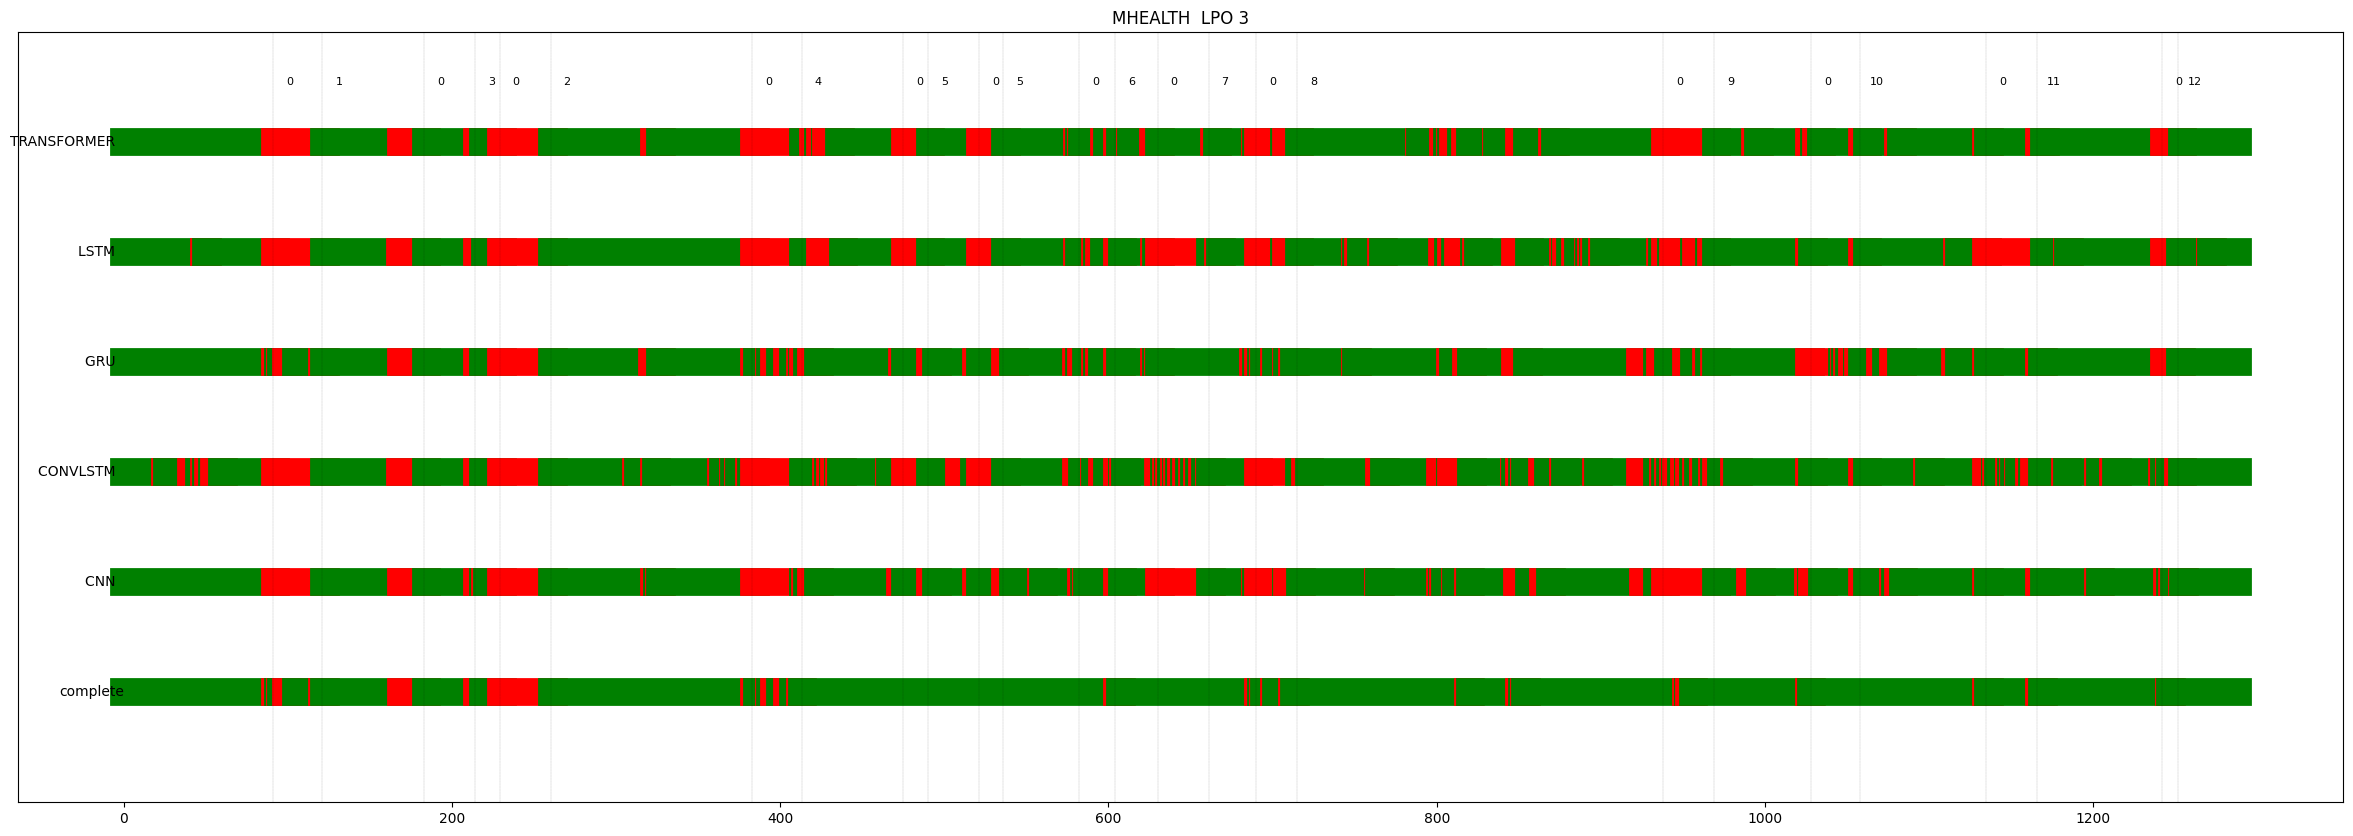

1220


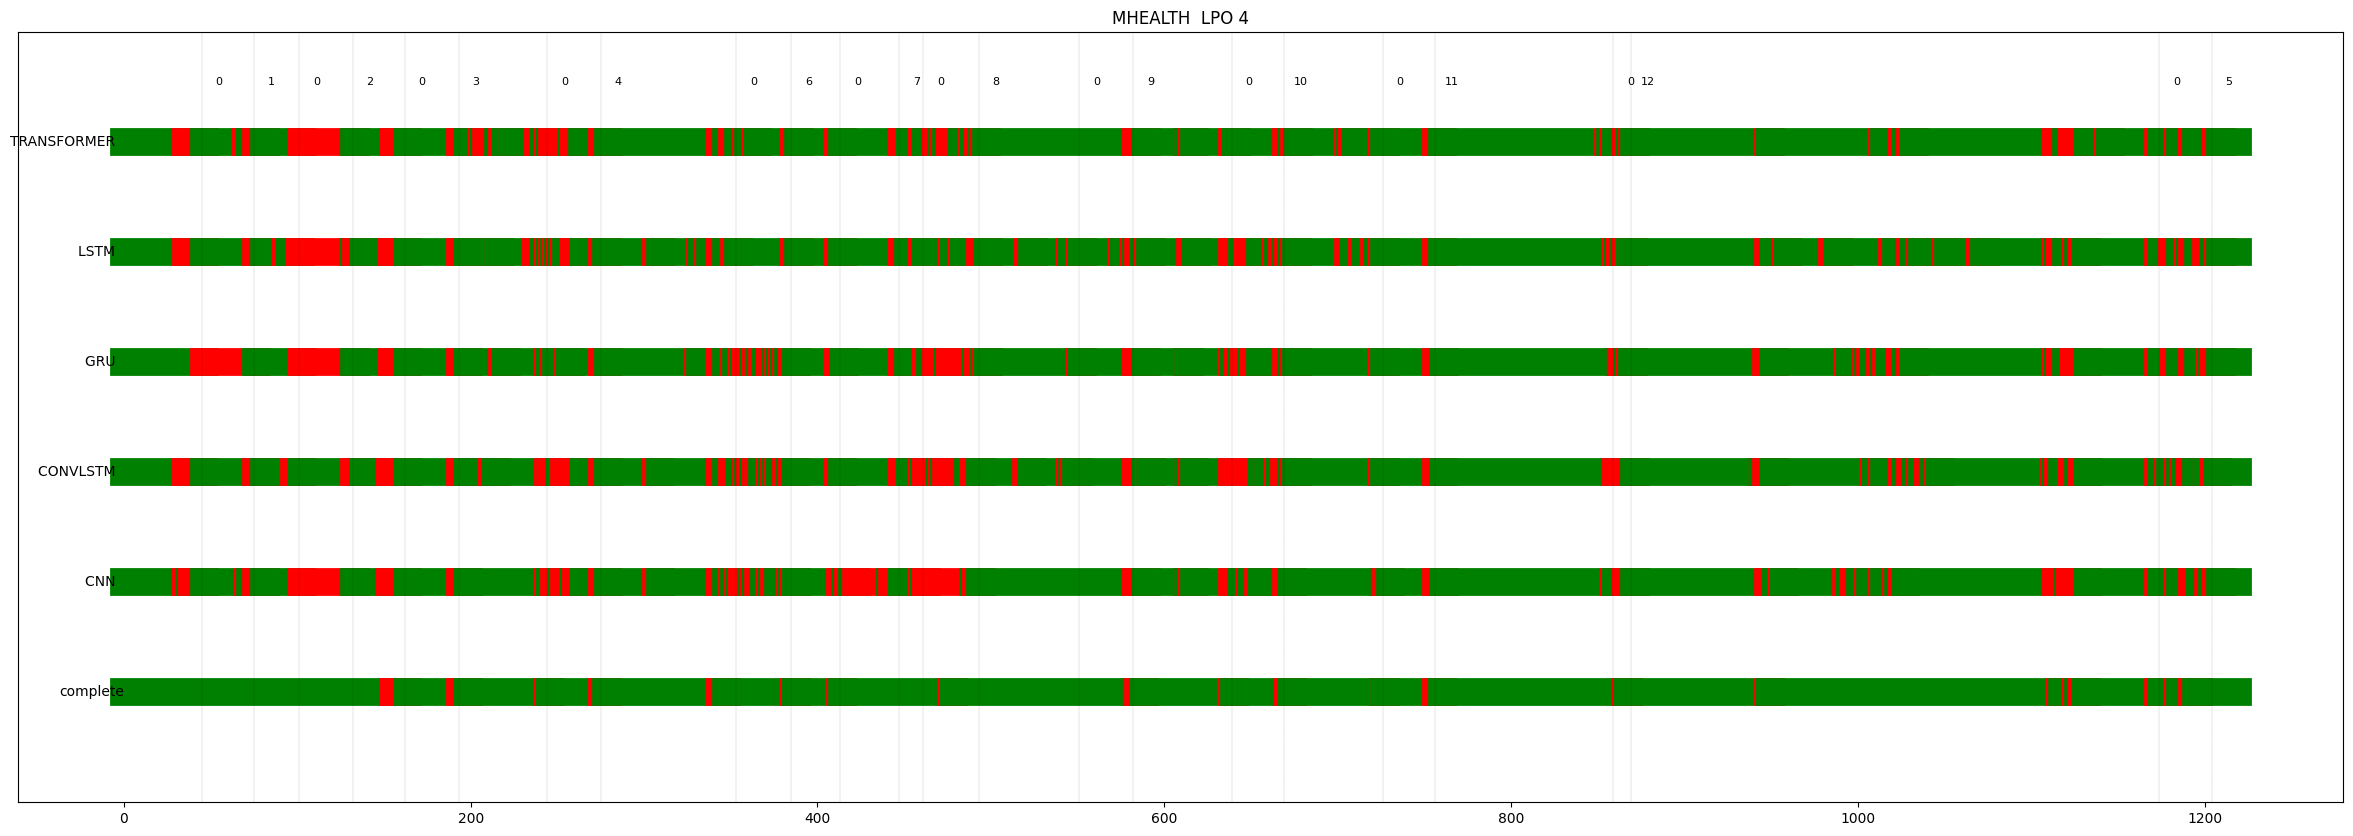

1197


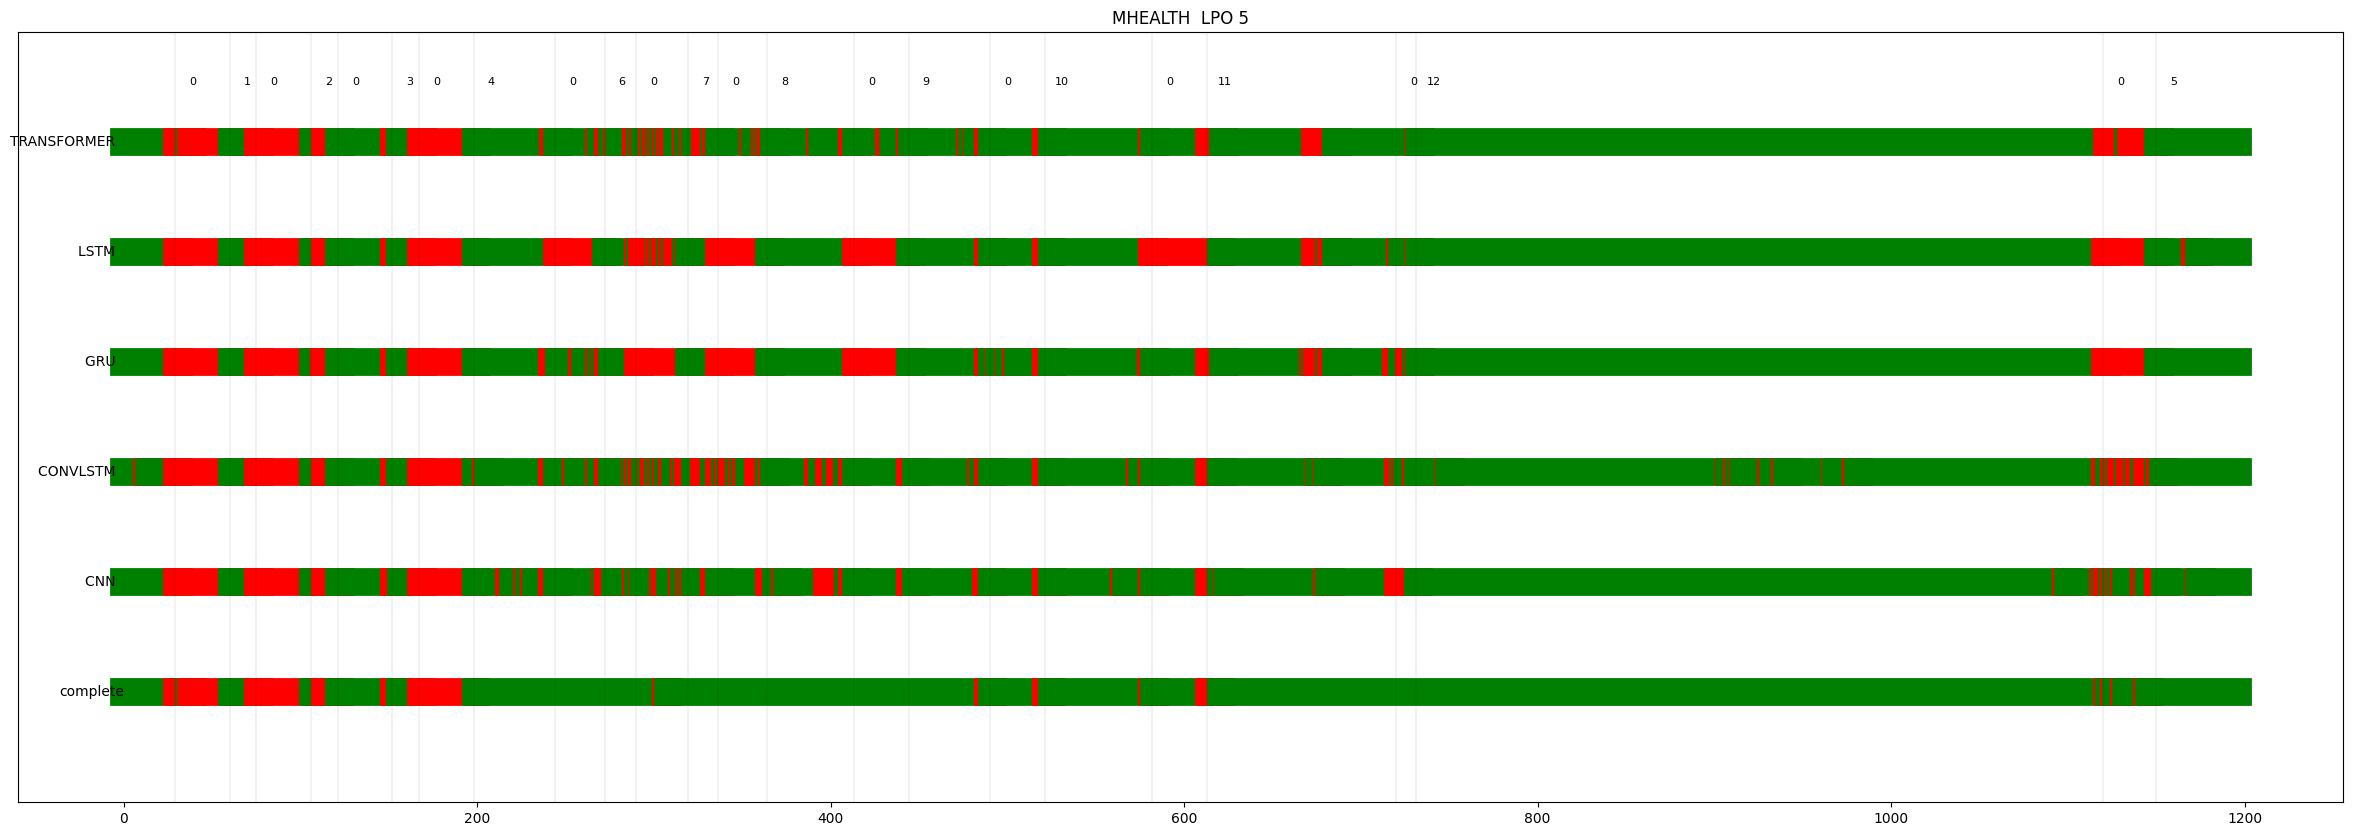

1166


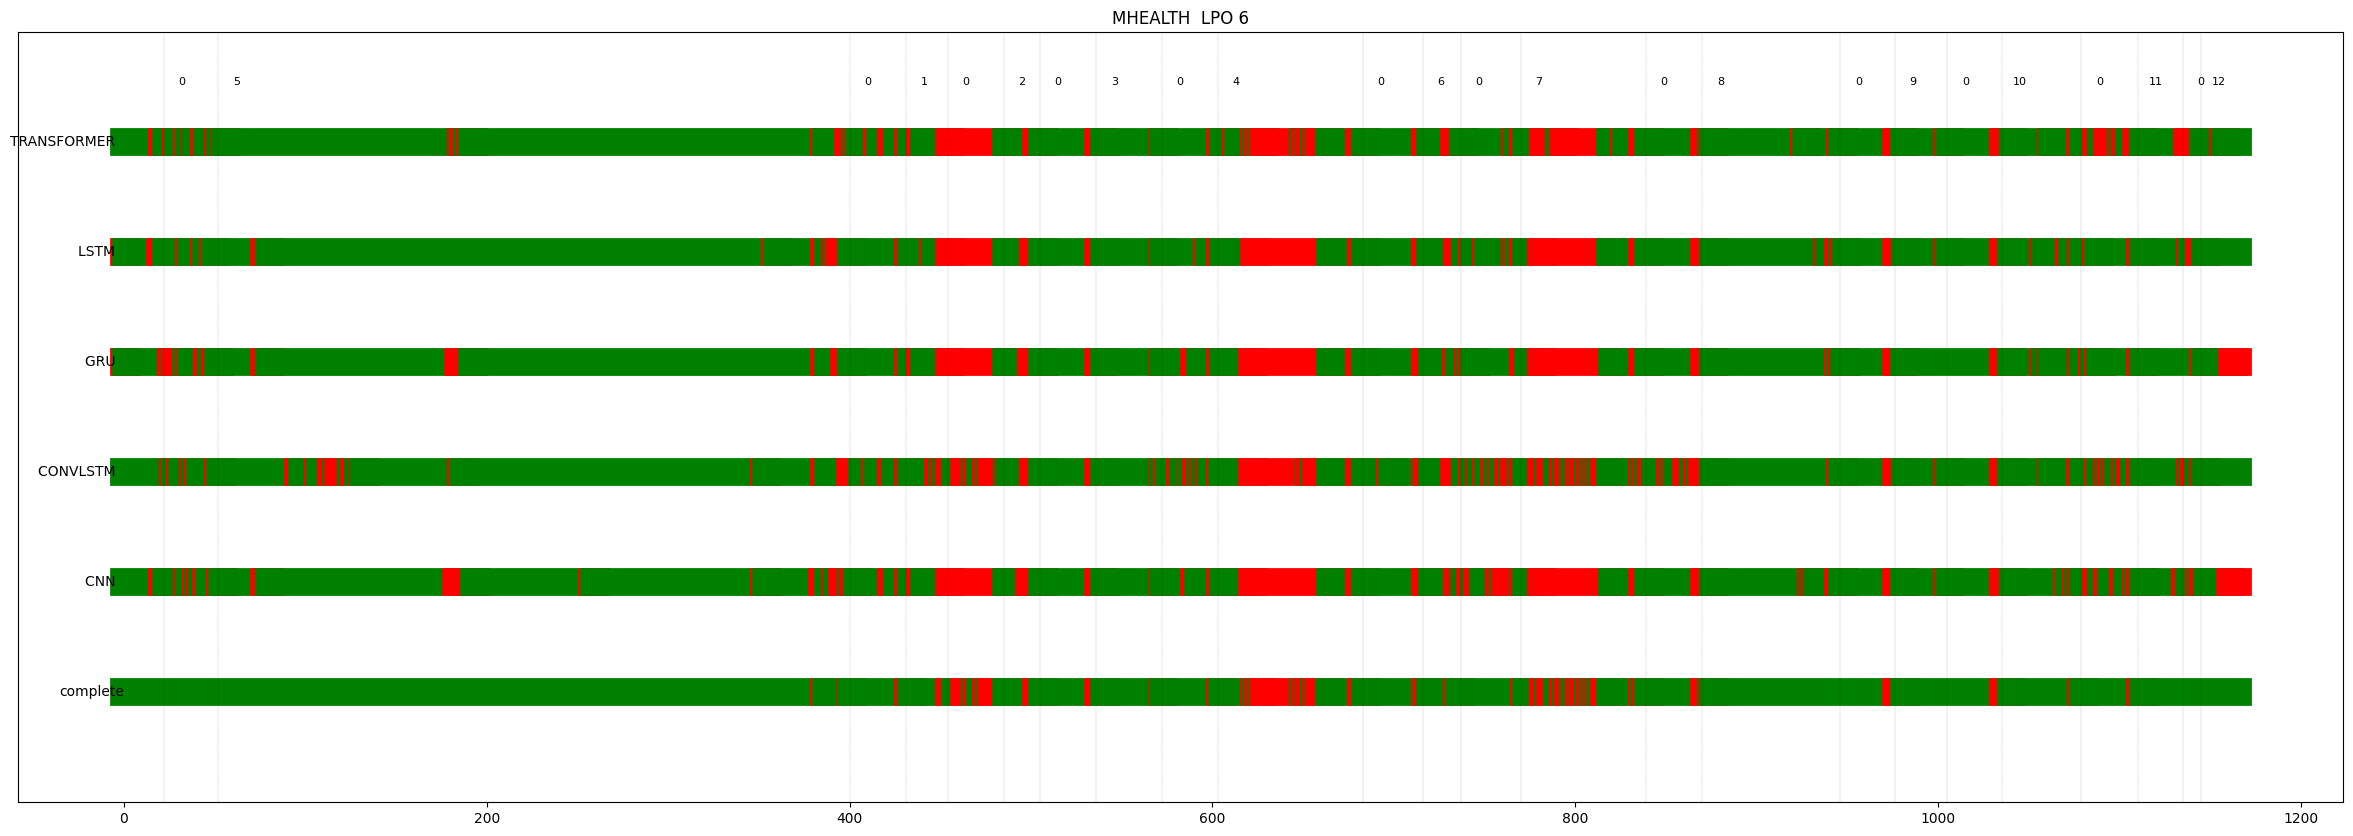

1043


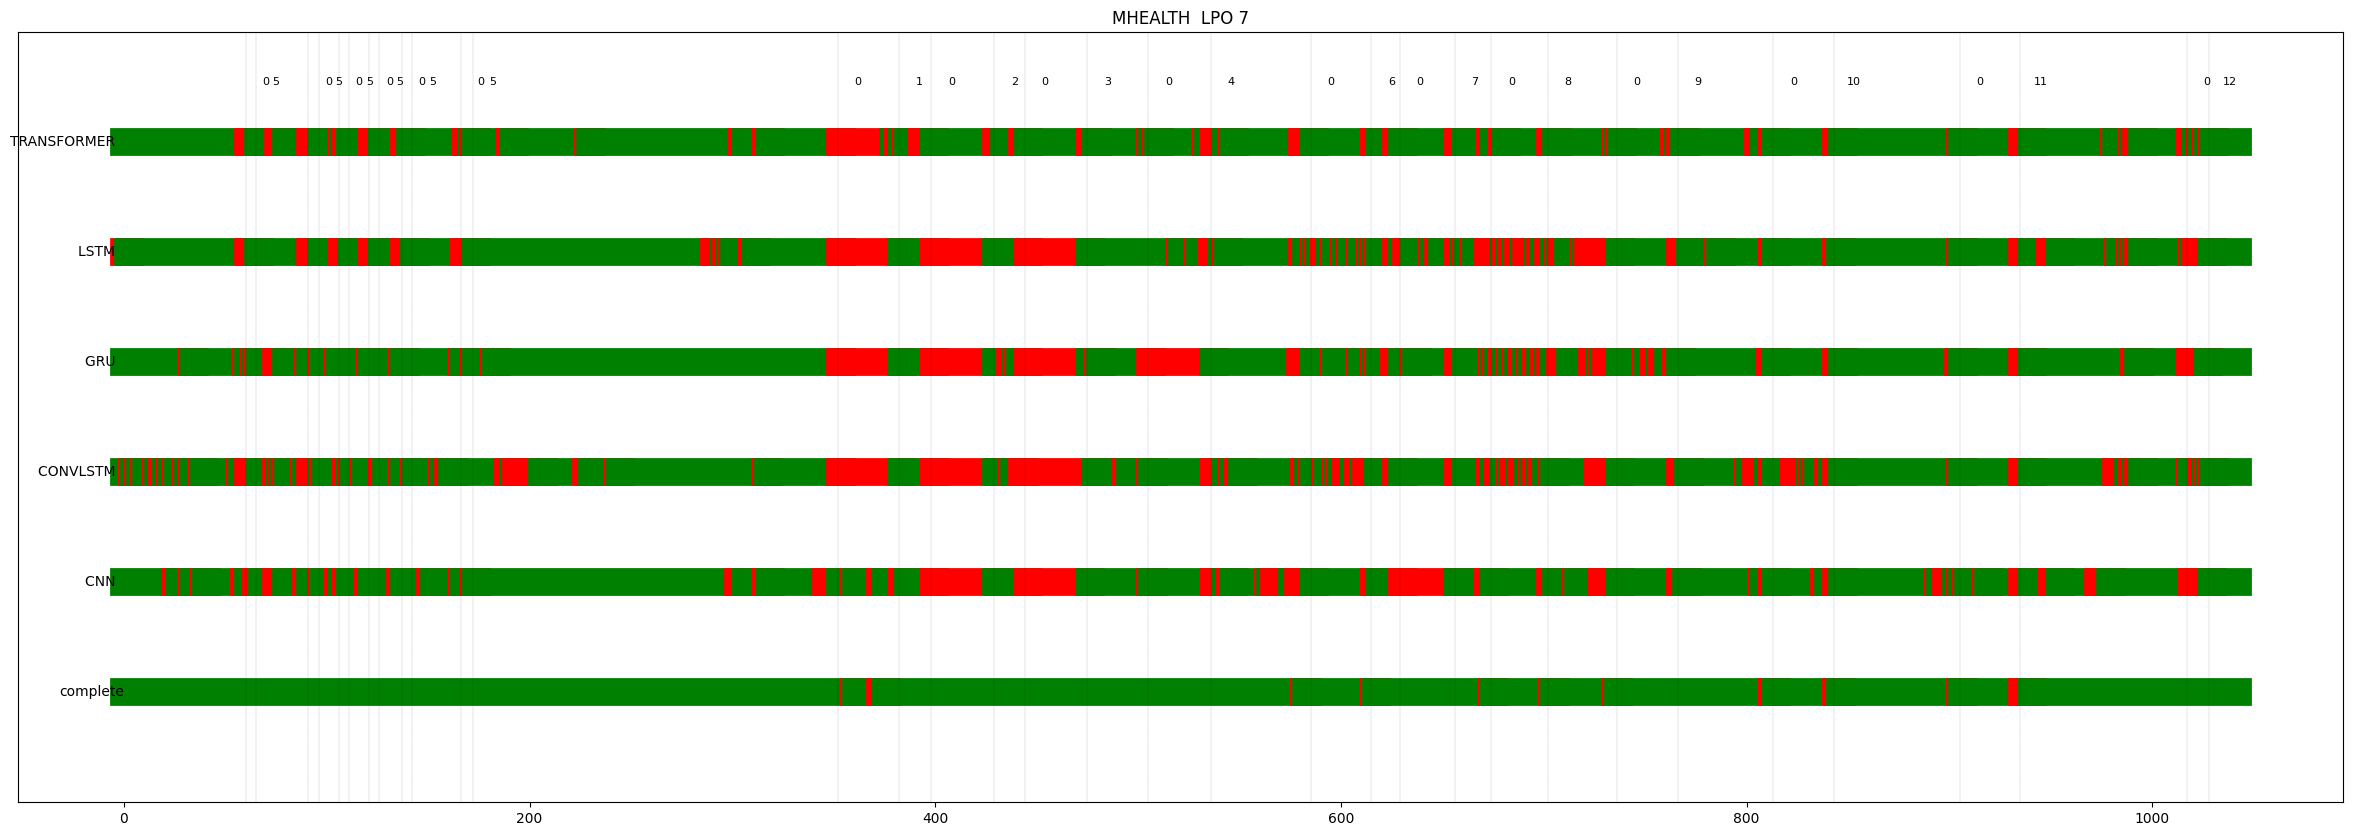

982


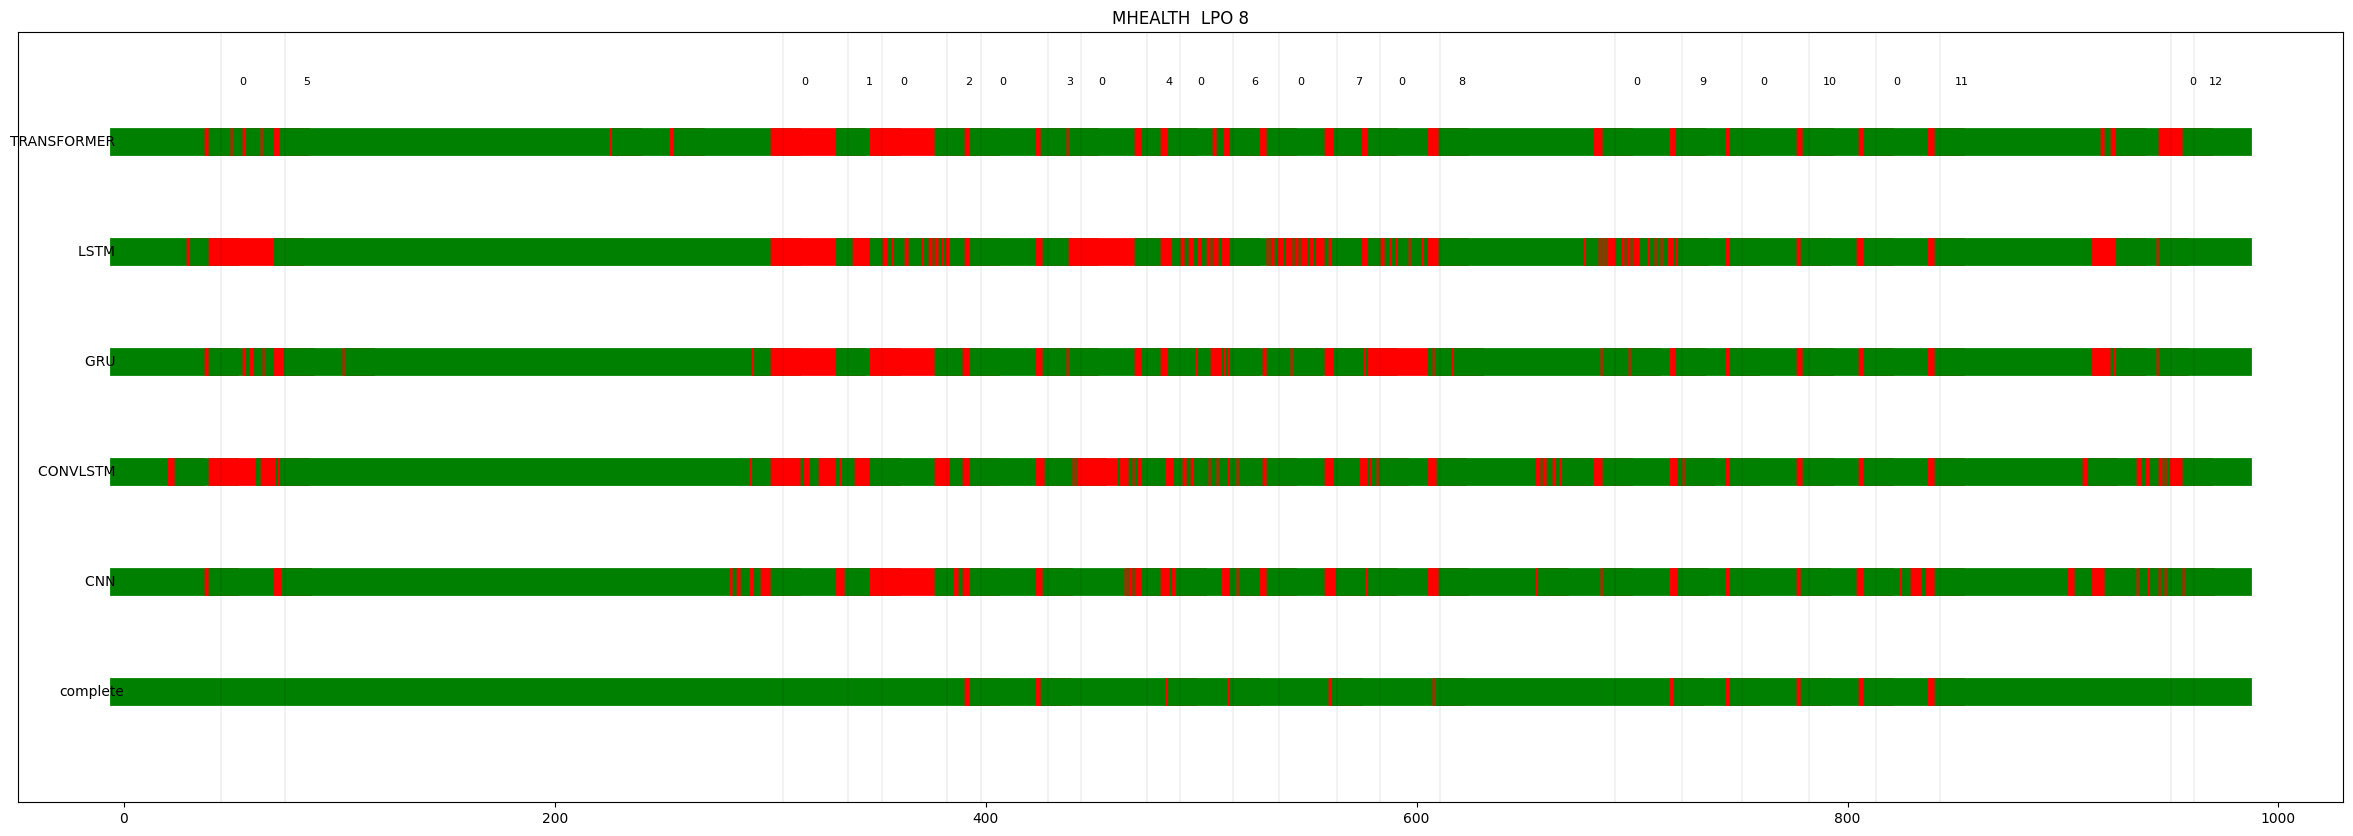

982


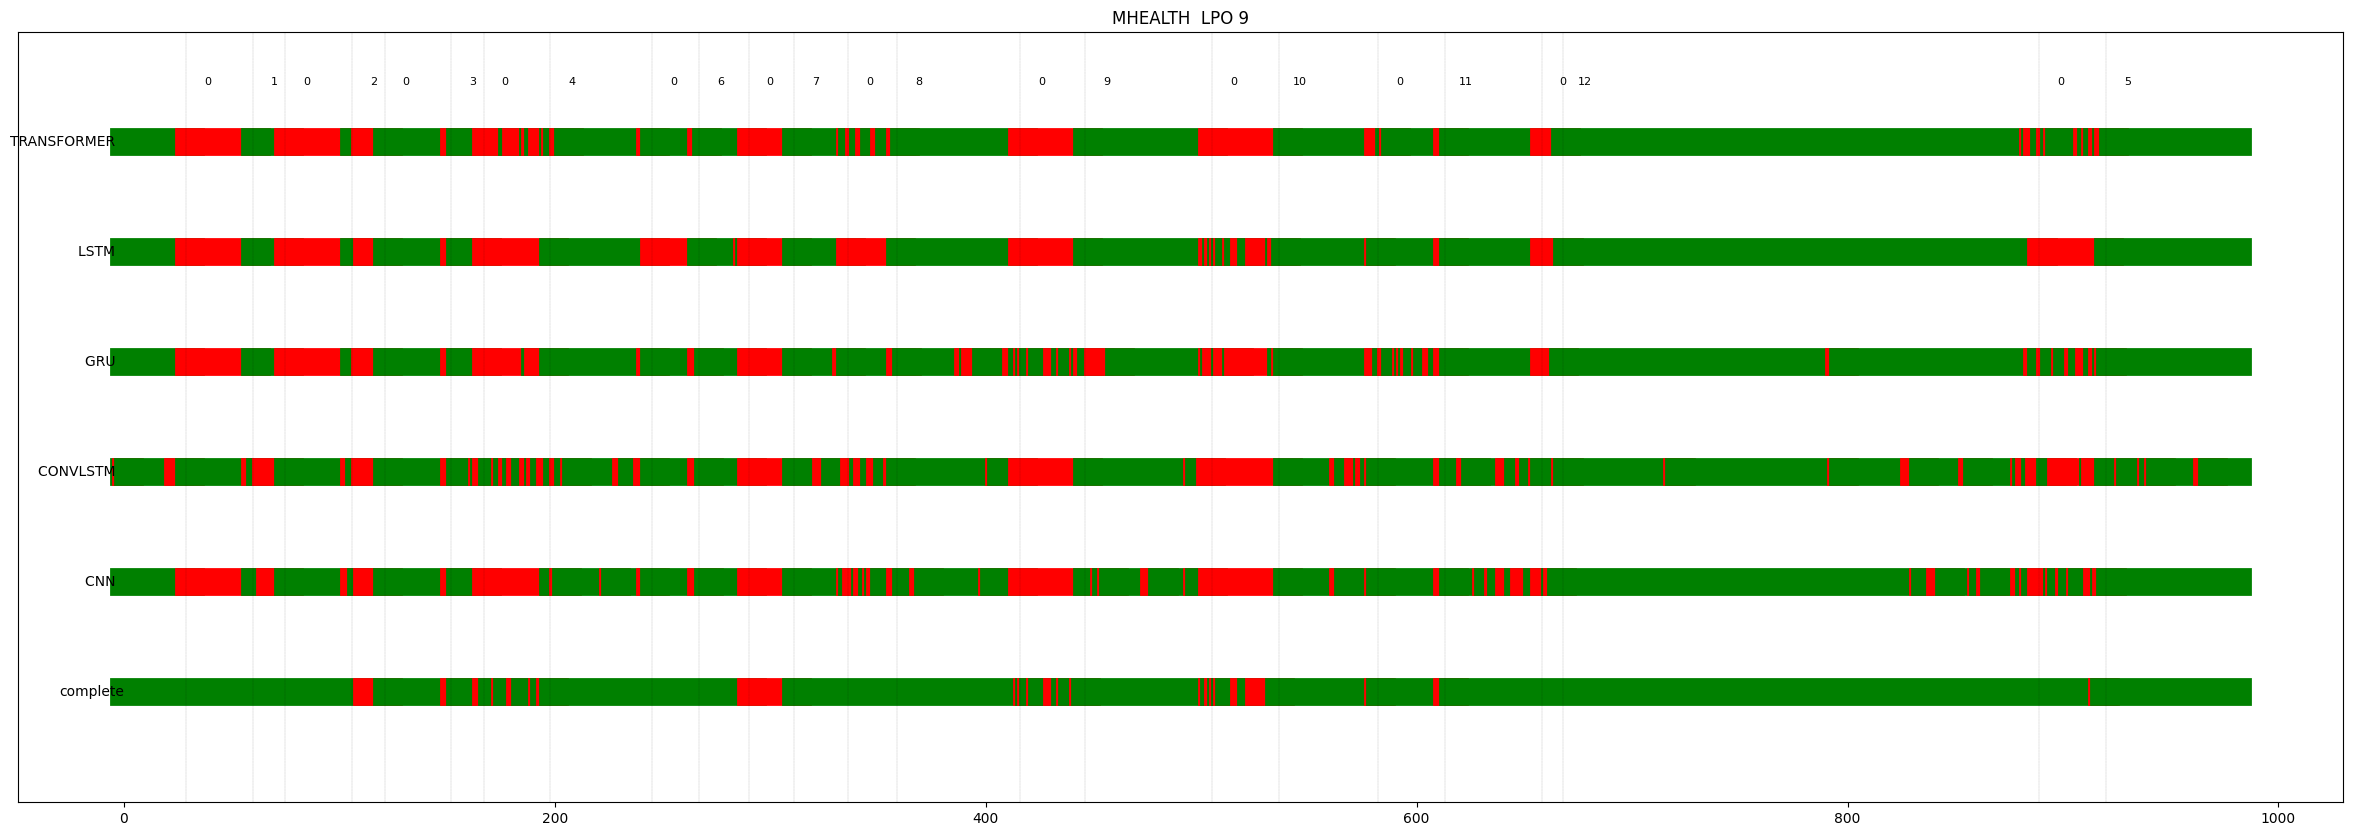

2405


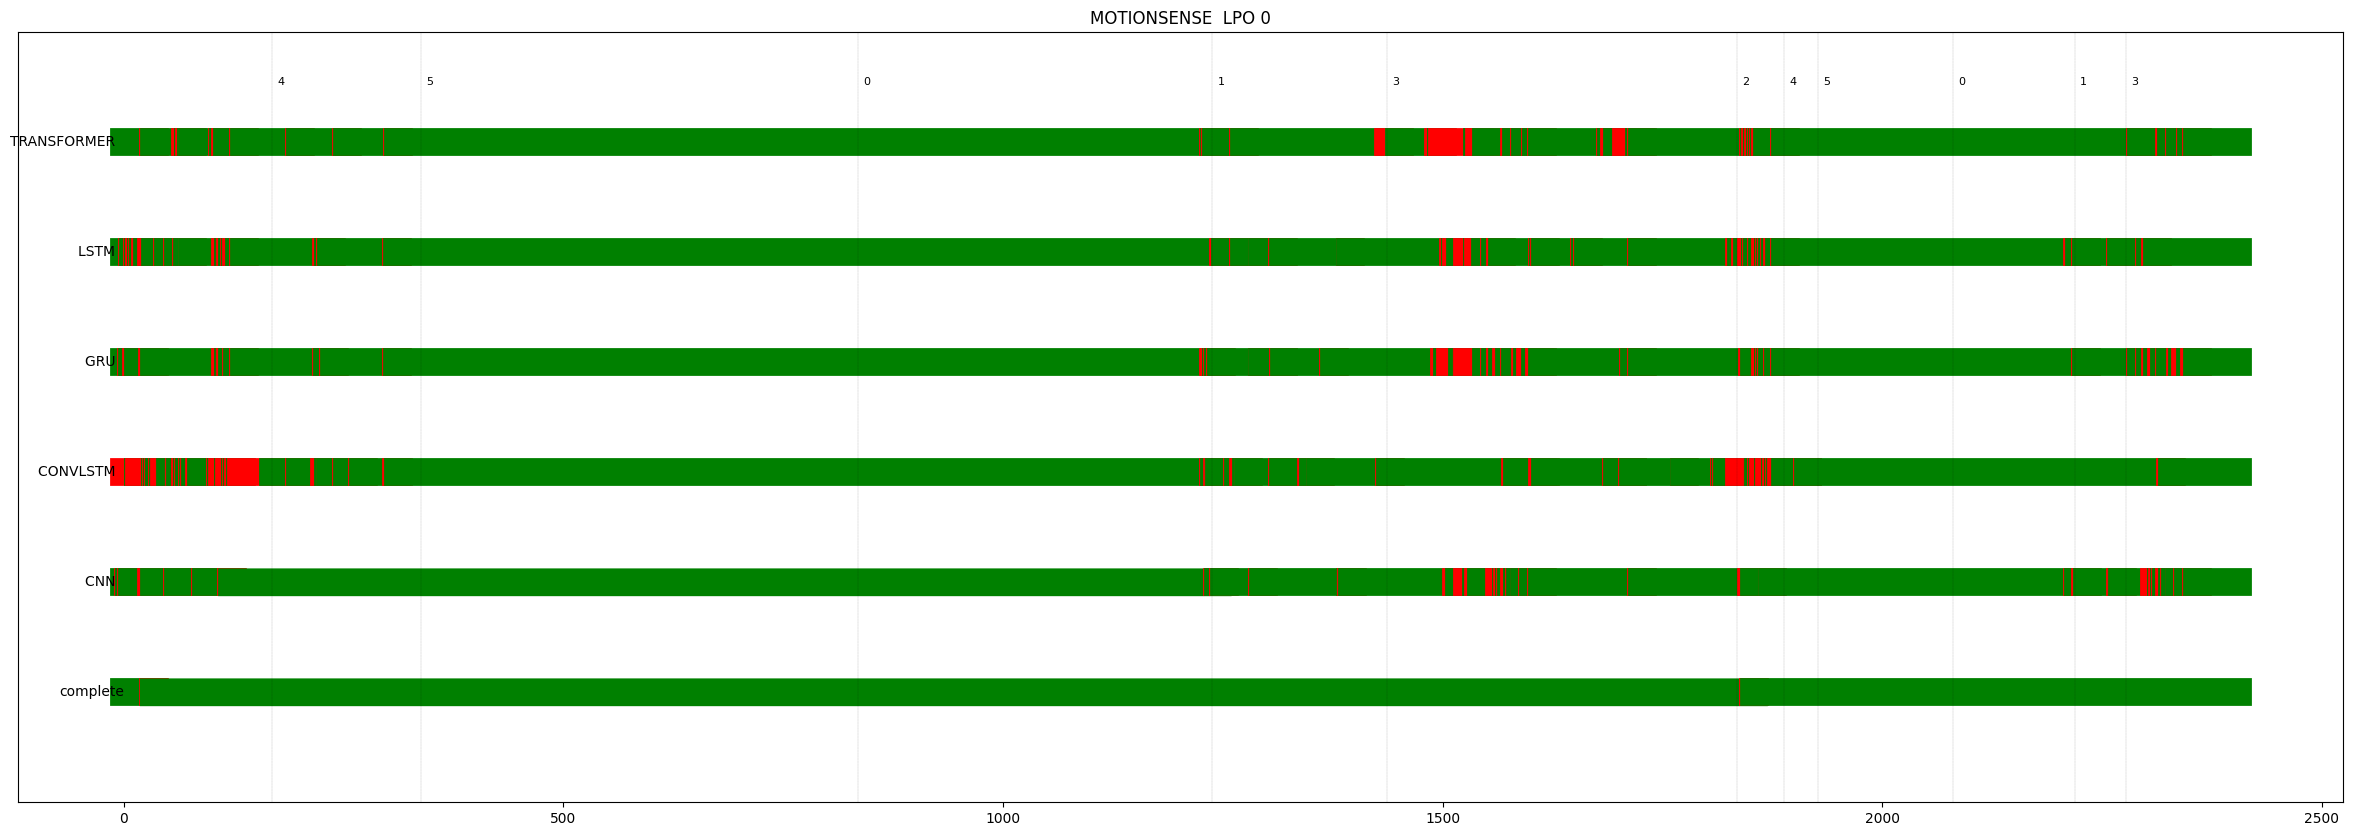

2714


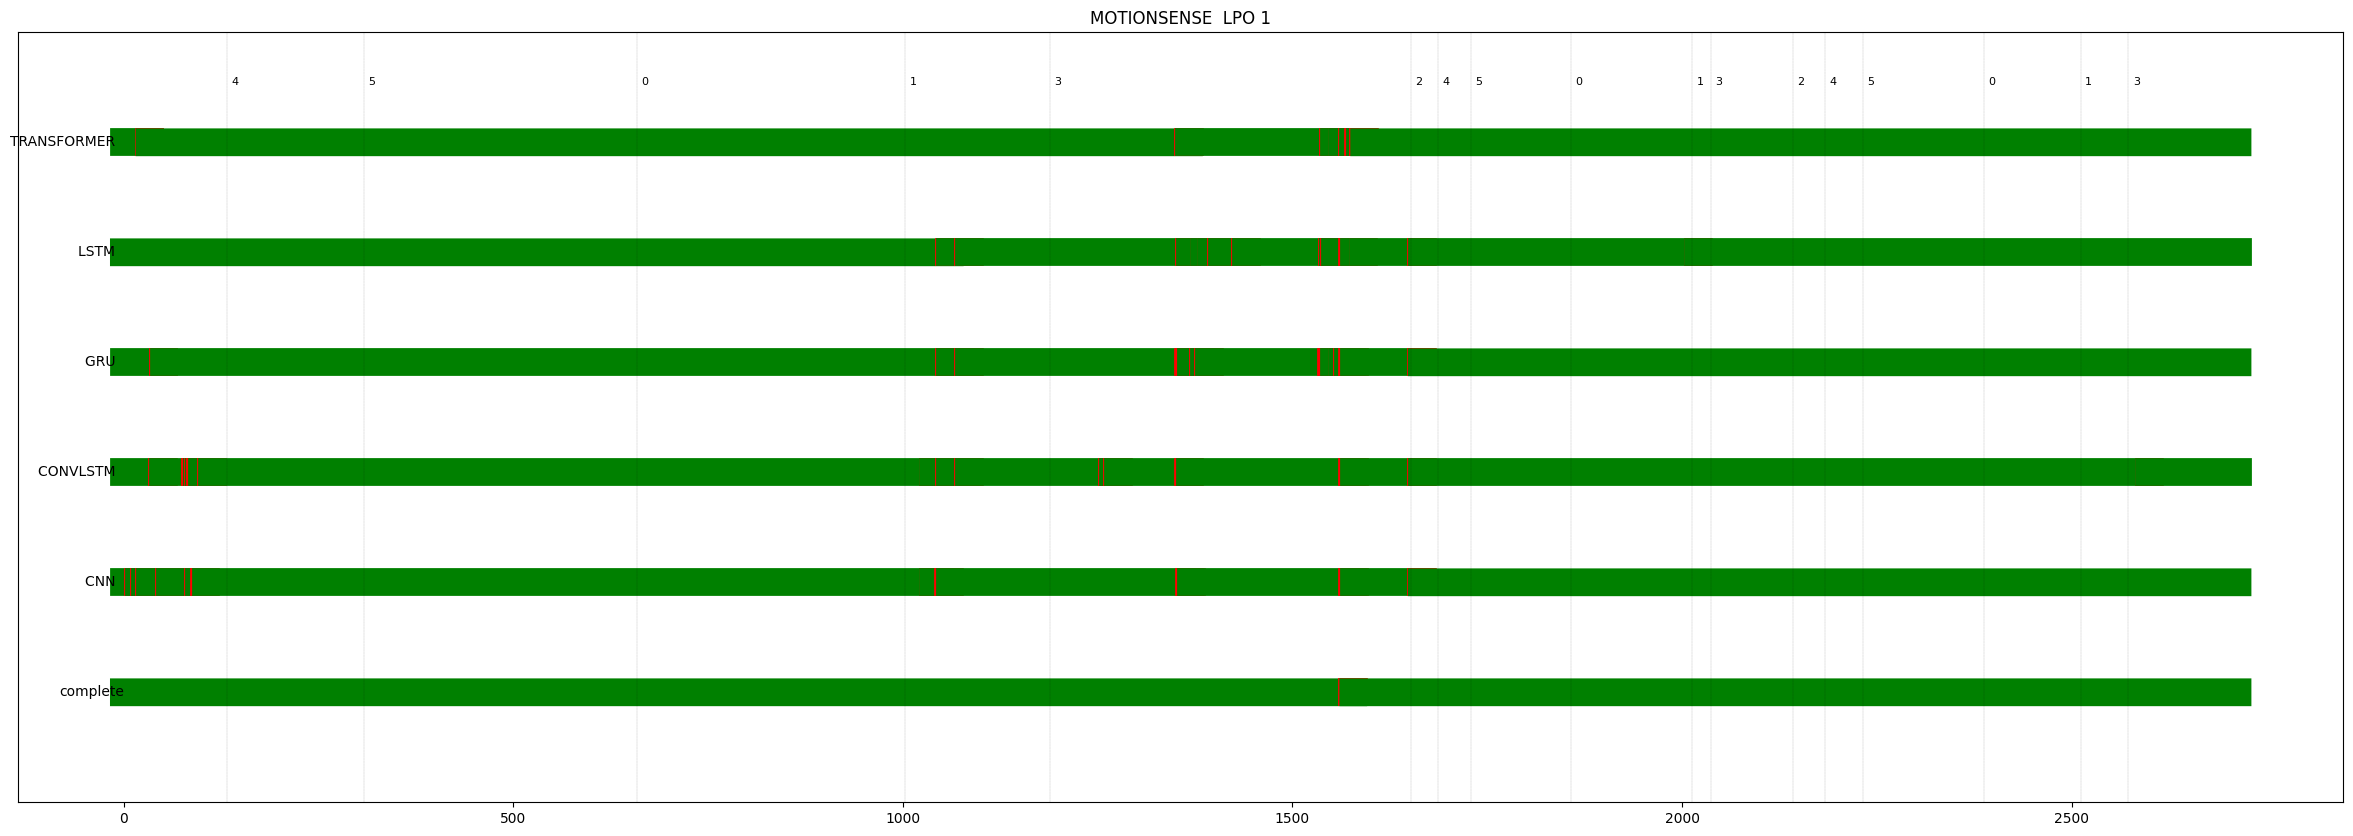

2718


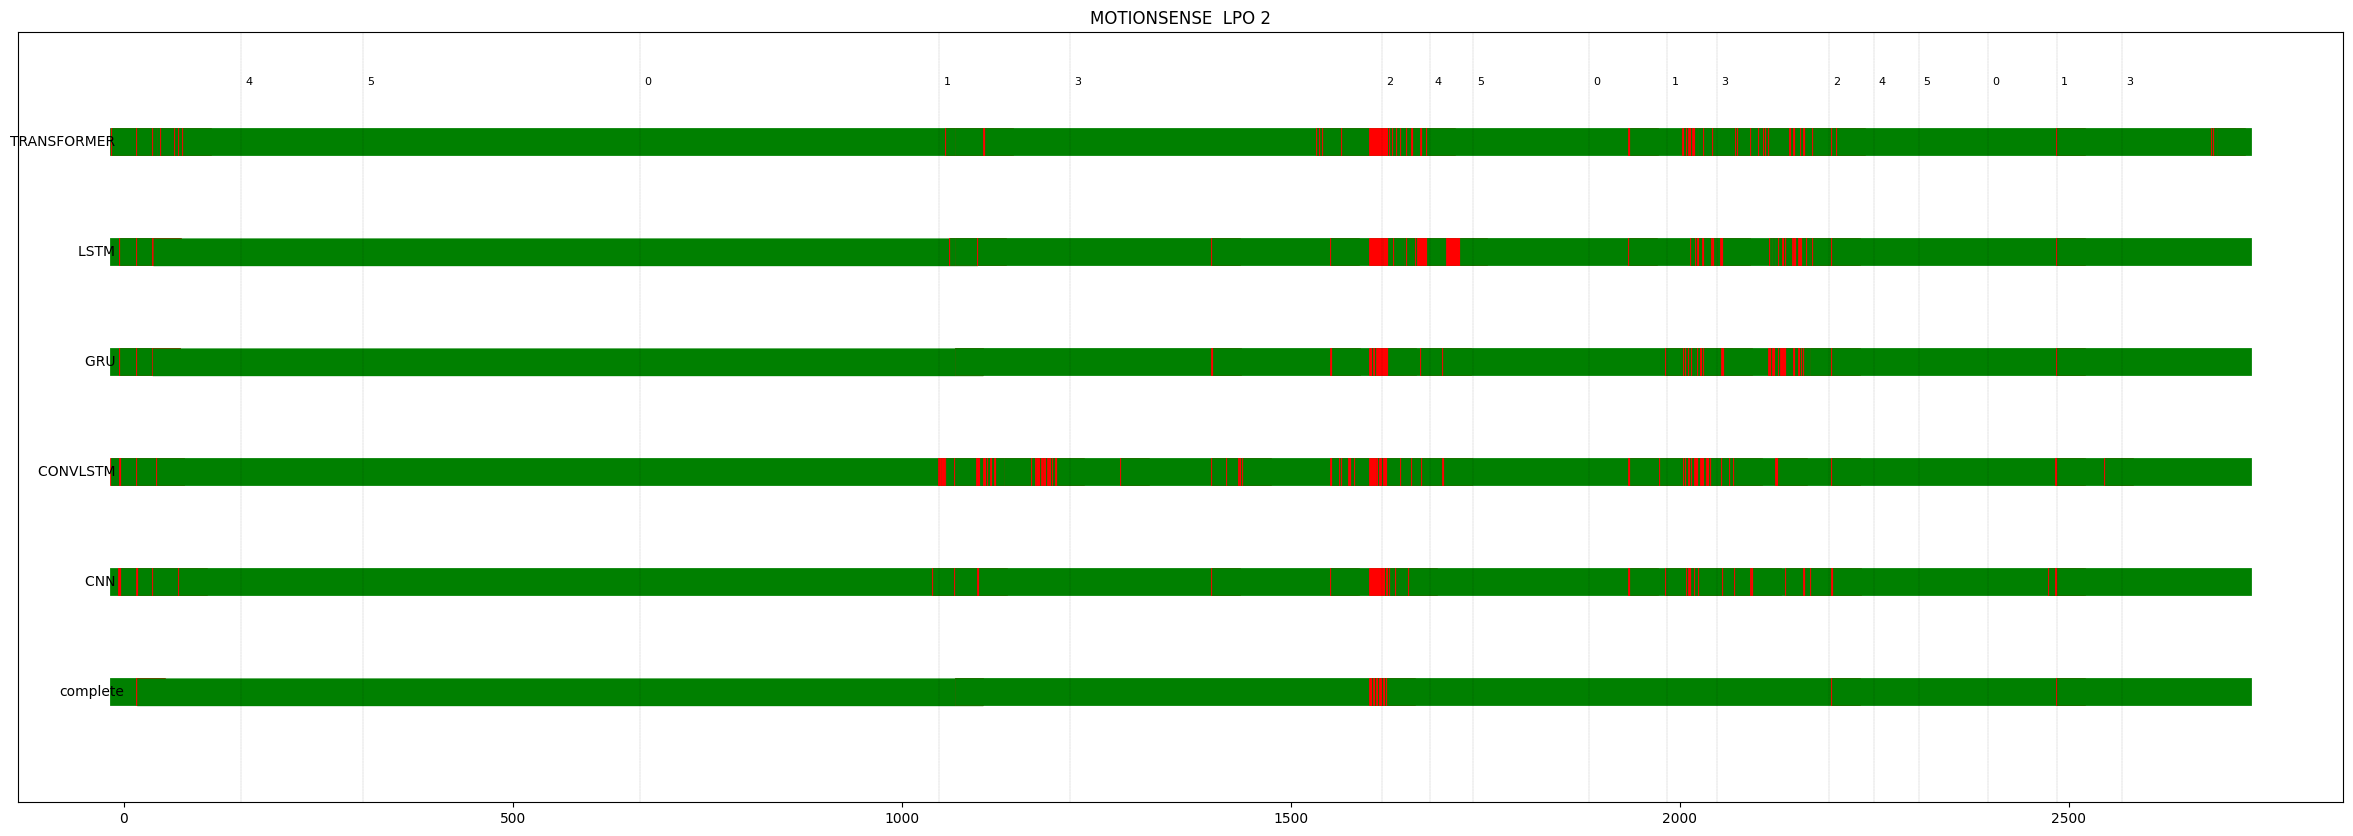

2702


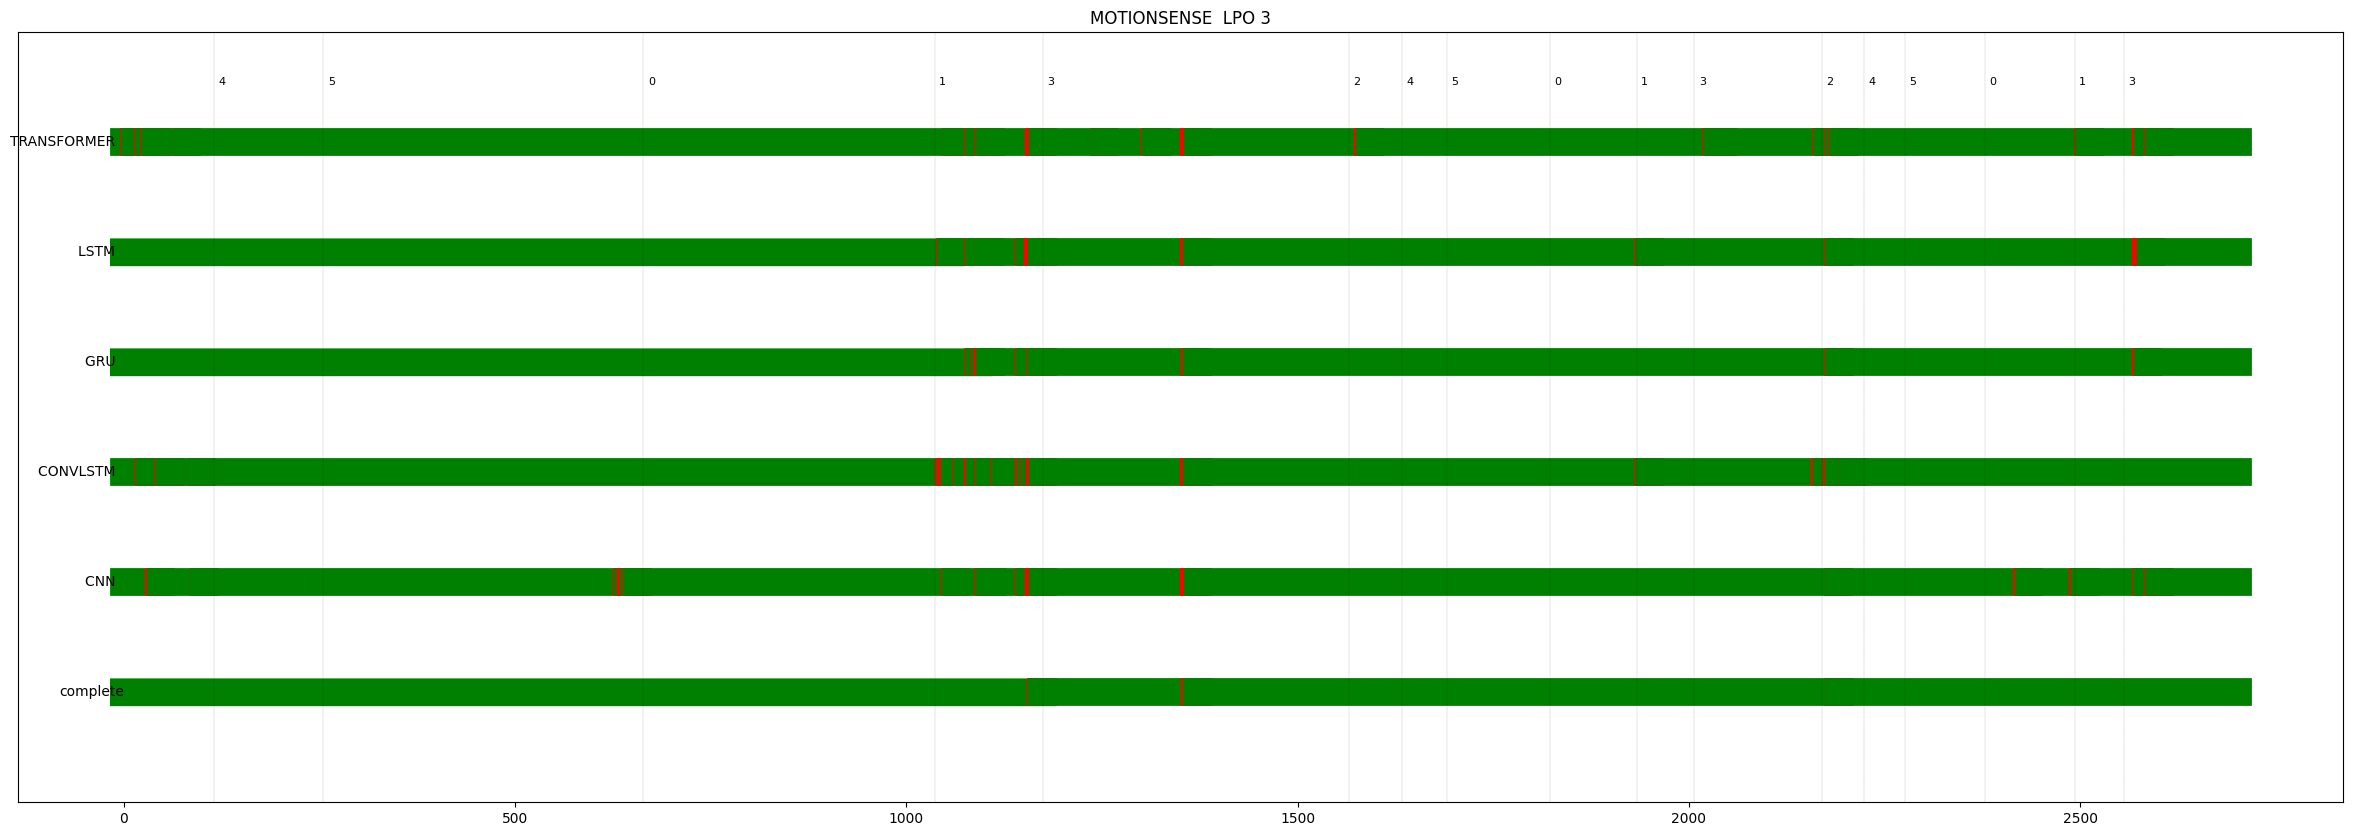

2416


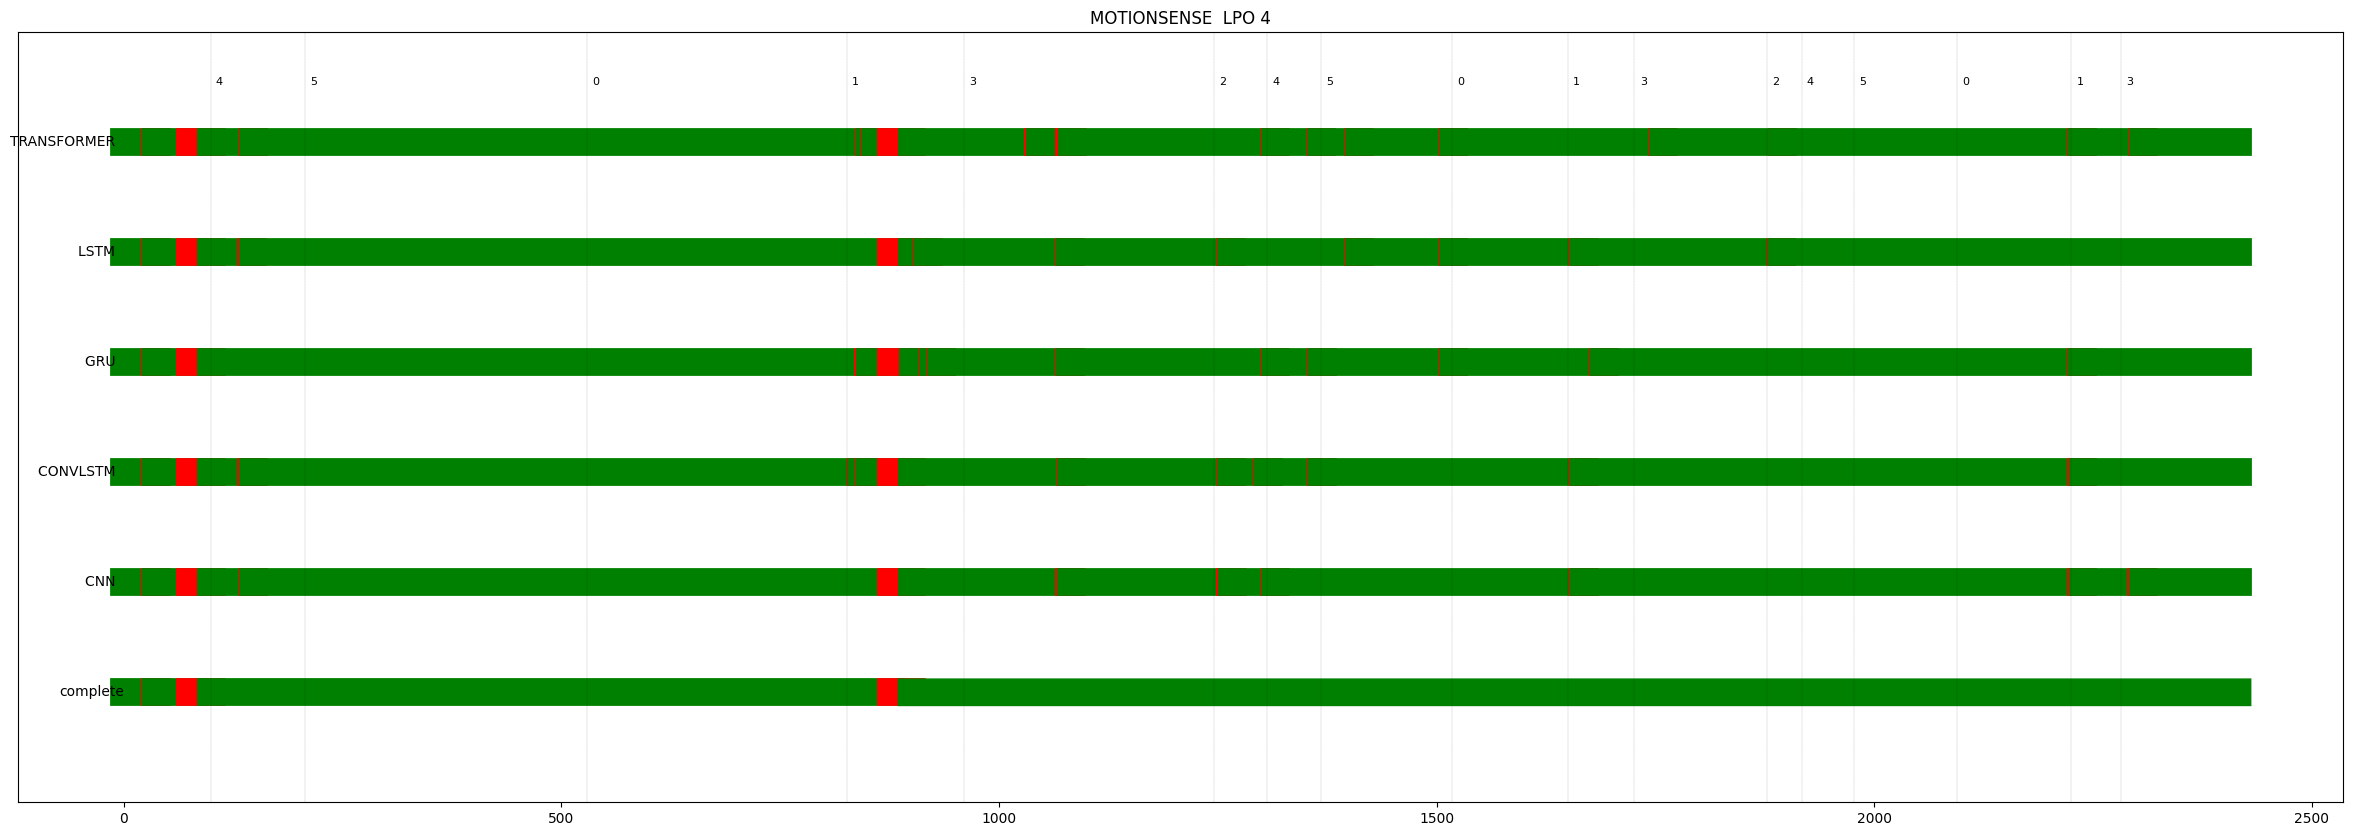

2887


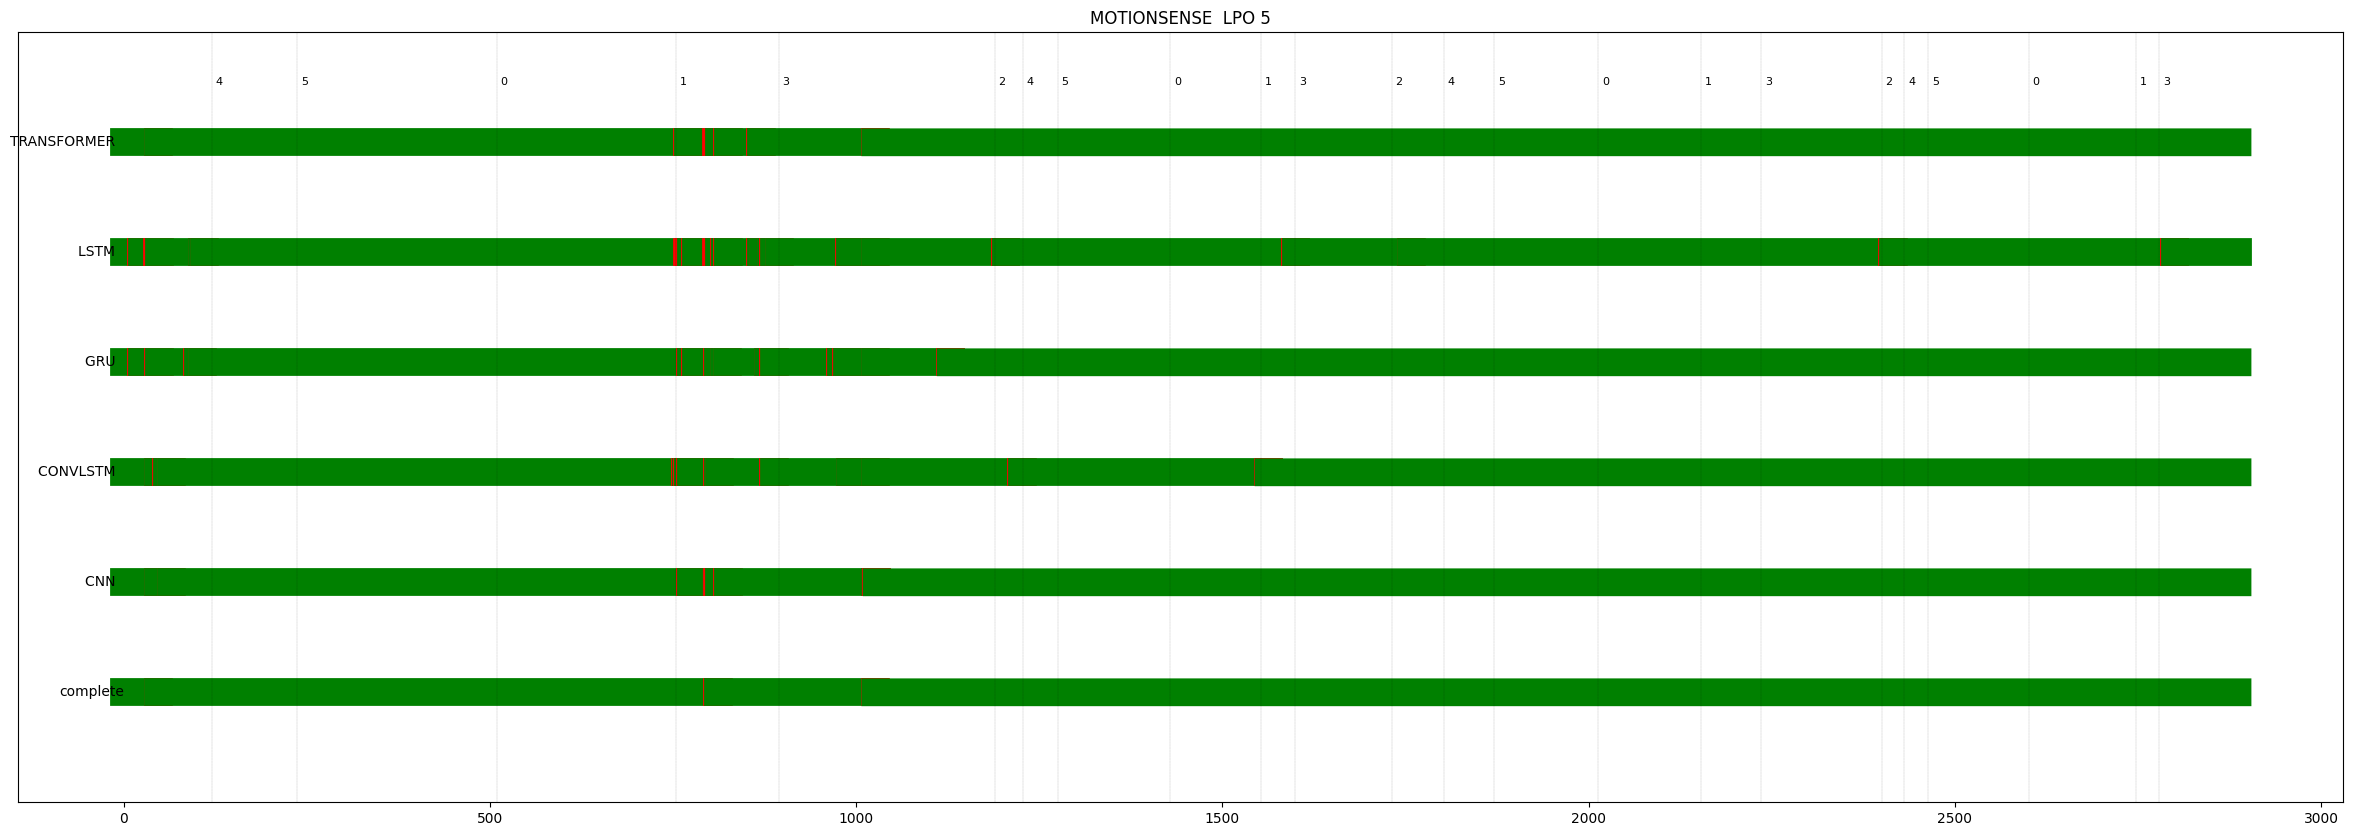

2413


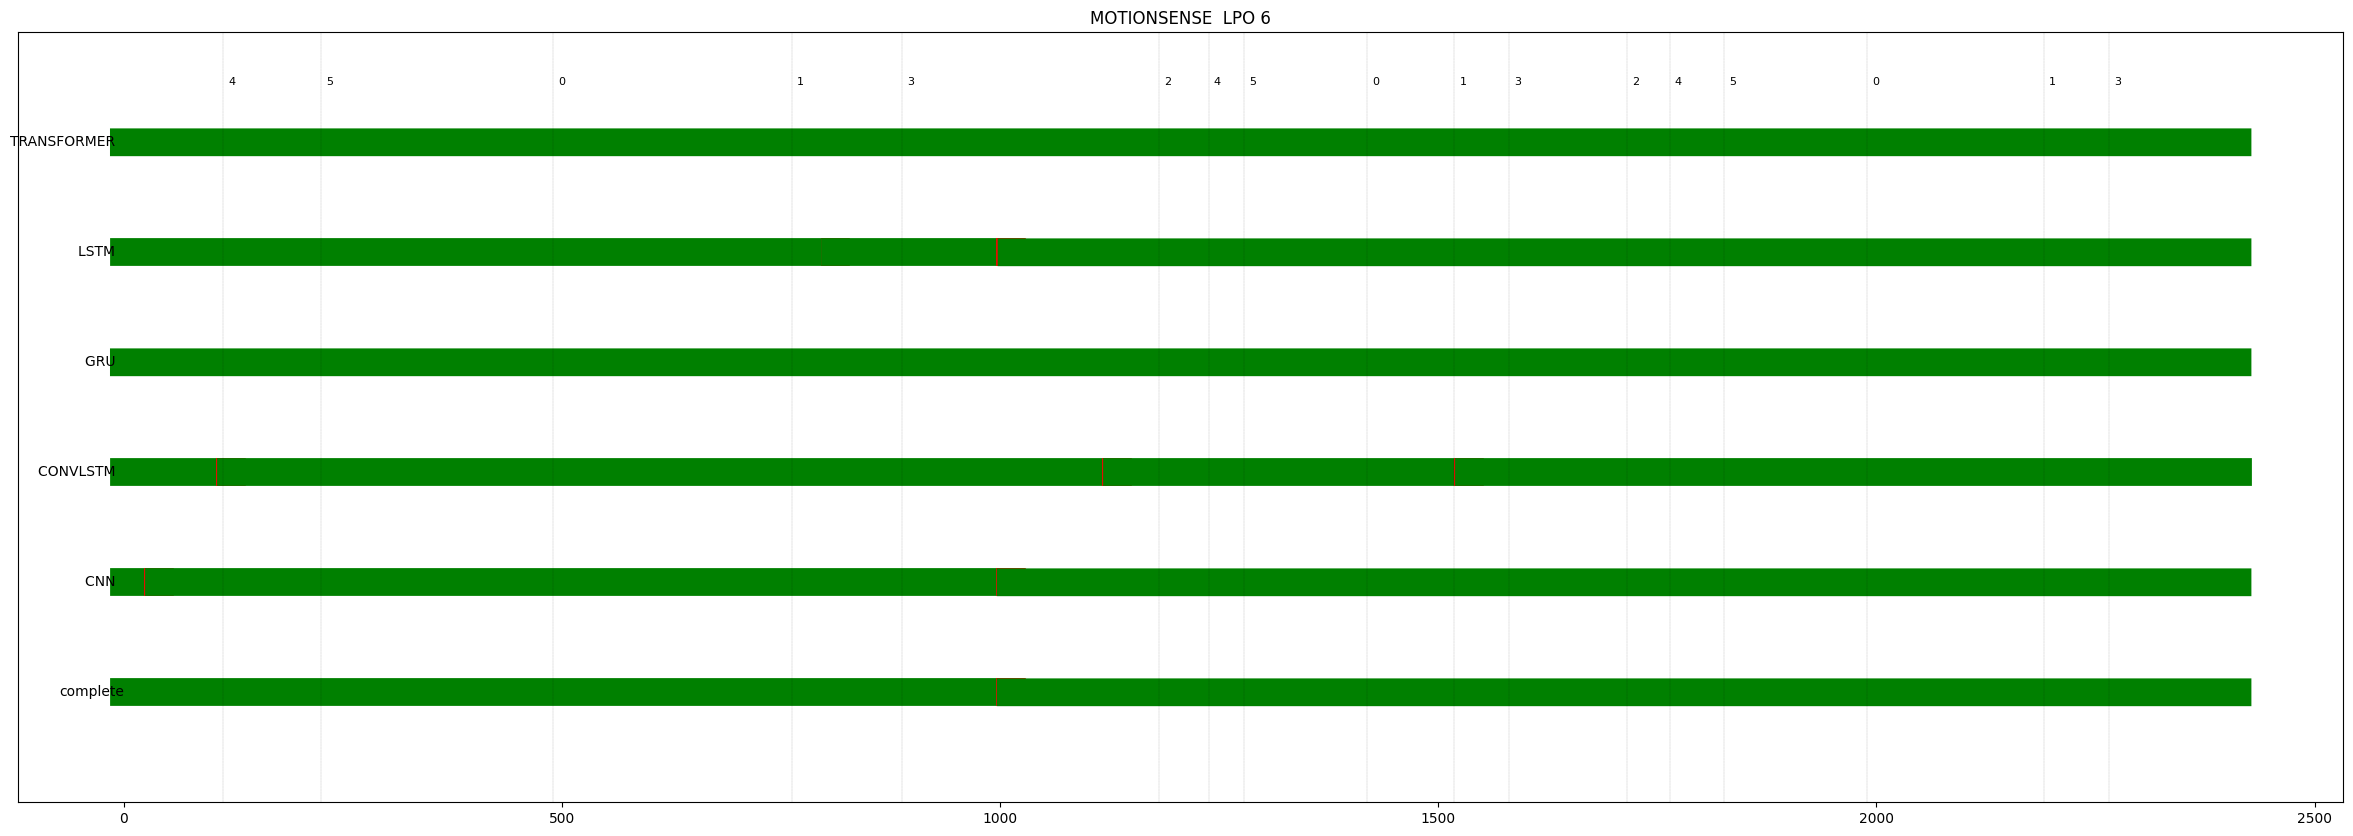

2708


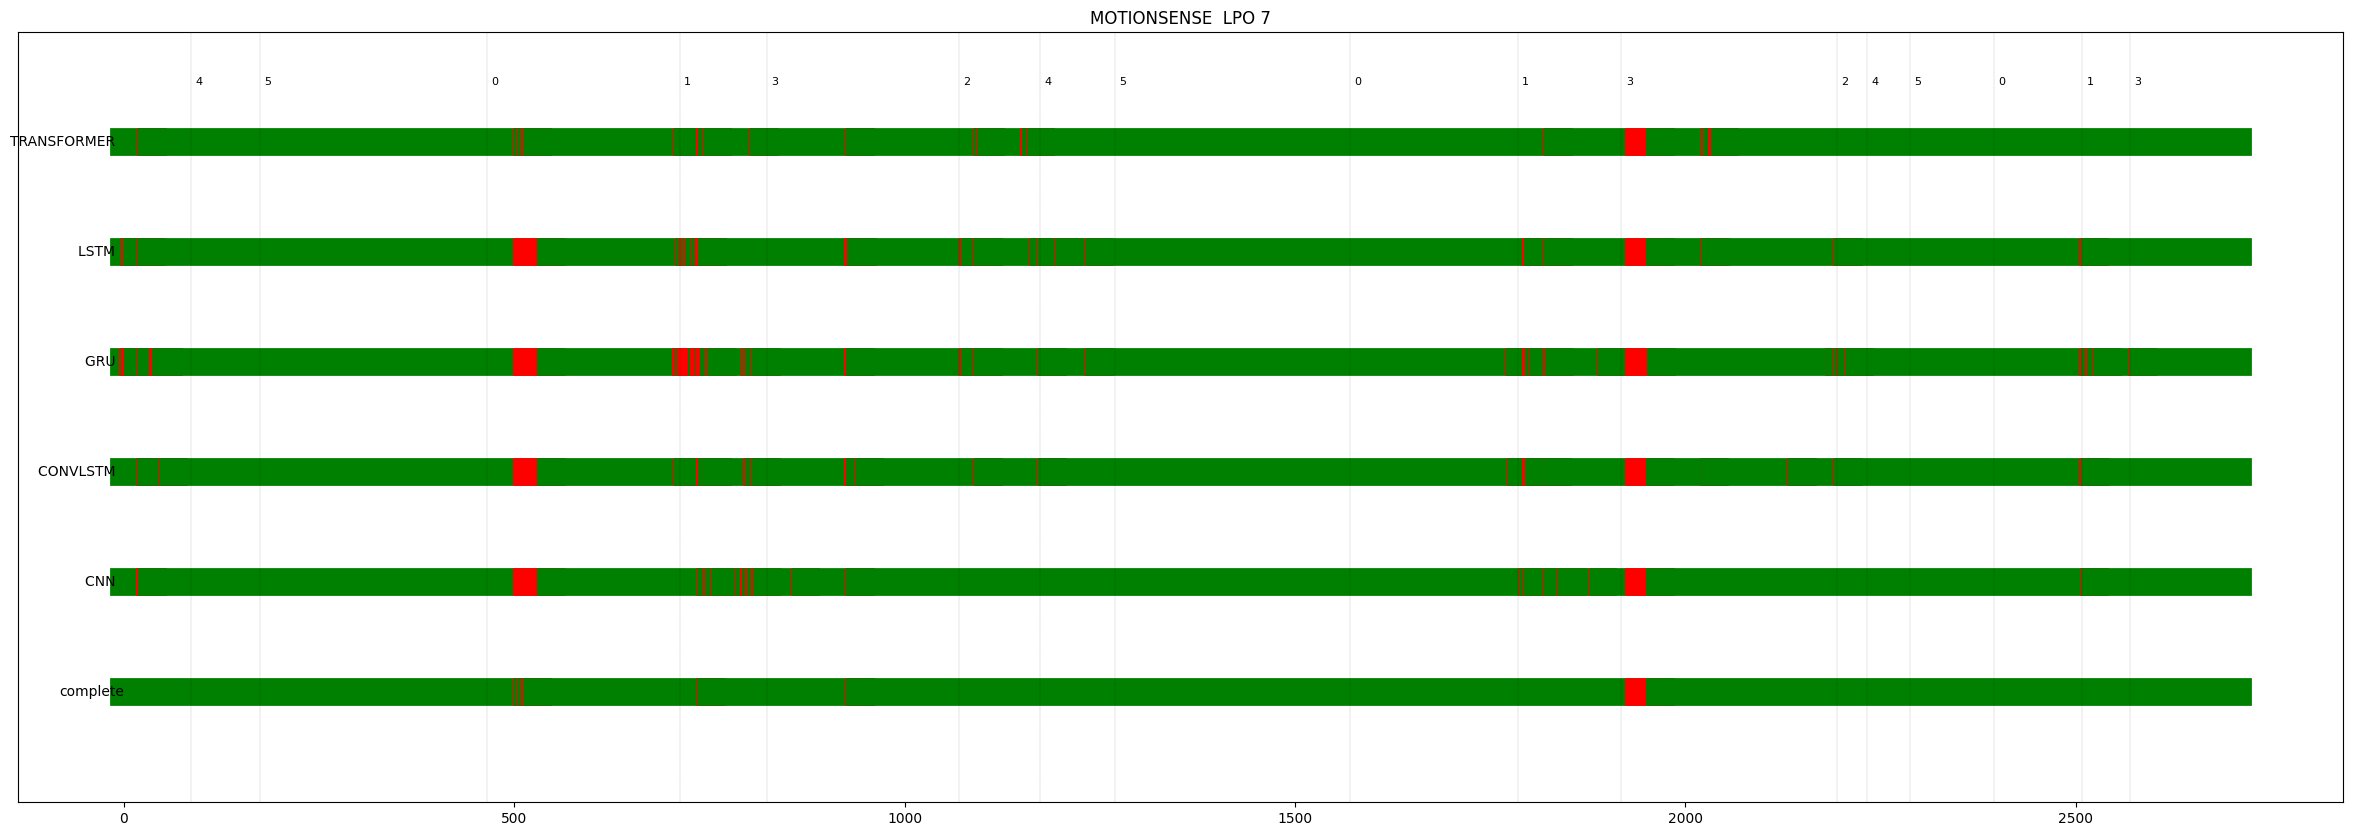

In [6]:
for dataset_id, dataset in enumerate(vectors):
    for person_id, result_arrays in enumerate(zip(*dataset)):
        model_labels_added = set()
        
        # plt.figure(figsize=(30, 10))
        result_sum = np.sum((i for i in result_arrays),dtype=int)
        
        # plt.bar(range(0,len(result_sum)),result_sum, width=1)
        
        # plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


        plt.figure(figsize=(30, 10))
        max_val = np.max(result_sum)  
        all_models = np.zeros_like(result_sum)
        all_models[result_sum == max_val] = 1  
     
        segment_starts = []
        segment_ends = []

        current_start = 0
        values = []
        values.append(all_models[0])
        for i in range(1, len(all_models)):
            if all_models[i] != all_models[i - 1]:
                segment_starts.append(current_start)
                segment_ends.append(i+1)
                current_start = i
                values.append(all_models[i])

        segment_starts.append(current_start)
        segment_ends.append(len(all_models) -1)
       
        colors = ['green' if x == 0 else 'red' for x in values]
        for start, end, color in zip(segment_starts, segment_ends, colors):
            plt.plot(range(start, end+1), np.full(end-start+1, -1), c=color, linewidth=20)
            if 'complete' not in model_labels_added:
                plt.text(start, -1, f"complete", va='center', ha='right', color='black', fontsize=10)
                model_labels_added.add('complete')




        for model_id, result_array in enumerate(result_arrays):
            result_array = result_array
            # print(MODEL_LIST[model_id])
            # print(result_array)
        
            segment_starts = []
            segment_ends = []

            current_start = 0
            values = []
            values.append(result_array[0])
            for i in range(1, len(result_array)):
                if result_array[i] != result_array[i - 1]:
                    segment_starts.append(current_start)
                    segment_ends.append(i+1)
                    current_start = i
                    values.append(result_array[i])

            segment_starts.append(current_start)
            segment_ends.append(len(result_array) -1)
            # print(segment_starts)
            # print(segment_ends)
            # print(values)
            # print(model_id)
            # print(result_array[0:200])
            # print(segment_starts)
            # print(segment_ends)
            colors = ['green' if x == 0 else 'red' for x in values]
            for start, end, color in zip(segment_starts, segment_ends, colors):
                plt.plot(range(start, end+1), np.full(end-start+1, model_id), c=color, linewidth=20)
                if model_id not in model_labels_added:
                    plt.text(start, model_id, f"{MODEL_LIST[model_id]}  ", va='center', ha='right', color='black', fontsize=10)
                    model_labels_added.add(model_id)

        y = gt[dataset_id][model_id][person_id]
        print(len(y))
        for i in range(len(y) - 1):
                if y[i] != y[i + 1]:
                    plt.axvline(x=i, color='black', linestyle='--', linewidth=0.1)
                    plt.text(i+10, 4.5, f"{y[i]}", va='bottom', ha='center', color='black', fontsize=8)


        plt.yticks([])  # Hide y-axis ticks
        plt.ylim(-2,5)
        plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))
        plt.show()

5


/var/folders/wd/jp3qk8gd7j9gb75gs1y7z_2c0000gp/T/ipykernel_43815/39275606.py:11: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)


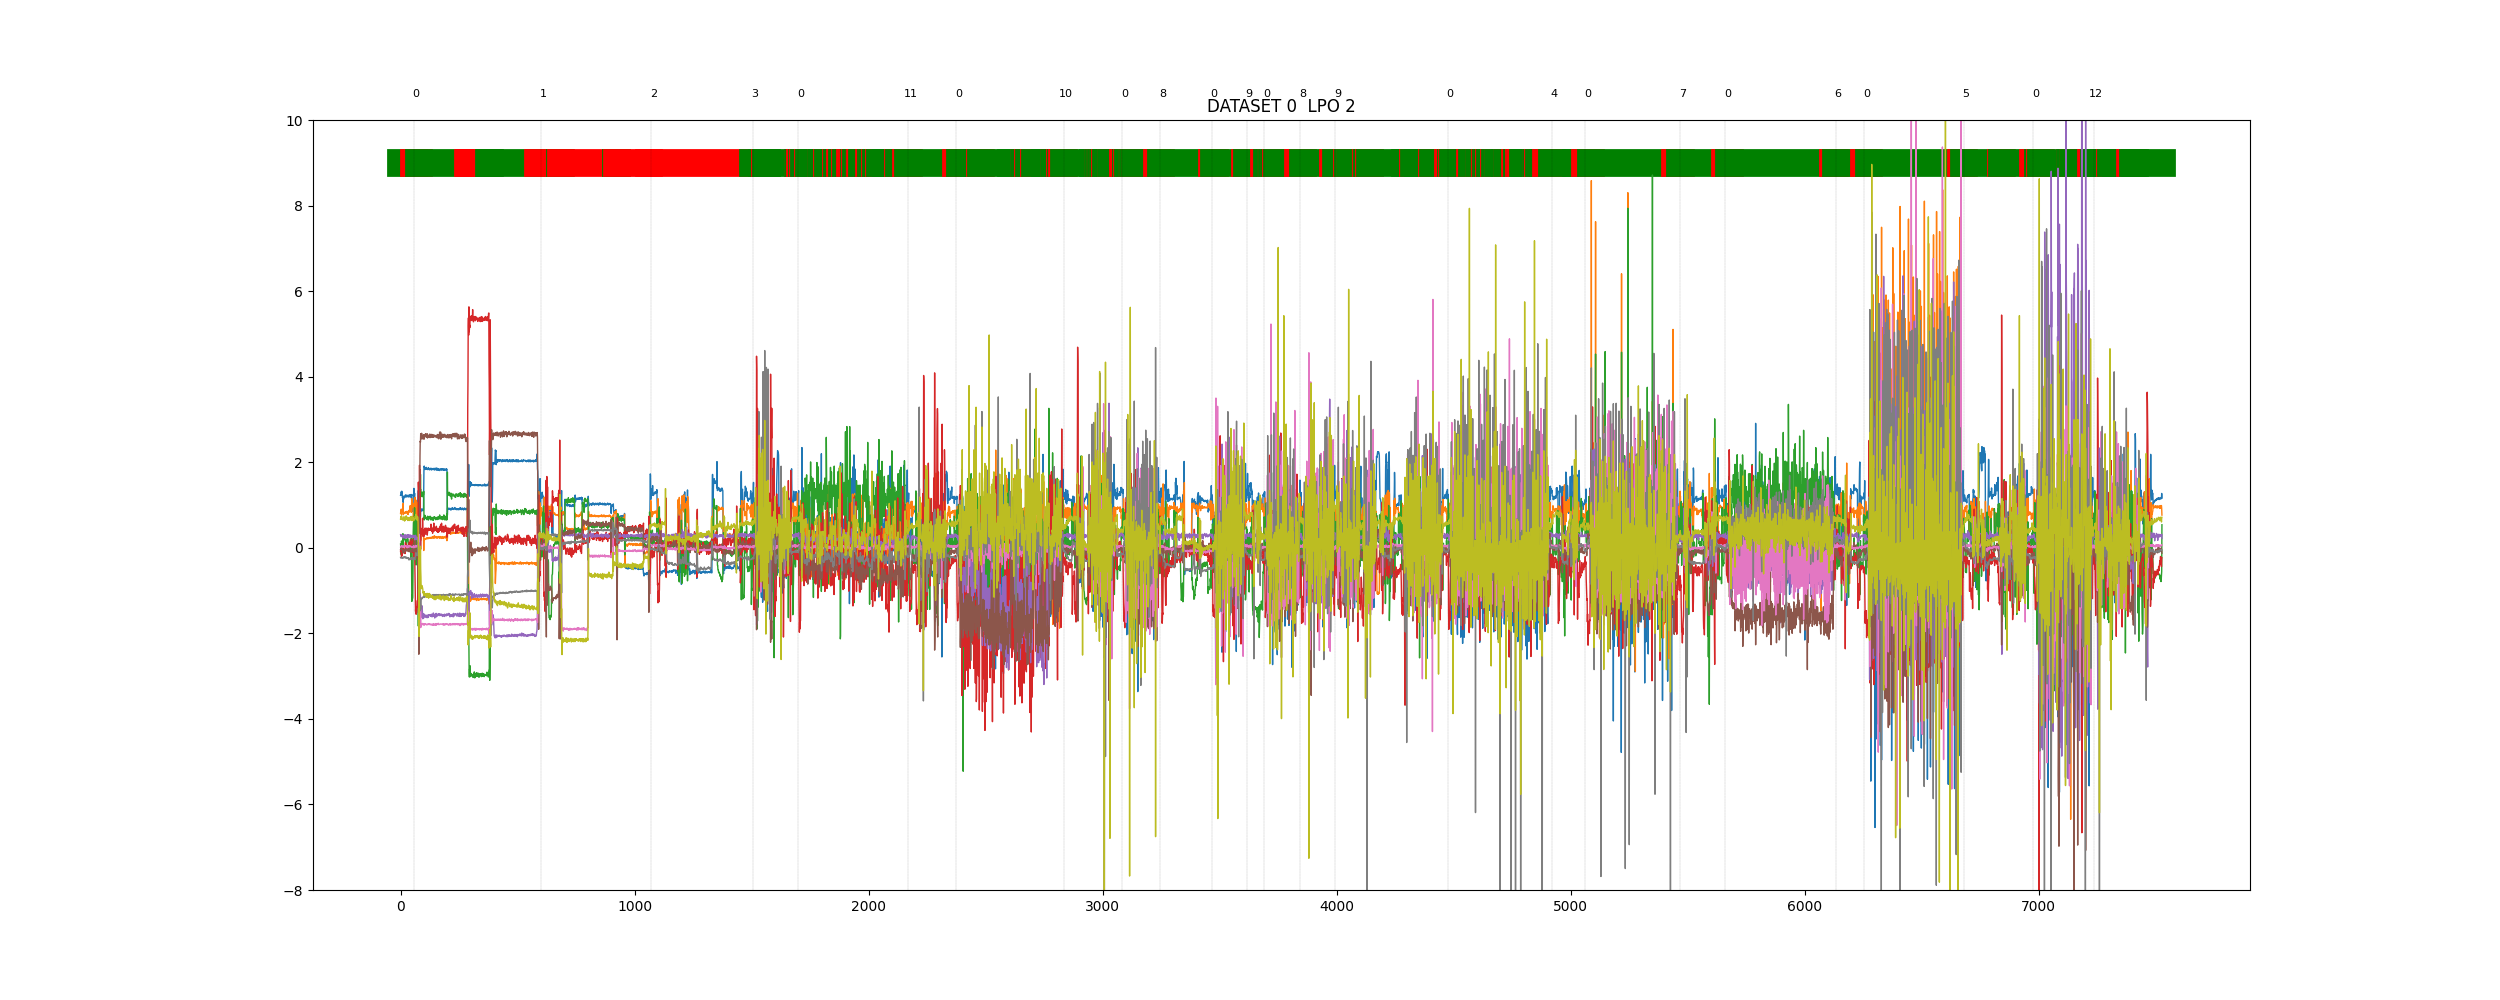

In [8]:
%matplotlib widget
import matplotlib.pyplot as plt


# model_labels_added = set()
# plt.figure(figsize=(30, 10))
DATASET = 0
PARTICIPANT = 2

print(len(sensors))
result_sum = np.sum((vectors[DATASET][i][PARTICIPANT] for i in range(0,len(vectors[DATASET]))),dtype=int)

# plt.bar(range(0,len(result_sum)),result_sum, width=1)

# plt.title(str(DATASET_LIST[dataset_id])+'  LPO '+str(person_id))


plt.figure(figsize=(25, 10))
max_val = np.max(result_sum)  
all_models = np.zeros_like(result_sum)
all_models[result_sum == max_val] = 1  

segment_starts = []
segment_ends = []

current_start = 0
values = []
values.append(all_models[0])
for i in range(1, len(all_models)):
    if all_models[i] != all_models[i - 1]:
        segment_starts.append(current_start)
        segment_ends.append(i+1)
        current_start = i
        values.append(all_models[i])

segment_starts.append(current_start)
segment_ends.append(len(all_models) -1)

colors = ['green' if x == 0 else 'red' for x in values]
for start, end, color in zip(segment_starts, segment_ends, colors):
    plt.plot(range(start, end+1), np.full(end-start+1, 9), c=color, linewidth=20)
    # if 'complete' not in model_labels_added:
    #     plt.text(start, 9, f"complete", va='center', ha='right', color='black', fontsize=10)
    #     model_labels_added.add('complete')
y = gt[DATASET][0][PARTICIPANT]
for i in range(len(y) - 1):
        if y[i] != y[i + 1]:
            plt.axvline(x=i, color='black', linestyle='--', linewidth=0.1)
            plt.text(i+10, 10.5, f"{y[i]}", va='bottom', ha='center', color='black', fontsize=8)

y = predict[DATASET][0][PARTICIPANT]

# y = np.argmax(y, axis=1)
# print(y[0])
# for i in range(len(y) - 1):
#         if y[i] != y[i + 1]:
#             # plt.axvline(x=i, color='black', linestyle='--', linewidth=0.1)
#             plt.text(i+10, 10.25, f"{y[i]}", va='bottom', ha='center', color='black', fontsize=8)

plt.plot(range(0, len(sensors[DATASET][PARTICIPANT])), sensors[DATASET][PARTICIPANT], linewidth=1)

plt.ylim(-8,10)
plt.title('DATASET '+str(DATASET)+'  LPO '+str(PARTICIPANT))
plt.show()